In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [10]:
cm_target[2]

'case2cm_blade1.csv'

In [11]:
str(cm_target[2])

'case2cm_blade1.csv'

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    #hh = generate_h(n_beta, t_len, normalize)
    #bb = generate_beta(n_beta, t_len, normalize)
    #total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    x = t
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    file = cm_target
    df = pd.DataFrame()

    data = pd.read_csv(file, header=None)
    df = pd.concat([df, data], axis=0)

    time = df.iloc[:,0].values
    cm = df.iloc[:,1].values

    time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
    cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]

    # Handle the time that is duplicated because of digits
    # Also, outliers are regulated at the second conditional statement.
    time_beUsed = handler_time(time_beUsed)
    cm_beUsed = handler_cm(cm_beUsed)

    linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                       bounds_error=False,kind='quadratic',
                                       fill_value='extrapolate')
    time_interp = np.arange(10, 15, t_interval).reshape((-1,1))

    cm_interp=linear_func(time_interp).reshape((-1,1))

    cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and $C_m$: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>10:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

    beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target[3], n_beta, t_len, normalize=True)

Dimension - time and $C_m$:  (5000, 2)
Dimension - x:  (5000, 1)
Dimension - y:  (5000, 1)


In [21]:
x -=10

In [22]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [23]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [24]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=1)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [25]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               512       
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [27]:
model_directory = "D:\\TrainedModels\\20221226_flap4_randomState50"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [28]:
ckpt_name = model_directory + "20221226unsteadyPrediction_MLP_flap4_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_randomState50_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, min_delta=1e-07,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-8, min_lr=1e-06, verbose=1)

In [29]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [30]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/3 [=========>....................] - ETA: 2s - loss: 0.2424 - rmse: 0.4923
Epoch 1: val_loss improved from inf to 0.15285, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 1s 128ms/step - loss: 0.2123 - rmse: 0.4607 - val_loss: 0.1529 - val_rmse: 0.3908 - lr: 1.0000e-04
Epoch 2/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1499 - rmse: 0.3871
Epoch 2: val_loss improved from 0.15285 to 0.11538, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.1371 - rmse: 0.3701 - val_loss: 0.1154 - val_rmse: 0.3395 - lr: 1.0000e-04
Epoch 3/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1077 - rmse: 0.3281
Epoch 3: val_loss improved from 0.

1/3 [=========>....................] - ETA: 0s - loss: 0.0892 - rmse: 0.2985
Epoch 21: val_loss improved from 0.08841 to 0.08748, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 41ms/step - loss: 0.0874 - rmse: 0.2955 - val_loss: 0.0875 - val_rmse: 0.2956 - lr: 1.0000e-04
Epoch 22/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0886 - rmse: 0.2975
Epoch 22: val_loss improved from 0.08748 to 0.08644, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 0.0839 - rmse: 0.2895 - val_loss: 0.0864 - val_rmse: 0.2938 - lr: 1.0000e-04
Epoch 23/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0870 - rmse: 0.2947
Epoch 23: val_loss improved from 0.08644 

3/3 [==============================] - 0s 36ms/step - loss: 0.0728 - rmse: 0.2696 - val_loss: 0.0713 - val_rmse: 0.2669 - lr: 1.0000e-04
Epoch 40/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0746 - rmse: 0.2730
Epoch 40: val_loss improved from 0.07134 to 0.07055, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 41ms/step - loss: 0.0705 - rmse: 0.2653 - val_loss: 0.0706 - val_rmse: 0.2654 - lr: 1.0000e-04
Epoch 41/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0706 - rmse: 0.2654
Epoch 41: val_loss improved from 0.07055 to 0.07014, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 41ms/step - loss: 0.0723 - rmse: 0.2687 - val_loss: 0.0701 - val_rmse: 0.264

Epoch 60/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0695 - rmse: 0.2634
Epoch 60: val_loss improved from 0.06785 to 0.06769, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0674 - rmse: 0.2594 - val_loss: 0.0677 - val_rmse: 0.2600 - lr: 1.0000e-04
Epoch 61/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0675 - rmse: 0.2597
Epoch 61: val_loss improved from 0.06769 to 0.06761, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0665 - rmse: 0.2577 - val_loss: 0.0676 - val_rmse: 0.2598 - lr: 1.0000e-04
Epoch 62/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0771 - rmse: 0.2775
Epoch 62: val_loss did not

3/3 [==============================] - 0s 47ms/step - loss: 0.0659 - rmse: 0.2565 - val_loss: 0.0661 - val_rmse: 0.2570 - lr: 1.0000e-04
Epoch 82/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0660 - rmse: 0.2567
Epoch 82: val_loss improved from 0.06614 to 0.06603, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0644 - rmse: 0.2536 - val_loss: 0.0660 - val_rmse: 0.2568 - lr: 1.0000e-04
Epoch 83/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0657 - rmse: 0.2561
Epoch 83: val_loss did not improve from 0.06603
3/3 [==============================] - 0s 21ms/step - loss: 0.0678 - rmse: 0.2602 - val_loss: 0.0665 - val_rmse: 0.2577 - lr: 1.0000e-04
Epoch 84/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0620 - rmse: 0.2488
Epoch 84: val_loss improved from 0.06603 to 0.06592, 

3/3 [==============================] - 0s 50ms/step - loss: 0.0643 - rmse: 0.2535 - val_loss: 0.0642 - val_rmse: 0.2532 - lr: 1.0000e-04
Epoch 105/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0594 - rmse: 0.2434
Epoch 105: val_loss did not improve from 0.06422
3/3 [==============================] - 0s 21ms/step - loss: 0.0636 - rmse: 0.2519 - val_loss: 0.0643 - val_rmse: 0.2534 - lr: 1.0000e-04
Epoch 106/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0640 - rmse: 0.2529
Epoch 106: val_loss improved from 0.06422 to 0.06419, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0641 - rmse: 0.2530 - val_loss: 0.0642 - val_rmse: 0.2532 - lr: 1.0000e-04
Epoch 107/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0614 - rmse: 0.2477
Epoch 107: val_loss improved from 0.06419 to 0.0

3/3 [==============================] - 0s 44ms/step - loss: 0.0602 - rmse: 0.2450 - val_loss: 0.0623 - val_rmse: 0.2494 - lr: 1.0000e-04
Epoch 126/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0689 - rmse: 0.2622
Epoch 126: val_loss did not improve from 0.06232
3/3 [==============================] - 0s 21ms/step - loss: 0.0650 - rmse: 0.2548 - val_loss: 0.0630 - val_rmse: 0.2507 - lr: 1.0000e-04
Epoch 127/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0579 - rmse: 0.2405
Epoch 127: val_loss improved from 0.06232 to 0.06228, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0592 - rmse: 0.2431 - val_loss: 0.0623 - val_rmse: 0.2494 - lr: 1.0000e-04
Epoch 128/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0593 - rmse: 0.2434
Epoch 128: val_loss did not improve from 0.06228

Epoch 148/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0574 - rmse: 0.2394
Epoch 148: val_loss did not improve from 0.06069
3/3 [==============================] - 0s 21ms/step - loss: 0.0595 - rmse: 0.2438 - val_loss: 0.0608 - val_rmse: 0.2464 - lr: 1.0000e-04
Epoch 149/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0601 - rmse: 0.2449
Epoch 149: val_loss improved from 0.06069 to 0.06056, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0588 - rmse: 0.2423 - val_loss: 0.0606 - val_rmse: 0.2459 - lr: 1.0000e-04
Epoch 150/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0613 - rmse: 0.2473
Epoch 150: val_loss improved from 0.06056 to 0.06042, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_

3/3 [==============================] - 0s 47ms/step - loss: 0.0550 - rmse: 0.2344 - val_loss: 0.0596 - val_rmse: 0.2440 - lr: 1.0000e-04
Epoch 171/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0613 - rmse: 0.2474
Epoch 171: val_loss did not improve from 0.05965
3/3 [==============================] - 0s 22ms/step - loss: 0.0618 - rmse: 0.2484 - val_loss: 0.0604 - val_rmse: 0.2456 - lr: 1.0000e-04
Epoch 172/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0581 - rmse: 0.2409
Epoch 172: val_loss improved from 0.05965 to 0.05954, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0553 - rmse: 0.2350 - val_loss: 0.0595 - val_rmse: 0.2438 - lr: 1.0000e-04
Epoch 173/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0528 - rmse: 0.2296
Epoch 173: val_loss improved from 0.05954 to 0.0

Epoch 194/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0591 - rmse: 0.2428
Epoch 194: val_loss improved from 0.05913 to 0.05900, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0543 - rmse: 0.2328 - val_loss: 0.0590 - val_rmse: 0.2427 - lr: 1.0000e-04
Epoch 195/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0598 - rmse: 0.2444
Epoch 195: val_loss did not improve from 0.05900
3/3 [==============================] - 0s 22ms/step - loss: 0.0591 - rmse: 0.2429 - val_loss: 0.0593 - val_rmse: 0.2432 - lr: 1.0000e-04
Epoch 196/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0572 - rmse: 0.2391
Epoch 196: val_loss did not improve from 0.05900
3/3 [==============================] - 0s 22ms/step - loss: 0.0587 - rmse: 0.2421 - val_loss: 0.0591 - val_rmse: 0.2430 - lr: 1.0000e-04

Epoch 219/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0588 - rmse: 0.2422
Epoch 219: val_loss did not improve from 0.05869
3/3 [==============================] - 0s 21ms/step - loss: 0.0570 - rmse: 0.2386 - val_loss: 0.0592 - val_rmse: 0.2431 - lr: 1.0000e-04
Epoch 220/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0546 - rmse: 0.2336
Epoch 220: val_loss did not improve from 0.05869
3/3 [==============================] - 0s 22ms/step - loss: 0.0568 - rmse: 0.2382 - val_loss: 0.0593 - val_rmse: 0.2434 - lr: 1.0000e-04
Epoch 221/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0577 - rmse: 0.2400
Epoch 221: val_loss did not improve from 0.05869
3/3 [==============================] - 0s 21ms/step - loss: 0.0587 - rmse: 0.2421 - val_loss: 0.0592 - val_rmse: 0.2431 - lr: 1.0000e-04
Epoch 222/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0507 - rmse: 0.2250
Epoch 222: val_loss did not improve from 0.05869
3/3 [================

Epoch 244/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0543 - rmse: 0.2327
Epoch 244: val_loss did not improve from 0.05835
3/3 [==============================] - 0s 22ms/step - loss: 0.0550 - rmse: 0.2343 - val_loss: 0.0586 - val_rmse: 0.2419 - lr: 1.0000e-04
Epoch 245/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0545 - rmse: 0.2333
Epoch 245: val_loss improved from 0.05835 to 0.05835, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0567 - rmse: 0.2378 - val_loss: 0.0584 - val_rmse: 0.2414 - lr: 1.0000e-04
Epoch 246/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0547 - rmse: 0.2336
Epoch 246: val_loss did not improve from 0.05835
3/3 [==============================] - 0s 21ms/step - loss: 0.0563 - rmse: 0.2370 - val_loss: 0.0587 - val_rmse: 0.2421 - lr: 1.0000e-04

3/3 [==============================] - 0s 45ms/step - loss: 0.0570 - rmse: 0.2386 - val_loss: 0.0582 - val_rmse: 0.2410 - lr: 1.0000e-04
Epoch 271/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0542 - rmse: 0.2326
Epoch 271: val_loss did not improve from 0.05816
3/3 [==============================] - 0s 21ms/step - loss: 0.0564 - rmse: 0.2372 - val_loss: 0.0591 - val_rmse: 0.2430 - lr: 1.0000e-04
Epoch 272/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0562 - rmse: 0.2368
Epoch 272: val_loss did not improve from 0.05816
3/3 [==============================] - 0s 21ms/step - loss: 0.0562 - rmse: 0.2368 - val_loss: 0.0582 - val_rmse: 0.2411 - lr: 1.0000e-04
Epoch 273/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0554 - rmse: 0.2352
Epoch 273: val_loss did not improve from 0.05816
3/3 [==============================] - 0s 22ms/step - loss: 0.0564 - rmse: 0.2373 - val_loss: 0.0585 - val_rmse: 0.2416 - lr: 1.0000e-04
Epoch 274/10000
1/3 [=====

Epoch 298/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0549 - rmse: 0.2341
Epoch 298: val_loss did not improve from 0.05809
3/3 [==============================] - 0s 21ms/step - loss: 0.0577 - rmse: 0.2401 - val_loss: 0.0588 - val_rmse: 0.2422 - lr: 1.0000e-04
Epoch 299/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0528 - rmse: 0.2296
Epoch 299: val_loss did not improve from 0.05809
3/3 [==============================] - 0s 22ms/step - loss: 0.0547 - rmse: 0.2338 - val_loss: 0.0583 - val_rmse: 0.2412 - lr: 1.0000e-04
Epoch 300/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0578 - rmse: 0.2401
Epoch 300: val_loss did not improve from 0.05809
3/3 [==============================] - 0s 22ms/step - loss: 0.0564 - rmse: 0.2373 - val_loss: 0.0589 - val_rmse: 0.2426 - lr: 1.0000e-04
Epoch 301/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0554 - rmse: 0.2353
Epoch 301: val_loss did not improve from 0.05809
3/3 [================

3/3 [==============================] - 0s 21ms/step - loss: 0.0572 - rmse: 0.2390 - val_loss: 0.0581 - val_rmse: 0.2409 - lr: 1.0000e-04
Epoch 325/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0555 - rmse: 0.2355
Epoch 325: val_loss did not improve from 0.05800
3/3 [==============================] - 0s 22ms/step - loss: 0.0561 - rmse: 0.2366 - val_loss: 0.0586 - val_rmse: 0.2419 - lr: 1.0000e-04
Epoch 326/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0581 - rmse: 0.2409
Epoch 326: val_loss did not improve from 0.05800
3/3 [==============================] - 0s 21ms/step - loss: 0.0577 - rmse: 0.2399 - val_loss: 0.0581 - val_rmse: 0.2409 - lr: 1.0000e-04
Epoch 327/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0521 - rmse: 0.2281
Epoch 327: val_loss did not improve from 0.05800
3/3 [==============================] - 0s 22ms/step - loss: 0.0553 - rmse: 0.2349 - val_loss: 0.0580 - val_rmse: 0.2407 - lr: 1.0000e-04
Epoch 328/10000
1/3 [=====

1/3 [=========>....................] - ETA: 0s - loss: 0.0569 - rmse: 0.2384
Epoch 352: val_loss did not improve from 0.05793
3/3 [==============================] - 0s 21ms/step - loss: 0.0577 - rmse: 0.2400 - val_loss: 0.0586 - val_rmse: 0.2419 - lr: 1.0000e-04
Epoch 353/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0533 - rmse: 0.2307
Epoch 353: val_loss did not improve from 0.05793
3/3 [==============================] - 0s 21ms/step - loss: 0.0560 - rmse: 0.2365 - val_loss: 0.0580 - val_rmse: 0.2405 - lr: 1.0000e-04
Epoch 354/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0551 - rmse: 0.2345
Epoch 354: val_loss did not improve from 0.05793
3/3 [==============================] - 0s 22ms/step - loss: 0.0561 - rmse: 0.2367 - val_loss: 0.0581 - val_rmse: 0.2409 - lr: 1.0000e-04
Epoch 355/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0551 - rmse: 0.2344
Epoch 355: val_loss did not improve from 0.05793
3/3 [==============================] 

1/3 [=========>....................] - ETA: 0s - loss: 0.0555 - rmse: 0.2353
Epoch 379: val_loss did not improve from 0.05790
3/3 [==============================] - 0s 21ms/step - loss: 0.0548 - rmse: 0.2340 - val_loss: 0.0583 - val_rmse: 0.2413 - lr: 1.0000e-04
Epoch 380/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0549 - rmse: 0.2340
Epoch 380: val_loss did not improve from 0.05790
3/3 [==============================] - 0s 21ms/step - loss: 0.0558 - rmse: 0.2360 - val_loss: 0.0590 - val_rmse: 0.2428 - lr: 1.0000e-04
Epoch 381/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0590 - rmse: 0.2427
Epoch 381: val_loss improved from 0.05790 to 0.05787, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0575 - rmse: 0.2396 - val_loss: 0.0579 - val_rmse: 0.2404 - lr: 1.0000e-04
Epoch 382/10000

Epoch 407/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0580 - rmse: 0.2406
Epoch 407: val_loss did not improve from 0.05786
3/3 [==============================] - 0s 22ms/step - loss: 0.0558 - rmse: 0.2360 - val_loss: 0.0582 - val_rmse: 0.2410 - lr: 1.0000e-04
Epoch 408/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0557 - rmse: 0.2358
Epoch 408: val_loss did not improve from 0.05786
3/3 [==============================] - 0s 20ms/step - loss: 0.0562 - rmse: 0.2368 - val_loss: 0.0591 - val_rmse: 0.2429 - lr: 1.0000e-04
Epoch 409/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0598 - rmse: 0.2444
Epoch 409: val_loss did not improve from 0.05786
3/3 [==============================] - 0s 22ms/step - loss: 0.0572 - rmse: 0.2390 - val_loss: 0.0579 - val_rmse: 0.2405 - lr: 1.0000e-04
Epoch 410/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0527 - rmse: 0.2295
Epoch 410: val_loss did not improve from 0.05786
3/3 [================

1/3 [=========>....................] - ETA: 0s - loss: 0.0638 - rmse: 0.2524
Epoch 434: val_loss did not improve from 0.05777
3/3 [==============================] - 0s 22ms/step - loss: 0.0574 - rmse: 0.2394 - val_loss: 0.0578 - val_rmse: 0.2402 - lr: 1.0000e-04
Epoch 435/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0584 - rmse: 0.2415
Epoch 435: val_loss did not improve from 0.05777
3/3 [==============================] - 0s 21ms/step - loss: 0.0551 - rmse: 0.2345 - val_loss: 0.0581 - val_rmse: 0.2409 - lr: 1.0000e-04
Epoch 436/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0555 - rmse: 0.2354
Epoch 436: val_loss did not improve from 0.05777
3/3 [==============================] - 0s 21ms/step - loss: 0.0564 - rmse: 0.2372 - val_loss: 0.0578 - val_rmse: 0.2402 - lr: 1.0000e-04
Epoch 437/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0535 - rmse: 0.2311
Epoch 437: val_loss did not improve from 0.05777
3/3 [==============================] 

1/3 [=========>....................] - ETA: 0s - loss: 0.0574 - rmse: 0.2394
Epoch 461: val_loss did not improve from 0.05769
3/3 [==============================] - 0s 21ms/step - loss: 0.0571 - rmse: 0.2387 - val_loss: 0.0578 - val_rmse: 0.2403 - lr: 1.0000e-04
Epoch 462/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0478 - rmse: 0.2185
Epoch 462: val_loss did not improve from 0.05769
3/3 [==============================] - 0s 21ms/step - loss: 0.0523 - rmse: 0.2284 - val_loss: 0.0578 - val_rmse: 0.2401 - lr: 1.0000e-04
Epoch 463/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0591 - rmse: 0.2430
Epoch 463: val_loss did not improve from 0.05769
3/3 [==============================] - 0s 21ms/step - loss: 0.0590 - rmse: 0.2427 - val_loss: 0.0589 - val_rmse: 0.2425 - lr: 1.0000e-04
Epoch 464/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0552 - rmse: 0.2348
Epoch 464: val_loss did not improve from 0.05769
3/3 [==============================] 

3/3 [==============================] - 0s 52ms/step - loss: 0.0545 - rmse: 0.2333 - val_loss: 0.0577 - val_rmse: 0.2399 - lr: 1.0000e-04
Epoch 490/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0628 - rmse: 0.2505
Epoch 490: val_loss did not improve from 0.05765
3/3 [==============================] - 0s 21ms/step - loss: 0.0578 - rmse: 0.2403 - val_loss: 0.0581 - val_rmse: 0.2408 - lr: 1.0000e-04
Epoch 491/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0550 - rmse: 0.2342
Epoch 491: val_loss did not improve from 0.05765
3/3 [==============================] - 0s 22ms/step - loss: 0.0553 - rmse: 0.2350 - val_loss: 0.0577 - val_rmse: 0.2400 - lr: 1.0000e-04
Epoch 492/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0581 - rmse: 0.2409
Epoch 492: val_loss did not improve from 0.05765
3/3 [==============================] - 0s 21ms/step - loss: 0.0554 - rmse: 0.2351 - val_loss: 0.0578 - val_rmse: 0.2402 - lr: 1.0000e-04
Epoch 493/10000
1/3 [=====

Epoch 518/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0576 - rmse: 0.2399
Epoch 518: val_loss did not improve from 0.05763
3/3 [==============================] - 0s 22ms/step - loss: 0.0577 - rmse: 0.2400 - val_loss: 0.0577 - val_rmse: 0.2401 - lr: 1.0000e-04
Epoch 519/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0530 - rmse: 0.2301
Epoch 519: val_loss improved from 0.05763 to 0.05762, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0535 - rmse: 0.2311 - val_loss: 0.0576 - val_rmse: 0.2399 - lr: 1.0000e-04
Epoch 520/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0567 - rmse: 0.2380
Epoch 520: val_loss did not improve from 0.05762
3/3 [==============================] - 0s 22ms/step - loss: 0.0563 - rmse: 0.2372 - val_loss: 0.0578 - val_rmse: 0.2401 - lr: 1.0000e-04

3/3 [==============================] - 0s 22ms/step - loss: 0.0573 - rmse: 0.2391 - val_loss: 0.0579 - val_rmse: 0.2404 - lr: 1.0000e-04
Epoch 545/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0551 - rmse: 0.2346
Epoch 545: val_loss did not improve from 0.05755
3/3 [==============================] - 0s 21ms/step - loss: 0.0550 - rmse: 0.2344 - val_loss: 0.0578 - val_rmse: 0.2402 - lr: 1.0000e-04
Epoch 546/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0602 - rmse: 0.2452
Epoch 546: val_loss improved from 0.05755 to 0.05751, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0558 - rmse: 0.2361 - val_loss: 0.0575 - val_rmse: 0.2396 - lr: 1.0000e-04
Epoch 547/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0591 - rmse: 0.2430
Epoch 547: val_loss did not improve from 0.05751

Epoch 572/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0544 - rmse: 0.2330
Epoch 572: val_loss improved from 0.05748 to 0.05747, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0540 - rmse: 0.2323 - val_loss: 0.0575 - val_rmse: 0.2395 - lr: 1.0000e-04
Epoch 573/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0523 - rmse: 0.2284
Epoch 573: val_loss did not improve from 0.05747
3/3 [==============================] - 0s 21ms/step - loss: 0.0563 - rmse: 0.2370 - val_loss: 0.0577 - val_rmse: 0.2400 - lr: 1.0000e-04
Epoch 574/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0531 - rmse: 0.2302
Epoch 574: val_loss did not improve from 0.05747
3/3 [==============================] - 0s 22ms/step - loss: 0.0542 - rmse: 0.2326 - val_loss: 0.0577 - val_rmse: 0.2401 - lr: 1.0000e-04

Epoch 598/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0561 - rmse: 0.2367
Epoch 598: val_loss did not improve from 0.05740
3/3 [==============================] - 0s 21ms/step - loss: 0.0564 - rmse: 0.2373 - val_loss: 0.0576 - val_rmse: 0.2399 - lr: 1.0000e-04
Epoch 599/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0530 - rmse: 0.2299
Epoch 599: val_loss improved from 0.05740 to 0.05740, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0554 - rmse: 0.2352 - val_loss: 0.0574 - val_rmse: 0.2394 - lr: 1.0000e-04
Epoch 600/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0531 - rmse: 0.2302
Epoch 600: val_loss did not improve from 0.05740
3/3 [==============================] - 0s 21ms/step - loss: 0.0550 - rmse: 0.2343 - val_loss: 0.0575 - val_rmse: 0.2396 - lr: 1.0000e-04

1/3 [=========>....................] - ETA: 0s - loss: 0.0580 - rmse: 0.2406
Epoch 625: val_loss did not improve from 0.05735
3/3 [==============================] - 0s 21ms/step - loss: 0.0558 - rmse: 0.2360 - val_loss: 0.0574 - val_rmse: 0.2393 - lr: 1.0000e-04
Epoch 626/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0549 - rmse: 0.2341
Epoch 626: val_loss improved from 0.05735 to 0.05732, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0562 - rmse: 0.2370 - val_loss: 0.0573 - val_rmse: 0.2392 - lr: 1.0000e-04
Epoch 627/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0521 - rmse: 0.2280
Epoch 627: val_loss did not improve from 0.05732
3/3 [==============================] - 0s 22ms/step - loss: 0.0551 - rmse: 0.2345 - val_loss: 0.0584 - val_rmse: 0.2414 - lr: 1.0000e-04
Epoch 628/10000

3/3 [==============================] - 0s 21ms/step - loss: 0.0554 - rmse: 0.2352 - val_loss: 0.0576 - val_rmse: 0.2398 - lr: 1.0000e-04
Epoch 652/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0602 - rmse: 0.2451
Epoch 652: val_loss did not improve from 0.05723
3/3 [==============================] - 0s 21ms/step - loss: 0.0570 - rmse: 0.2386 - val_loss: 0.0573 - val_rmse: 0.2393 - lr: 1.0000e-04
Epoch 653/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0562 - rmse: 0.2368
Epoch 653: val_loss did not improve from 0.05723
3/3 [==============================] - 0s 22ms/step - loss: 0.0556 - rmse: 0.2357 - val_loss: 0.0574 - val_rmse: 0.2395 - lr: 1.0000e-04
Epoch 654/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0541 - rmse: 0.2325
Epoch 654: val_loss improved from 0.05723 to 0.05723, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5

Epoch 677/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0517 - rmse: 0.2271
Epoch 677: val_loss did not improve from 0.05713
3/3 [==============================] - 0s 22ms/step - loss: 0.0556 - rmse: 0.2357 - val_loss: 0.0574 - val_rmse: 0.2394 - lr: 1.0000e-04
Epoch 678/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0548 - rmse: 0.2340
Epoch 678: val_loss did not improve from 0.05713
3/3 [==============================] - 0s 22ms/step - loss: 0.0569 - rmse: 0.2384 - val_loss: 0.0573 - val_rmse: 0.2393 - lr: 1.0000e-04
Epoch 679/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0518 - rmse: 0.2273
Epoch 679: val_loss did not improve from 0.05713
3/3 [==============================] - 0s 21ms/step - loss: 0.0523 - rmse: 0.2285 - val_loss: 0.0572 - val_rmse: 0.2389 - lr: 1.0000e-04
Epoch 680/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0605 - rmse: 0.2458
Epoch 680: val_loss did not improve from 0.05713
3/3 [================

3/3 [==============================] - 0s 47ms/step - loss: 0.0514 - rmse: 0.2266 - val_loss: 0.0570 - val_rmse: 0.2386 - lr: 1.0000e-04
Epoch 704/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0610 - rmse: 0.2467
Epoch 704: val_loss did not improve from 0.05701
3/3 [==============================] - 0s 21ms/step - loss: 0.0565 - rmse: 0.2376 - val_loss: 0.0571 - val_rmse: 0.2389 - lr: 1.0000e-04
Epoch 705/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0575 - rmse: 0.2395
Epoch 705: val_loss did not improve from 0.05701
3/3 [==============================] - 0s 21ms/step - loss: 0.0568 - rmse: 0.2381 - val_loss: 0.0570 - val_rmse: 0.2386 - lr: 1.0000e-04
Epoch 706/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0463 - rmse: 0.2150
Epoch 706: val_loss did not improve from 0.05701
3/3 [==============================] - 0s 22ms/step - loss: 0.0533 - rmse: 0.2308 - val_loss: 0.0571 - val_rmse: 0.2387 - lr: 1.0000e-04
Epoch 707/10000
1/3 [=====

Epoch 731/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0567 - rmse: 0.2380
Epoch 731: val_loss did not improve from 0.05689
3/3 [==============================] - 0s 22ms/step - loss: 0.0546 - rmse: 0.2335 - val_loss: 0.0576 - val_rmse: 0.2398 - lr: 1.0000e-04
Epoch 732/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0608 - rmse: 0.2463
Epoch 732: val_loss did not improve from 0.05689
3/3 [==============================] - 0s 21ms/step - loss: 0.0572 - rmse: 0.2390 - val_loss: 0.0580 - val_rmse: 0.2407 - lr: 1.0000e-04
Epoch 733/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0610 - rmse: 0.2469
Epoch 733: val_loss did not improve from 0.05689
3/3 [==============================] - 0s 21ms/step - loss: 0.0555 - rmse: 0.2355 - val_loss: 0.0569 - val_rmse: 0.2384 - lr: 1.0000e-04
Epoch 734/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0552 - rmse: 0.2349
Epoch 734: val_loss did not improve from 0.05689
3/3 [================

1/3 [=========>....................] - ETA: 0s - loss: 0.0554 - rmse: 0.2351
Epoch 756: val_loss did not improve from 0.05672
3/3 [==============================] - 0s 21ms/step - loss: 0.0552 - rmse: 0.2347 - val_loss: 0.0569 - val_rmse: 0.2383 - lr: 1.0000e-04
Epoch 757/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0526 - rmse: 0.2291
Epoch 757: val_loss did not improve from 0.05672
3/3 [==============================] - 0s 21ms/step - loss: 0.0548 - rmse: 0.2340 - val_loss: 0.0568 - val_rmse: 0.2381 - lr: 1.0000e-04
Epoch 758/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0565 - rmse: 0.2376
Epoch 758: val_loss did not improve from 0.05672
3/3 [==============================] - 0s 22ms/step - loss: 0.0562 - rmse: 0.2369 - val_loss: 0.0569 - val_rmse: 0.2384 - lr: 1.0000e-04
Epoch 759/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0547 - rmse: 0.2337
Epoch 759: val_loss improved from 0.05672 to 0.05668, saving model to D:\TrainedModels

3/3 [==============================] - 0s 21ms/step - loss: 0.0547 - rmse: 0.2337 - val_loss: 0.0567 - val_rmse: 0.2379 - lr: 1.0000e-04
Epoch 783/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0552 - rmse: 0.2348
Epoch 783: val_loss did not improve from 0.05653
3/3 [==============================] - 0s 21ms/step - loss: 0.0548 - rmse: 0.2339 - val_loss: 0.0568 - val_rmse: 0.2381 - lr: 1.0000e-04
Epoch 784/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0538 - rmse: 0.2317
Epoch 784: val_loss did not improve from 0.05653
3/3 [==============================] - 0s 22ms/step - loss: 0.0557 - rmse: 0.2359 - val_loss: 0.0566 - val_rmse: 0.2377 - lr: 1.0000e-04
Epoch 785/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0520 - rmse: 0.2279
Epoch 785: val_loss did not improve from 0.05653
3/3 [==============================] - 0s 22ms/step - loss: 0.0551 - rmse: 0.2346 - val_loss: 0.0568 - val_rmse: 0.2382 - lr: 1.0000e-04
Epoch 786/10000
1/3 [=====

3/3 [==============================] - 0s 22ms/step - loss: 0.0541 - rmse: 0.2325 - val_loss: 0.0566 - val_rmse: 0.2377 - lr: 1.0000e-04
Epoch 809/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0512 - rmse: 0.2260
Epoch 809: val_loss did not improve from 0.05632
3/3 [==============================] - 0s 22ms/step - loss: 0.0550 - rmse: 0.2343 - val_loss: 0.0569 - val_rmse: 0.2383 - lr: 1.0000e-04
Epoch 810/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0572 - rmse: 0.2391
Epoch 810: val_loss did not improve from 0.05632
3/3 [==============================] - 0s 22ms/step - loss: 0.0558 - rmse: 0.2360 - val_loss: 0.0565 - val_rmse: 0.2374 - lr: 1.0000e-04
Epoch 811/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0547 - rmse: 0.2337
Epoch 811: val_loss improved from 0.05632 to 0.05631, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5

Epoch 834/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0571 - rmse: 0.2387
Epoch 834: val_loss improved from 0.05612 to 0.05611, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0563 - rmse: 0.2370 - val_loss: 0.0561 - val_rmse: 0.2367 - lr: 1.0000e-04
Epoch 835/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0540 - rmse: 0.2322
Epoch 835: val_loss improved from 0.05611 to 0.05605, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0529 - rmse: 0.2298 - val_loss: 0.0561 - val_rmse: 0.2366 - lr: 1.0000e-04
Epoch 836/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0553 - rmse: 0.2349
Epoch 836: val_loss d

Epoch 859/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0549 - rmse: 0.2341
Epoch 859: val_loss did not improve from 0.05586
3/3 [==============================] - 0s 22ms/step - loss: 0.0555 - rmse: 0.2355 - val_loss: 0.0563 - val_rmse: 0.2372 - lr: 1.0000e-04
Epoch 860/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0501 - rmse: 0.2237
Epoch 860: val_loss improved from 0.05586 to 0.05584, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 1s 420ms/step - loss: 0.0536 - rmse: 0.2314 - val_loss: 0.0558 - val_rmse: 0.2361 - lr: 1.0000e-04
Epoch 861/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0526 - rmse: 0.2292
Epoch 861: val_loss did not improve from 0.05584
3/3 [==============================] - 0s 21ms/step - loss: 0.0537 - rmse: 0.2316 - val_loss: 0.0563 - val_rmse: 0.2371 - lr: 1.0000e-0

Epoch 884/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0546 - rmse: 0.2335
Epoch 884: val_loss improved from 0.05560 to 0.05553, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0526 - rmse: 0.2292 - val_loss: 0.0555 - val_rmse: 0.2355 - lr: 1.0000e-04
Epoch 885/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0516 - rmse: 0.2270
Epoch 885: val_loss did not improve from 0.05553
3/3 [==============================] - 0s 21ms/step - loss: 0.0540 - rmse: 0.2322 - val_loss: 0.0558 - val_rmse: 0.2362 - lr: 1.0000e-04
Epoch 886/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0556 - rmse: 0.2356
Epoch 886: val_loss did not improve from 0.05553
3/3 [==============================] - 0s 21ms/step - loss: 0.0550 - rmse: 0.2343 - val_loss: 0.0556 - val_rmse: 0.2356 - lr: 1.0000e-04

3/3 [==============================] - 0s 22ms/step - loss: 0.0546 - rmse: 0.2334 - val_loss: 0.0555 - val_rmse: 0.2354 - lr: 1.0000e-04
Epoch 911/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0519 - rmse: 0.2278
Epoch 911: val_loss improved from 0.05526 to 0.05520, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0527 - rmse: 0.2293 - val_loss: 0.0552 - val_rmse: 0.2348 - lr: 1.0000e-04
Epoch 912/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0557 - rmse: 0.2359
Epoch 912: val_loss did not improve from 0.05520
3/3 [==============================] - 0s 22ms/step - loss: 0.0547 - rmse: 0.2338 - val_loss: 0.0557 - val_rmse: 0.2358 - lr: 1.0000e-04
Epoch 913/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0563 - rmse: 0.2371
Epoch 913: val_loss improved from 0.05520 to 0.0

3/3 [==============================] - 0s 22ms/step - loss: 0.0536 - rmse: 0.2314 - val_loss: 0.0549 - val_rmse: 0.2341 - lr: 1.0000e-04
Epoch 937/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0587 - rmse: 0.2421
Epoch 937: val_loss did not improve from 0.05485
3/3 [==============================] - 0s 22ms/step - loss: 0.0539 - rmse: 0.2321 - val_loss: 0.0549 - val_rmse: 0.2342 - lr: 1.0000e-04
Epoch 938/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0513 - rmse: 0.2262
Epoch 938: val_loss did not improve from 0.05485
3/3 [==============================] - 0s 22ms/step - loss: 0.0534 - rmse: 0.2308 - val_loss: 0.0551 - val_rmse: 0.2347 - lr: 1.0000e-04
Epoch 939/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0524 - rmse: 0.2288
Epoch 939: val_loss improved from 0.05485 to 0.05473, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5

Epoch 964/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0512 - rmse: 0.2260
Epoch 964: val_loss improved from 0.05447 to 0.05442, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0534 - rmse: 0.2309 - val_loss: 0.0544 - val_rmse: 0.2331 - lr: 1.0000e-04
Epoch 965/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0518 - rmse: 0.2275
Epoch 965: val_loss did not improve from 0.05442
3/3 [==============================] - 0s 22ms/step - loss: 0.0522 - rmse: 0.2284 - val_loss: 0.0545 - val_rmse: 0.2333 - lr: 1.0000e-04
Epoch 966/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0579 - rmse: 0.2405
Epoch 966: val_loss improved from 0.05442 to 0.05435, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_

3/3 [==============================] - 0s 47ms/step - loss: 0.0521 - rmse: 0.2282 - val_loss: 0.0540 - val_rmse: 0.2323 - lr: 1.0000e-04
Epoch 990/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0563 - rmse: 0.2372
Epoch 990: val_loss did not improve from 0.05405
3/3 [==============================] - 0s 22ms/step - loss: 0.0523 - rmse: 0.2286 - val_loss: 0.0543 - val_rmse: 0.2328 - lr: 1.0000e-04
Epoch 991/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0545 - rmse: 0.2333
Epoch 991: val_loss improved from 0.05405 to 0.05401, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0548 - rmse: 0.2340 - val_loss: 0.0540 - val_rmse: 0.2322 - lr: 1.0000e-04
Epoch 992/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0523 - rmse: 0.2285
Epoch 992: val_loss improved from 0.05401 to 0.0

3/3 [==============================] - 0s 53ms/step - loss: 0.0523 - rmse: 0.2286 - val_loss: 0.0534 - val_rmse: 0.2309 - lr: 1.0000e-04
Epoch 1014/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0518 - rmse: 0.2273
Epoch 1014: val_loss did not improve from 0.05340
3/3 [==============================] - 0s 22ms/step - loss: 0.0524 - rmse: 0.2288 - val_loss: 0.0535 - val_rmse: 0.2311 - lr: 1.0000e-04
Epoch 1015/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0511 - rmse: 0.2260
Epoch 1015: val_loss did not improve from 0.05340
3/3 [==============================] - 0s 22ms/step - loss: 0.0512 - rmse: 0.2262 - val_loss: 0.0537 - val_rmse: 0.2316 - lr: 1.0000e-04
Epoch 1016/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0545 - rmse: 0.2333
Epoch 1016: val_loss did not improve from 0.05340
3/3 [==============================] - 0s 22ms/step - loss: 0.0527 - rmse: 0.2293 - val_loss: 0.0534 - val_rmse: 0.2309 - lr: 1.0000e-04
Epoch 1017/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0497 - rmse: 0.2228
Epoch 1039: val_loss did not improve from 0.05285
3/3 [==============================] - 0s 21ms/step - loss: 0.0521 - rmse: 0.2281 - val_loss: 0.0530 - val_rmse: 0.2300 - lr: 1.0000e-04
Epoch 1040/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0502 - rmse: 0.2238
Epoch 1040: val_loss did not improve from 0.05285
3/3 [==============================] - 0s 21ms/step - loss: 0.0516 - rmse: 0.2269 - val_loss: 0.0532 - val_rmse: 0.2304 - lr: 1.0000e-04
Epoch 1041/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0528 - rmse: 0.2297
Epoch 1041: val_loss improved from 0.05285 to 0.05277, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0513 - rmse: 0.2262 - val_loss: 0.0528 - val_rmse: 0.2295 - lr: 1.0000e-04
Epoch 1042

Epoch 1064/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0530 - rmse: 0.2300
Epoch 1064: val_loss did not improve from 0.05195
3/3 [==============================] - 0s 21ms/step - loss: 0.0508 - rmse: 0.2251 - val_loss: 0.0527 - val_rmse: 0.2294 - lr: 1.0000e-04
Epoch 1065/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0533 - rmse: 0.2307
Epoch 1065: val_loss did not improve from 0.05195
3/3 [==============================] - 0s 22ms/step - loss: 0.0523 - rmse: 0.2285 - val_loss: 0.0539 - val_rmse: 0.2320 - lr: 1.0000e-04
Epoch 1066/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0480 - rmse: 0.2190
Epoch 1066: val_loss did not improve from 0.05195
3/3 [==============================] - 0s 22ms/step - loss: 0.0487 - rmse: 0.2205 - val_loss: 0.0527 - val_rmse: 0.2294 - lr: 1.0000e-04
Epoch 1067/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0535 - rmse: 0.2312
Epoch 1067: val_loss did not improve from 0.05195
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0511 - rmse: 0.2259
Epoch 1089: val_loss did not improve from 0.05077
3/3 [==============================] - 0s 22ms/step - loss: 0.0495 - rmse: 0.2222 - val_loss: 0.0508 - val_rmse: 0.2252 - lr: 1.0000e-04
Epoch 1090/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0507 - rmse: 0.2249
Epoch 1090: val_loss did not improve from 0.05077
3/3 [==============================] - 0s 21ms/step - loss: 0.0506 - rmse: 0.2249 - val_loss: 0.0516 - val_rmse: 0.2270 - lr: 1.0000e-04
Epoch 1091/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0473 - rmse: 0.2173
Epoch 1091: val_loss did not improve from 0.05077
3/3 [==============================] - 0s 22ms/step - loss: 0.0511 - rmse: 0.2258 - val_loss: 0.0509 - val_rmse: 0.2254 - lr: 1.0000e-04
Epoch 1092/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0472 - rmse: 0.2171
Epoch 1092: val_loss improved from 0.05077 to 0.05056, saving model to D:\Traine

Epoch 1113/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0530 - rmse: 0.2300
Epoch 1113: val_loss did not improve from 0.04953
3/3 [==============================] - 0s 21ms/step - loss: 0.0489 - rmse: 0.2211 - val_loss: 0.0497 - val_rmse: 0.2227 - lr: 1.0000e-04
Epoch 1114/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0475 - rmse: 0.2178
Epoch 1114: val_loss did not improve from 0.04953
3/3 [==============================] - 0s 21ms/step - loss: 0.0507 - rmse: 0.2249 - val_loss: 0.0499 - val_rmse: 0.2233 - lr: 1.0000e-04
Epoch 1115/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0476 - rmse: 0.2180
Epoch 1115: val_loss did not improve from 0.04953
3/3 [==============================] - 0s 22ms/step - loss: 0.0471 - rmse: 0.2168 - val_loss: 0.0497 - val_rmse: 0.2227 - lr: 1.0000e-04
Epoch 1116/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0481 - rmse: 0.2192
Epoch 1116: val_loss did not improve from 0.04953
3/3 [========

3/3 [==============================] - 0s 22ms/step - loss: 0.0468 - rmse: 0.2162 - val_loss: 0.0481 - val_rmse: 0.2191 - lr: 1.0000e-04
Epoch 1138/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0473 - rmse: 0.2172
Epoch 1138: val_loss did not improve from 0.04808
3/3 [==============================] - 0s 22ms/step - loss: 0.0462 - rmse: 0.2148 - val_loss: 0.0481 - val_rmse: 0.2192 - lr: 1.0000e-04
Epoch 1139/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0480 - rmse: 0.2190
Epoch 1139: val_loss improved from 0.04808 to 0.04774, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0485 - rmse: 0.2200 - val_loss: 0.0477 - val_rmse: 0.2183 - lr: 1.0000e-04
Epoch 1140/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0478 - rmse: 0.2184
Epoch 1140: val_loss did not improve from 0

1/3 [=========>....................] - ETA: 0s - loss: 0.0458 - rmse: 0.2139
Epoch 1163: val_loss did not improve from 0.04678
3/3 [==============================] - 0s 21ms/step - loss: 0.0459 - rmse: 0.2140 - val_loss: 0.0471 - val_rmse: 0.2169 - lr: 1.0000e-04
Epoch 1164/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0440 - rmse: 0.2096
Epoch 1164: val_loss improved from 0.04678 to 0.04650, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0457 - rmse: 0.2137 - val_loss: 0.0465 - val_rmse: 0.2155 - lr: 1.0000e-04
Epoch 1165/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0464 - rmse: 0.2152
Epoch 1165: val_loss did not improve from 0.04650
3/3 [==============================] - 0s 22ms/step - loss: 0.0463 - rmse: 0.2149 - val_loss: 0.0476 - val_rmse: 0.2179 - lr: 1.0000e-04
Epoch 1166

Epoch 1187/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0458 - rmse: 0.2139
Epoch 1187: val_loss improved from 0.04501 to 0.04488, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0440 - rmse: 0.2096 - val_loss: 0.0449 - val_rmse: 0.2117 - lr: 1.0000e-04
Epoch 1188/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0453 - rmse: 0.2127
Epoch 1188: val_loss did not improve from 0.04488
3/3 [==============================] - 0s 22ms/step - loss: 0.0445 - rmse: 0.2107 - val_loss: 0.0451 - val_rmse: 0.2122 - lr: 1.0000e-04
Epoch 1189/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0424 - rmse: 0.2058
Epoch 1189: val_loss improved from 0.04488 to 0.04487, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256

1/3 [=========>....................] - ETA: 0s - loss: 0.0389 - rmse: 0.1971
Epoch 1210: val_loss improved from 0.04371 to 0.04360, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0408 - rmse: 0.2018 - val_loss: 0.0436 - val_rmse: 0.2086 - lr: 1.0000e-04
Epoch 1211/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0407 - rmse: 0.2016
Epoch 1211: val_loss did not improve from 0.04360
3/3 [==============================] - 0s 21ms/step - loss: 0.0436 - rmse: 0.2086 - val_loss: 0.0442 - val_rmse: 0.2102 - lr: 1.0000e-04
Epoch 1212/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0421 - rmse: 0.2050
Epoch 1212: val_loss did not improve from 0.04360
3/3 [==============================] - 0s 22ms/step - loss: 0.0438 - rmse: 0.2092 - val_loss: 0.0438 - val_rmse: 0.2091 - lr: 1.0000e-04
Epoch 1213

Epoch 1234/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0415 - rmse: 0.2036
Epoch 1234: val_loss did not improve from 0.04250
3/3 [==============================] - 0s 22ms/step - loss: 0.0408 - rmse: 0.2017 - val_loss: 0.0438 - val_rmse: 0.2091 - lr: 1.0000e-04
Epoch 1235/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0428 - rmse: 0.2067
Epoch 1235: val_loss improved from 0.04250 to 0.04247, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 0.0427 - rmse: 0.2064 - val_loss: 0.0425 - val_rmse: 0.2059 - lr: 1.0000e-04
Epoch 1236/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0413 - rmse: 0.2031
Epoch 1236: val_loss did not improve from 0.04247
3/3 [==============================] - 0s 21ms/step - loss: 0.0413 - rmse: 0.2032 - val_loss: 0.0449 - val_rmse: 0.2118 - lr: 1.00

Epoch 1257/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0390 - rmse: 0.1973
Epoch 1257: val_loss did not improve from 0.04095
3/3 [==============================] - 0s 22ms/step - loss: 0.0407 - rmse: 0.2016 - val_loss: 0.0411 - val_rmse: 0.2026 - lr: 1.0000e-04
Epoch 1258/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0417 - rmse: 0.2040
Epoch 1258: val_loss did not improve from 0.04095
3/3 [==============================] - 0s 22ms/step - loss: 0.0424 - rmse: 0.2057 - val_loss: 0.0418 - val_rmse: 0.2042 - lr: 1.0000e-04
Epoch 1259/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0375 - rmse: 0.1935
Epoch 1259: val_loss improved from 0.04095 to 0.04072, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0401 - rmse: 0.2001 - val_loss: 0.0407 - val_rmse: 0.2016 - lr: 1.00

Epoch 1281/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0358 - rmse: 0.1891
Epoch 1281: val_loss did not improve from 0.03980
3/3 [==============================] - 0s 22ms/step - loss: 0.0390 - rmse: 0.1974 - val_loss: 0.0399 - val_rmse: 0.1996 - lr: 1.0000e-04
Epoch 1282/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0408 - rmse: 0.2018
Epoch 1282: val_loss improved from 0.03980 to 0.03966, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 0.0387 - rmse: 0.1965 - val_loss: 0.0397 - val_rmse: 0.1990 - lr: 1.0000e-04
Epoch 1283/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0370 - rmse: 0.1923
Epoch 1283: val_loss did not improve from 0.03966
3/3 [==============================] - 0s 22ms/step - loss: 0.0402 - rmse: 0.2003 - val_loss: 0.0410 - val_rmse: 0.2024 - lr: 1.00

1/3 [=========>....................] - ETA: 0s - loss: 0.0395 - rmse: 0.1985
Epoch 1306: val_loss did not improve from 0.03867
3/3 [==============================] - 0s 22ms/step - loss: 0.0367 - rmse: 0.1914 - val_loss: 0.0390 - val_rmse: 0.1974 - lr: 1.0000e-04
Epoch 1307/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0410 - rmse: 0.2022
Epoch 1307: val_loss improved from 0.03867 to 0.03840, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0384 - rmse: 0.1957 - val_loss: 0.0384 - val_rmse: 0.1958 - lr: 1.0000e-04
Epoch 1308/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0421 - rmse: 0.2050
Epoch 1308: val_loss improved from 0.03840 to 0.03823, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState

3/3 [==============================] - 0s 22ms/step - loss: 0.0371 - rmse: 0.1924 - val_loss: 0.0375 - val_rmse: 0.1933 - lr: 1.0000e-04
Epoch 1330/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0345 - rmse: 0.1856
Epoch 1330: val_loss did not improve from 0.03736
3/3 [==============================] - 0s 21ms/step - loss: 0.0366 - rmse: 0.1912 - val_loss: 0.0376 - val_rmse: 0.1938 - lr: 1.0000e-04
Epoch 1331/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0365 - rmse: 0.1910
Epoch 1331: val_loss improved from 0.03736 to 0.03721, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0363 - rmse: 0.1903 - val_loss: 0.0372 - val_rmse: 0.1927 - lr: 1.0000e-04
Epoch 1332/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0377 - rmse: 0.1939
Epoch 1332: val_loss did not improve from 0

Epoch 1356/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0360 - rmse: 0.1895
Epoch 1356: val_loss did not improve from 0.03639
3/3 [==============================] - 0s 22ms/step - loss: 0.0357 - rmse: 0.1886 - val_loss: 0.0364 - val_rmse: 0.1907 - lr: 1.0000e-04
Epoch 1357/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0349 - rmse: 0.1865
Epoch 1357: val_loss improved from 0.03639 to 0.03621, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0367 - rmse: 0.1915 - val_loss: 0.0362 - val_rmse: 0.1901 - lr: 1.0000e-04
Epoch 1358/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0293 - rmse: 0.1710
Epoch 1358: val_loss did not improve from 0.03621
3/3 [==============================] - 0s 22ms/step - loss: 0.0348 - rmse: 0.1864 - val_loss: 0.0377 - val_rmse: 0.1939 - lr: 1.00

Epoch 1382/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0385 - rmse: 0.1961
Epoch 1382: val_loss did not improve from 0.03551
3/3 [==============================] - 0s 24ms/step - loss: 0.0359 - rmse: 0.1893 - val_loss: 0.0380 - val_rmse: 0.1947 - lr: 1.0000e-04
Epoch 1383/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0368 - rmse: 0.1916
Epoch 1383: val_loss did not improve from 0.03551
3/3 [==============================] - 0s 22ms/step - loss: 0.0361 - rmse: 0.1898 - val_loss: 0.0356 - val_rmse: 0.1884 - lr: 1.0000e-04
Epoch 1384/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0348 - rmse: 0.1864
Epoch 1384: val_loss improved from 0.03551 to 0.03536, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 0.0357 - rmse: 0.1887 - val_loss: 0.0354 - val_rmse: 0.1879 - lr: 1.00

1/3 [=========>....................] - ETA: 0s - loss: 0.0342 - rmse: 0.1847
Epoch 1407: val_loss improved from 0.03467 to 0.03463, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0330 - rmse: 0.1815 - val_loss: 0.0346 - val_rmse: 0.1859 - lr: 1.0000e-04
Epoch 1408/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0357 - rmse: 0.1887
Epoch 1408: val_loss did not improve from 0.03463
3/3 [==============================] - 0s 21ms/step - loss: 0.0345 - rmse: 0.1855 - val_loss: 0.0348 - val_rmse: 0.1864 - lr: 1.0000e-04
Epoch 1409/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0325 - rmse: 0.1802
Epoch 1409: val_loss did not improve from 0.03463
3/3 [==============================] - 0s 22ms/step - loss: 0.0333 - rmse: 0.1822 - val_loss: 0.0346 - val_rmse: 0.1859 - lr: 1.0000e-04
Epoch 1410

1/3 [=========>....................] - ETA: 0s - loss: 0.0378 - rmse: 0.1942
Epoch 1433: val_loss did not improve from 0.03407
3/3 [==============================] - 0s 22ms/step - loss: 0.0383 - rmse: 0.1955 - val_loss: 0.0346 - val_rmse: 0.1857 - lr: 1.0000e-04
Epoch 1434/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0322 - rmse: 0.1792
Epoch 1434: val_loss did not improve from 0.03407
3/3 [==============================] - 0s 22ms/step - loss: 0.0367 - rmse: 0.1913 - val_loss: 0.0362 - val_rmse: 0.1901 - lr: 1.0000e-04
Epoch 1435/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0368 - rmse: 0.1918
Epoch 1435: val_loss did not improve from 0.03407
3/3 [==============================] - 0s 21ms/step - loss: 0.0361 - rmse: 0.1898 - val_loss: 0.0367 - val_rmse: 0.1914 - lr: 1.0000e-04
Epoch 1436/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0377 - rmse: 0.1940
Epoch 1436: val_loss did not improve from 0.03407
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0336 - rmse: 0.1830
Epoch 1459: val_loss improved from 0.03346 to 0.03337, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0339 - rmse: 0.1840 - val_loss: 0.0334 - val_rmse: 0.1825 - lr: 1.0000e-04
Epoch 1460/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0305 - rmse: 0.1745
Epoch 1460: val_loss improved from 0.03337 to 0.03303, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0315 - rmse: 0.1772 - val_loss: 0.0330 - val_rmse: 0.1815 - lr: 1.0000e-04
Epoch 1461/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0328 - rmse: 0.1809
Epoch 1461: val_loss did not impr

3/3 [==============================] - 0s 50ms/step - loss: 0.0332 - rmse: 0.1820 - val_loss: 0.0326 - val_rmse: 0.1802 - lr: 1.0000e-04
Epoch 1487/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0323 - rmse: 0.1795
Epoch 1487: val_loss did not improve from 0.03256
3/3 [==============================] - 0s 21ms/step - loss: 0.0315 - rmse: 0.1772 - val_loss: 0.0326 - val_rmse: 0.1805 - lr: 1.0000e-04
Epoch 1488/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0345 - rmse: 0.1856
Epoch 1488: val_loss improved from 0.03256 to 0.03245, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0326 - rmse: 0.1804 - val_loss: 0.0324 - val_rmse: 0.1799 - lr: 1.0000e-04
Epoch 1489/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0335 - rmse: 0.1827
Epoch 1489: val_loss did not improve from 0

Epoch 1512/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0334 - rmse: 0.1825
Epoch 1512: val_loss did not improve from 0.03180
3/3 [==============================] - 0s 22ms/step - loss: 0.0315 - rmse: 0.1772 - val_loss: 0.0334 - val_rmse: 0.1826 - lr: 1.0000e-04
Epoch 1513/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0353 - rmse: 0.1877
Epoch 1513: val_loss did not improve from 0.03180
3/3 [==============================] - 0s 21ms/step - loss: 0.0332 - rmse: 0.1819 - val_loss: 0.0331 - val_rmse: 0.1818 - lr: 1.0000e-04
Epoch 1514/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0290 - rmse: 0.1702
Epoch 1514: val_loss improved from 0.03180 to 0.03171, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0319 - rmse: 0.1783 - val_loss: 0.0317 - val_rmse: 0.1779 - lr: 1.00

Epoch 1539/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0342 - rmse: 0.1848
Epoch 1539: val_loss did not improve from 0.03130
3/3 [==============================] - 0s 21ms/step - loss: 0.0323 - rmse: 0.1796 - val_loss: 0.0332 - val_rmse: 0.1820 - lr: 1.0000e-04
Epoch 1540/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0315 - rmse: 0.1773
Epoch 1540: val_loss did not improve from 0.03130
3/3 [==============================] - 0s 21ms/step - loss: 0.0319 - rmse: 0.1785 - val_loss: 0.0315 - val_rmse: 0.1774 - lr: 1.0000e-04
Epoch 1541/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0291 - rmse: 0.1705
Epoch 1541: val_loss improved from 0.03130 to 0.03119, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0303 - rmse: 0.1739 - val_loss: 0.0312 - val_rmse: 0.1764 - lr: 1.00

3/3 [==============================] - 0s 73ms/step - loss: 0.0307 - rmse: 0.1749 - val_loss: 0.0305 - val_rmse: 0.1744 - lr: 1.0000e-04
Epoch 1564/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0311 - rmse: 0.1760
Epoch 1564: val_loss improved from 0.03049 to 0.03026, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0298 - rmse: 0.1723 - val_loss: 0.0303 - val_rmse: 0.1738 - lr: 1.0000e-04
Epoch 1565/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0305 - rmse: 0.1743
Epoch 1565: val_loss did not improve from 0.03026
3/3 [==============================] - 0s 21ms/step - loss: 0.0297 - rmse: 0.1722 - val_loss: 0.0306 - val_rmse: 0.1748 - lr: 1.0000e-04
Epoch 1566/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0295 - rmse: 0.1717
Epoch 1566: val_loss did not improve from 0

Epoch 1590/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0325 - rmse: 0.1802
Epoch 1590: val_loss did not improve from 0.02985
3/3 [==============================] - 0s 22ms/step - loss: 0.0306 - rmse: 0.1747 - val_loss: 0.0302 - val_rmse: 0.1735 - lr: 1.0000e-04
Epoch 1591/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0297 - rmse: 0.1721
Epoch 1591: val_loss did not improve from 0.02985
3/3 [==============================] - 0s 21ms/step - loss: 0.0290 - rmse: 0.1702 - val_loss: 0.0303 - val_rmse: 0.1738 - lr: 1.0000e-04
Epoch 1592/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0297 - rmse: 0.1720
Epoch 1592: val_loss did not improve from 0.02985
3/3 [==============================] - 0s 22ms/step - loss: 0.0293 - rmse: 0.1710 - val_loss: 0.0314 - val_rmse: 0.1770 - lr: 1.0000e-04
Epoch 1593/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0302 - rmse: 0.1736
Epoch 1593: val_loss did not improve from 0.02985
3/3 [========

Epoch 1617/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0267 - rmse: 0.1631
Epoch 1617: val_loss improved from 0.02925 to 0.02922, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0281 - rmse: 0.1673 - val_loss: 0.0292 - val_rmse: 0.1707 - lr: 1.0000e-04
Epoch 1618/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0317 - rmse: 0.1779
Epoch 1618: val_loss did not improve from 0.02922
3/3 [==============================] - 0s 22ms/step - loss: 0.0296 - rmse: 0.1718 - val_loss: 0.0293 - val_rmse: 0.1710 - lr: 1.0000e-04
Epoch 1619/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0286 - rmse: 0.1688
Epoch 1619: val_loss did not improve from 0.02922
3/3 [==============================] - 0s 21ms/step - loss: 0.0292 - rmse: 0.1706 - val_loss: 0.0300 - val_rmse: 0.1731 - lr: 1.00

1/3 [=========>....................] - ETA: 0s - loss: 0.0301 - rmse: 0.1734
Epoch 1642: val_loss did not improve from 0.02831
3/3 [==============================] - 0s 22ms/step - loss: 0.0294 - rmse: 0.1712 - val_loss: 0.0291 - val_rmse: 0.1703 - lr: 1.0000e-04
Epoch 1643/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0259 - rmse: 0.1607
Epoch 1643: val_loss did not improve from 0.02831
3/3 [==============================] - 0s 21ms/step - loss: 0.0272 - rmse: 0.1646 - val_loss: 0.0287 - val_rmse: 0.1691 - lr: 1.0000e-04
Epoch 1644/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0286 - rmse: 0.1690
Epoch 1644: val_loss did not improve from 0.02831
3/3 [==============================] - 0s 22ms/step - loss: 0.0279 - rmse: 0.1667 - val_loss: 0.0286 - val_rmse: 0.1690 - lr: 1.0000e-04
Epoch 1645/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0277 - rmse: 0.1662
Epoch 1645: val_loss did not improve from 0.02831
3/3 [=========================

Epoch 1669/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0315 - rmse: 0.1773
Epoch 1669: val_loss did not improve from 0.02777
3/3 [==============================] - 0s 22ms/step - loss: 0.0295 - rmse: 0.1715 - val_loss: 0.0297 - val_rmse: 0.1722 - lr: 1.0000e-04
Epoch 1670/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0304 - rmse: 0.1741
Epoch 1670: val_loss did not improve from 0.02777
3/3 [==============================] - 0s 22ms/step - loss: 0.0296 - rmse: 0.1720 - val_loss: 0.0282 - val_rmse: 0.1678 - lr: 1.0000e-04
Epoch 1671/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0251 - rmse: 0.1582
Epoch 1671: val_loss did not improve from 0.02777
3/3 [==============================] - 0s 21ms/step - loss: 0.0271 - rmse: 0.1644 - val_loss: 0.0284 - val_rmse: 0.1684 - lr: 1.0000e-04
Epoch 1672/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0271 - rmse: 0.1645
Epoch 1672: val_loss did not improve from 0.02777
3/3 [========

3/3 [==============================] - 0s 23ms/step - loss: 0.0270 - rmse: 0.1643 - val_loss: 0.0278 - val_rmse: 0.1666 - lr: 1.0000e-04
Epoch 1697/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0269 - rmse: 0.1639
Epoch 1697: val_loss did not improve from 0.02703
3/3 [==============================] - 0s 22ms/step - loss: 0.0266 - rmse: 0.1630 - val_loss: 0.0285 - val_rmse: 0.1687 - lr: 1.0000e-04
Epoch 1698/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0289 - rmse: 0.1698
Epoch 1698: val_loss did not improve from 0.02703
3/3 [==============================] - 0s 22ms/step - loss: 0.0262 - rmse: 0.1618 - val_loss: 0.0271 - val_rmse: 0.1643 - lr: 1.0000e-04
Epoch 1699/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0260 - rmse: 0.1610
Epoch 1699: val_loss did not improve from 0.02703
3/3 [==============================] - 0s 22ms/step - loss: 0.0270 - rmse: 0.1642 - val_loss: 0.0275 - val_rmse: 0.1656 - lr: 1.0000e-04
Epoch 1700/10000
1/3

3/3 [==============================] - 0s 21ms/step - loss: 0.0260 - rmse: 0.1611 - val_loss: 0.0264 - val_rmse: 0.1621 - lr: 1.0000e-04
Epoch 1724/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0246 - rmse: 0.1567
Epoch 1724: val_loss did not improve from 0.02614
3/3 [==============================] - 0s 22ms/step - loss: 0.0263 - rmse: 0.1620 - val_loss: 0.0263 - val_rmse: 0.1620 - lr: 1.0000e-04
Epoch 1725/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0233 - rmse: 0.1526
Epoch 1725: val_loss did not improve from 0.02614
3/3 [==============================] - 0s 22ms/step - loss: 0.0250 - rmse: 0.1579 - val_loss: 0.0268 - val_rmse: 0.1635 - lr: 1.0000e-04
Epoch 1726/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0286 - rmse: 0.1688
Epoch 1726: val_loss did not improve from 0.02614
3/3 [==============================] - 0s 22ms/step - loss: 0.0270 - rmse: 0.1640 - val_loss: 0.0262 - val_rmse: 0.1618 - lr: 1.0000e-04
Epoch 1727/10000
1/3

Epoch 1750/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0266 - rmse: 0.1628
Epoch 1750: val_loss improved from 0.02550 to 0.02545, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0255 - rmse: 0.1594 - val_loss: 0.0254 - val_rmse: 0.1593 - lr: 1.0000e-04
Epoch 1751/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0231 - rmse: 0.1518
Epoch 1751: val_loss did not improve from 0.02545
3/3 [==============================] - 0s 22ms/step - loss: 0.0245 - rmse: 0.1565 - val_loss: 0.0267 - val_rmse: 0.1631 - lr: 1.0000e-04
Epoch 1752/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0241 - rmse: 0.1551
Epoch 1752: val_loss did not improve from 0.02545
3/3 [==============================] - 0s 22ms/step - loss: 0.0252 - rmse: 0.1584 - val_loss: 0.0255 - val_rmse: 0.1595 - lr: 1.00

1/3 [=========>....................] - ETA: 0s - loss: 0.0276 - rmse: 0.1660
Epoch 1775: val_loss did not improve from 0.02490
3/3 [==============================] - 0s 22ms/step - loss: 0.0260 - rmse: 0.1610 - val_loss: 0.0258 - val_rmse: 0.1605 - lr: 1.0000e-04
Epoch 1776/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0245 - rmse: 0.1563
Epoch 1776: val_loss did not improve from 0.02490
3/3 [==============================] - 0s 22ms/step - loss: 0.0244 - rmse: 0.1560 - val_loss: 0.0250 - val_rmse: 0.1579 - lr: 1.0000e-04
Epoch 1777/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0230 - rmse: 0.1515
Epoch 1777: val_loss did not improve from 0.02490
3/3 [==============================] - 0s 22ms/step - loss: 0.0243 - rmse: 0.1558 - val_loss: 0.0252 - val_rmse: 0.1584 - lr: 1.0000e-04
Epoch 1778/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0238 - rmse: 0.1539
Epoch 1778: val_loss improved from 0.02490 to 0.02462, saving model to D:\Traine

1/3 [=========>....................] - ETA: 0s - loss: 0.0247 - rmse: 0.1569
Epoch 1801: val_loss improved from 0.02438 to 0.02434, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 0.0239 - rmse: 0.1543 - val_loss: 0.0243 - val_rmse: 0.1558 - lr: 1.0000e-04
Epoch 1802/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0242 - rmse: 0.1553
Epoch 1802: val_loss did not improve from 0.02434
3/3 [==============================] - 0s 22ms/step - loss: 0.0241 - rmse: 0.1551 - val_loss: 0.0251 - val_rmse: 0.1581 - lr: 1.0000e-04
Epoch 1803/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0228 - rmse: 0.1509
Epoch 1803: val_loss improved from 0.02434 to 0.02405, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState

1/3 [=========>....................] - ETA: 0s - loss: 0.0263 - rmse: 0.1620
Epoch 1826: val_loss did not improve from 0.02345
3/3 [==============================] - 0s 22ms/step - loss: 0.0233 - rmse: 0.1525 - val_loss: 0.0241 - val_rmse: 0.1549 - lr: 1.0000e-04
Epoch 1827/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0243 - rmse: 0.1558
Epoch 1827: val_loss did not improve from 0.02345
3/3 [==============================] - 0s 21ms/step - loss: 0.0238 - rmse: 0.1539 - val_loss: 0.0243 - val_rmse: 0.1556 - lr: 1.0000e-04
Epoch 1828/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0233 - rmse: 0.1523
Epoch 1828: val_loss did not improve from 0.02345
3/3 [==============================] - 0s 22ms/step - loss: 0.0237 - rmse: 0.1537 - val_loss: 0.0254 - val_rmse: 0.1590 - lr: 1.0000e-04
Epoch 1829/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0221 - rmse: 0.1486
Epoch 1829: val_loss did not improve from 0.02345
3/3 [=========================

3/3 [==============================] - 0s 44ms/step - loss: 0.0227 - rmse: 0.1504 - val_loss: 0.0228 - val_rmse: 0.1507 - lr: 1.0000e-04
Epoch 1853/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0224 - rmse: 0.1494
Epoch 1853: val_loss did not improve from 0.02279
3/3 [==============================] - 0s 22ms/step - loss: 0.0227 - rmse: 0.1504 - val_loss: 0.0230 - val_rmse: 0.1514 - lr: 1.0000e-04
Epoch 1854/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0180 - rmse: 0.1341
Epoch 1854: val_loss improved from 0.02279 to 0.02271, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0217 - rmse: 0.1471 - val_loss: 0.0227 - val_rmse: 0.1505 - lr: 1.0000e-04
Epoch 1855/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0212 - rmse: 0.1455
Epoch 1855: val_loss did not improve from 0

Epoch 1879/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0223 - rmse: 0.1492
Epoch 1879: val_loss did not improve from 0.02216
3/3 [==============================] - 0s 22ms/step - loss: 0.0227 - rmse: 0.1504 - val_loss: 0.0222 - val_rmse: 0.1487 - lr: 1.0000e-04
Epoch 1880/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0219 - rmse: 0.1478
Epoch 1880: val_loss did not improve from 0.02216
3/3 [==============================] - 0s 22ms/step - loss: 0.0215 - rmse: 0.1466 - val_loss: 0.0225 - val_rmse: 0.1498 - lr: 1.0000e-04
Epoch 1881/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0211 - rmse: 0.1451
Epoch 1881: val_loss did not improve from 0.02216
3/3 [==============================] - 0s 22ms/step - loss: 0.0219 - rmse: 0.1476 - val_loss: 0.0224 - val_rmse: 0.1494 - lr: 1.0000e-04
Epoch 1882/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0229 - rmse: 0.1509
Epoch 1882: val_loss did not improve from 0.02216
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0212 - rmse: 0.1452
Epoch 1905: val_loss did not improve from 0.02153
3/3 [==============================] - 0s 22ms/step - loss: 0.0210 - rmse: 0.1448 - val_loss: 0.0216 - val_rmse: 0.1468 - lr: 1.0000e-04
Epoch 1906/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0209 - rmse: 0.1443
Epoch 1906: val_loss did not improve from 0.02153
3/3 [==============================] - 0s 22ms/step - loss: 0.0214 - rmse: 0.1460 - val_loss: 0.0218 - val_rmse: 0.1473 - lr: 1.0000e-04
Epoch 1907/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0192 - rmse: 0.1384
Epoch 1907: val_loss did not improve from 0.02153
3/3 [==============================] - 0s 22ms/step - loss: 0.0205 - rmse: 0.1428 - val_loss: 0.0217 - val_rmse: 0.1472 - lr: 1.0000e-04
Epoch 1908/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0225 - rmse: 0.1499
Epoch 1908: val_loss did not improve from 0.02153
3/3 [=========================

Epoch 1931/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0200 - rmse: 0.1412
Epoch 1931: val_loss did not improve from 0.02076
3/3 [==============================] - 0s 25ms/step - loss: 0.0214 - rmse: 0.1462 - val_loss: 0.0216 - val_rmse: 0.1466 - lr: 1.0000e-04
Epoch 1932/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0197 - rmse: 0.1401
Epoch 1932: val_loss did not improve from 0.02076
3/3 [==============================] - 0s 21ms/step - loss: 0.0200 - rmse: 0.1412 - val_loss: 0.0212 - val_rmse: 0.1455 - lr: 1.0000e-04
Epoch 1933/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0197 - rmse: 0.1401
Epoch 1933: val_loss did not improve from 0.02076
3/3 [==============================] - 0s 22ms/step - loss: 0.0206 - rmse: 0.1432 - val_loss: 0.0215 - val_rmse: 0.1466 - lr: 1.0000e-04
Epoch 1934/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0199 - rmse: 0.1408
Epoch 1934: val_loss did not improve from 0.02076
3/3 [========

3/3 [==============================] - 0s 22ms/step - loss: 0.0202 - rmse: 0.1419 - val_loss: 0.0206 - val_rmse: 0.1432 - lr: 1.0000e-04
Epoch 1959/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0206 - rmse: 0.1433
Epoch 1959: val_loss improved from 0.02021 to 0.02004, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0202 - rmse: 0.1419 - val_loss: 0.0200 - val_rmse: 0.1413 - lr: 1.0000e-04
Epoch 1960/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0204 - rmse: 0.1425
Epoch 1960: val_loss did not improve from 0.02004
3/3 [==============================] - 0s 22ms/step - loss: 0.0199 - rmse: 0.1410 - val_loss: 0.0211 - val_rmse: 0.1449 - lr: 1.0000e-04
Epoch 1961/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0183 - rmse: 0.1350
Epoch 1961: val_loss improved from 0.02004 

Epoch 1984/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0198 - rmse: 0.1405
Epoch 1984: val_loss did not improve from 0.01955
3/3 [==============================] - 0s 22ms/step - loss: 0.0197 - rmse: 0.1401 - val_loss: 0.0200 - val_rmse: 0.1410 - lr: 1.0000e-04
Epoch 1985/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0191 - rmse: 0.1381
Epoch 1985: val_loss improved from 0.01955 to 0.01945, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0192 - rmse: 0.1383 - val_loss: 0.0195 - val_rmse: 0.1392 - lr: 1.0000e-04
Epoch 1986/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0186 - rmse: 0.1360
Epoch 1986: val_loss improved from 0.01945 to 0.01928, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256

Epoch 2010/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0164 - rmse: 0.1279
Epoch 2010: val_loss did not improve from 0.01887
3/3 [==============================] - 0s 21ms/step - loss: 0.0180 - rmse: 0.1340 - val_loss: 0.0193 - val_rmse: 0.1387 - lr: 1.0000e-04
Epoch 2011/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0180 - rmse: 0.1340
Epoch 2011: val_loss did not improve from 0.01887
3/3 [==============================] - 0s 23ms/step - loss: 0.0184 - rmse: 0.1355 - val_loss: 0.0200 - val_rmse: 0.1413 - lr: 1.0000e-04
Epoch 2012/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0187 - rmse: 0.1365
Epoch 2012: val_loss improved from 0.01887 to 0.01887, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 0.0185 - rmse: 0.1359 - val_loss: 0.0189 - val_rmse: 0.1371 - lr: 1.00

1/3 [=========>....................] - ETA: 0s - loss: 0.0171 - rmse: 0.1305
Epoch 2035: val_loss did not improve from 0.01821
3/3 [==============================] - 0s 21ms/step - loss: 0.0178 - rmse: 0.1331 - val_loss: 0.0188 - val_rmse: 0.1367 - lr: 1.0000e-04
Epoch 2036/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0191 - rmse: 0.1378
Epoch 2036: val_loss improved from 0.01821 to 0.01818, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0185 - rmse: 0.1359 - val_loss: 0.0182 - val_rmse: 0.1346 - lr: 1.0000e-04
Epoch 2037/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0161 - rmse: 0.1265
Epoch 2037: val_loss did not improve from 0.01818
3/3 [==============================] - 0s 22ms/step - loss: 0.0172 - rmse: 0.1307 - val_loss: 0.0193 - val_rmse: 0.1388 - lr: 1.0000e-04
Epoch 2038

Epoch 2062/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0162 - rmse: 0.1270
Epoch 2062: val_loss improved from 0.01772 to 0.01759, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0175 - rmse: 0.1319 - val_loss: 0.0176 - val_rmse: 0.1324 - lr: 1.0000e-04
Epoch 2063/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0178 - rmse: 0.1330
Epoch 2063: val_loss did not improve from 0.01759
3/3 [==============================] - 0s 21ms/step - loss: 0.0172 - rmse: 0.1307 - val_loss: 0.0193 - val_rmse: 0.1389 - lr: 1.0000e-04
Epoch 2064/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0186 - rmse: 0.1361
Epoch 2064: val_loss did not improve from 0.01759
3/3 [==============================] - 0s 21ms/step - loss: 0.0183 - rmse: 0.1349 - val_loss: 0.0191 - val_rmse: 0.1380 - lr: 1.00

Epoch 2088/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0160 - rmse: 0.1261
Epoch 2088: val_loss did not improve from 0.01676
3/3 [==============================] - 0s 22ms/step - loss: 0.0164 - rmse: 0.1278 - val_loss: 0.0169 - val_rmse: 0.1297 - lr: 1.0000e-04
Epoch 2089/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0162 - rmse: 0.1270
Epoch 2089: val_loss did not improve from 0.01676
3/3 [==============================] - 0s 22ms/step - loss: 0.0167 - rmse: 0.1289 - val_loss: 0.0186 - val_rmse: 0.1363 - lr: 1.0000e-04
Epoch 2090/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0164 - rmse: 0.1278
Epoch 2090: val_loss did not improve from 0.01676
3/3 [==============================] - 0s 22ms/step - loss: 0.0168 - rmse: 0.1292 - val_loss: 0.0169 - val_rmse: 0.1297 - lr: 1.0000e-04
Epoch 2091/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0172 - rmse: 0.1308
Epoch 2091: val_loss did not improve from 0.01676
3/3 [========

Epoch 2114/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0139 - rmse: 0.1175
Epoch 2114: val_loss did not improve from 0.01628
3/3 [==============================] - 0s 22ms/step - loss: 0.0157 - rmse: 0.1250 - val_loss: 0.0164 - val_rmse: 0.1278 - lr: 1.0000e-04
Epoch 2115/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0155 - rmse: 0.1241
Epoch 2115: val_loss improved from 0.01628 to 0.01605, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0154 - rmse: 0.1239 - val_loss: 0.0160 - val_rmse: 0.1264 - lr: 1.0000e-04
Epoch 2116/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0173 - rmse: 0.1311
Epoch 2116: val_loss did not improve from 0.01605
3/3 [==============================] - 0s 22ms/step - loss: 0.0159 - rmse: 0.1260 - val_loss: 0.0164 - val_rmse: 0.1278 - lr: 1.00

Epoch 2140/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0134 - rmse: 0.1153
Epoch 2140: val_loss did not improve from 0.01560
3/3 [==============================] - 0s 21ms/step - loss: 0.0154 - rmse: 0.1237 - val_loss: 0.0157 - val_rmse: 0.1252 - lr: 1.0000e-04
Epoch 2141/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0154 - rmse: 0.1237
Epoch 2141: val_loss did not improve from 0.01560
3/3 [==============================] - 0s 23ms/step - loss: 0.0148 - rmse: 0.1216 - val_loss: 0.0160 - val_rmse: 0.1262 - lr: 1.0000e-04
Epoch 2142/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0161 - rmse: 0.1266
Epoch 2142: val_loss did not improve from 0.01560
3/3 [==============================] - 0s 22ms/step - loss: 0.0153 - rmse: 0.1235 - val_loss: 0.0158 - val_rmse: 0.1253 - lr: 1.0000e-04
Epoch 2143/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0142 - rmse: 0.1188
Epoch 2143: val_loss improved from 0.01560 to 0.01538, saving m

1/3 [=========>....................] - ETA: 0s - loss: 0.0139 - rmse: 0.1177
Epoch 2166: val_loss did not improve from 0.01486
3/3 [==============================] - 0s 22ms/step - loss: 0.0141 - rmse: 0.1185 - val_loss: 0.0161 - val_rmse: 0.1267 - lr: 1.0000e-04
Epoch 2167/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0162 - rmse: 0.1271
Epoch 2167: val_loss did not improve from 0.01486
3/3 [==============================] - 0s 21ms/step - loss: 0.0168 - rmse: 0.1292 - val_loss: 0.0155 - val_rmse: 0.1241 - lr: 1.0000e-04
Epoch 2168/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0146 - rmse: 0.1204
Epoch 2168: val_loss did not improve from 0.01486
3/3 [==============================] - 0s 22ms/step - loss: 0.0164 - rmse: 0.1278 - val_loss: 0.0175 - val_rmse: 0.1321 - lr: 1.0000e-04
Epoch 2169/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0154 - rmse: 0.1239
Epoch 2169: val_loss did not improve from 0.01486
3/3 [=========================

3/3 [==============================] - 0s 22ms/step - loss: 0.0163 - rmse: 0.1275 - val_loss: 0.0153 - val_rmse: 0.1235 - lr: 1.0000e-04
Epoch 2194/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0146 - rmse: 0.1204
Epoch 2194: val_loss did not improve from 0.01443
3/3 [==============================] - 0s 22ms/step - loss: 0.0154 - rmse: 0.1238 - val_loss: 0.0169 - val_rmse: 0.1296 - lr: 1.0000e-04
Epoch 2195/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0170 - rmse: 0.1300
Epoch 2195: val_loss did not improve from 0.01443
3/3 [==============================] - 0s 22ms/step - loss: 0.0161 - rmse: 0.1265 - val_loss: 0.0155 - val_rmse: 0.1244 - lr: 1.0000e-04
Epoch 2196/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0147 - rmse: 0.1208
Epoch 2196: val_loss did not improve from 0.01443
3/3 [==============================] - 0s 22ms/step - loss: 0.0168 - rmse: 0.1292 - val_loss: 0.0185 - val_rmse: 0.1358 - lr: 1.0000e-04
Epoch 2197/10000
1/3

3/3 [==============================] - 0s 22ms/step - loss: 0.0149 - rmse: 0.1218 - val_loss: 0.0144 - val_rmse: 0.1199 - lr: 1.0000e-04
Epoch 2221/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0148 - rmse: 0.1214
Epoch 2221: val_loss did not improve from 0.01396
3/3 [==============================] - 0s 22ms/step - loss: 0.0139 - rmse: 0.1176 - val_loss: 0.0142 - val_rmse: 0.1189 - lr: 1.0000e-04
Epoch 2222/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0149 - rmse: 0.1218
Epoch 2222: val_loss did not improve from 0.01396
3/3 [==============================] - 0s 22ms/step - loss: 0.0140 - rmse: 0.1179 - val_loss: 0.0147 - val_rmse: 0.1208 - lr: 1.0000e-04
Epoch 2223/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0143 - rmse: 0.1194
Epoch 2223: val_loss did not improve from 0.01396
3/3 [==============================] - 0s 22ms/step - loss: 0.0137 - rmse: 0.1167 - val_loss: 0.0141 - val_rmse: 0.1185 - lr: 1.0000e-04
Epoch 2224/10000
1/3

Epoch 2248/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0131 - rmse: 0.1140
Epoch 2248: val_loss improved from 0.01359 to 0.01334, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0133 - rmse: 0.1152 - val_loss: 0.0133 - val_rmse: 0.1152 - lr: 1.0000e-04
Epoch 2249/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0117 - rmse: 0.1078
Epoch 2249: val_loss did not improve from 0.01334
3/3 [==============================] - 0s 22ms/step - loss: 0.0131 - rmse: 0.1142 - val_loss: 0.0138 - val_rmse: 0.1173 - lr: 1.0000e-04
Epoch 2250/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0133 - rmse: 0.1151
Epoch 2250: val_loss did not improve from 0.01334
3/3 [==============================] - 0s 22ms/step - loss: 0.0138 - rmse: 0.1172 - val_loss: 0.0143 - val_rmse: 0.1194 - lr: 1.00

Epoch 2276/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0129 - rmse: 0.1131
Epoch 2276: val_loss did not improve from 0.01327
3/3 [==============================] - 0s 22ms/step - loss: 0.0129 - rmse: 0.1132 - val_loss: 0.0139 - val_rmse: 0.1176 - lr: 1.0000e-04
Epoch 2277/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0131 - rmse: 0.1142
Epoch 2277: val_loss improved from 0.01327 to 0.01318, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0130 - rmse: 0.1135 - val_loss: 0.0132 - val_rmse: 0.1145 - lr: 1.0000e-04
Epoch 2278/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0129 - rmse: 0.1133
Epoch 2278: val_loss did not improve from 0.01318
3/3 [==============================] - 0s 21ms/step - loss: 0.0130 - rmse: 0.1139 - val_loss: 0.0141 - val_rmse: 0.1185 - lr: 1.00

Epoch 2302/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0118 - rmse: 0.1085
Epoch 2302: val_loss did not improve from 0.01272
3/3 [==============================] - 0s 21ms/step - loss: 0.0121 - rmse: 0.1098 - val_loss: 0.0131 - val_rmse: 0.1143 - lr: 1.0000e-04
Epoch 2303/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0132 - rmse: 0.1144
Epoch 2303: val_loss did not improve from 0.01272
3/3 [==============================] - 0s 22ms/step - loss: 0.0128 - rmse: 0.1127 - val_loss: 0.0127 - val_rmse: 0.1125 - lr: 1.0000e-04
Epoch 2304/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0126 - rmse: 0.1119
Epoch 2304: val_loss improved from 0.01272 to 0.01261, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0126 - rmse: 0.1118 - val_loss: 0.0126 - val_rmse: 0.1120 - lr: 1.00

Epoch 2330/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0116 - rmse: 0.1076
Epoch 2330: val_loss did not improve from 0.01241
3/3 [==============================] - 0s 22ms/step - loss: 0.0116 - rmse: 0.1075 - val_loss: 0.0139 - val_rmse: 0.1174 - lr: 1.0000e-04
Epoch 2331/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0134 - rmse: 0.1157
Epoch 2331: val_loss did not improve from 0.01241
3/3 [==============================] - 0s 22ms/step - loss: 0.0128 - rmse: 0.1128 - val_loss: 0.0125 - val_rmse: 0.1116 - lr: 1.0000e-04
Epoch 2332/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0124 - rmse: 0.1111
Epoch 2332: val_loss did not improve from 0.01241
3/3 [==============================] - 0s 22ms/step - loss: 0.0126 - rmse: 0.1118 - val_loss: 0.0125 - val_rmse: 0.1117 - lr: 1.0000e-04
Epoch 2333/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0115 - rmse: 0.1070
Epoch 2333: val_loss improved from 0.01241 to 0.01240, saving m

1/3 [=========>....................] - ETA: 0s - loss: 0.0123 - rmse: 0.1106
Epoch 2355: val_loss did not improve from 0.01185
3/3 [==============================] - 0s 22ms/step - loss: 0.0122 - rmse: 0.1103 - val_loss: 0.0119 - val_rmse: 0.1089 - lr: 1.0000e-04
Epoch 2356/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0113 - rmse: 0.1058
Epoch 2356: val_loss did not improve from 0.01185
3/3 [==============================] - 0s 21ms/step - loss: 0.0120 - rmse: 0.1092 - val_loss: 0.0127 - val_rmse: 0.1125 - lr: 1.0000e-04
Epoch 2357/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0119 - rmse: 0.1089
Epoch 2357: val_loss did not improve from 0.01185
3/3 [==============================] - 0s 23ms/step - loss: 0.0120 - rmse: 0.1091 - val_loss: 0.0138 - val_rmse: 0.1171 - lr: 1.0000e-04
Epoch 2358/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0137 - rmse: 0.1169
Epoch 2358: val_loss did not improve from 0.01185
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0129 - rmse: 0.1134
Epoch 2383: val_loss did not improve from 0.01181
3/3 [==============================] - 0s 22ms/step - loss: 0.0118 - rmse: 0.1082 - val_loss: 0.0123 - val_rmse: 0.1107 - lr: 1.0000e-04
Epoch 2384/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0117 - rmse: 0.1078
Epoch 2384: val_loss did not improve from 0.01181
3/3 [==============================] - 0s 22ms/step - loss: 0.0122 - rmse: 0.1103 - val_loss: 0.0131 - val_rmse: 0.1143 - lr: 1.0000e-04
Epoch 2385/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0133 - rmse: 0.1151
Epoch 2385: val_loss improved from 0.01181 to 0.01175, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 59ms/step - loss: 0.0123 - rmse: 0.1105 - val_loss: 0.0118 - val_rmse: 0.1081 - lr: 1.0000e-04
Epoch 2386

Epoch 2409/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0114 - rmse: 0.1065
Epoch 2409: val_loss improved from 0.01122 to 0.01119, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 0.0109 - rmse: 0.1039 - val_loss: 0.0112 - val_rmse: 0.1055 - lr: 1.0000e-04
Epoch 2410/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0105 - rmse: 0.1020
Epoch 2410: val_loss did not improve from 0.01119
3/3 [==============================] - 0s 22ms/step - loss: 0.0103 - rmse: 0.1012 - val_loss: 0.0113 - val_rmse: 0.1059 - lr: 1.0000e-04
Epoch 2411/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0111 - rmse: 0.1049
Epoch 2411: val_loss improved from 0.01119 to 0.01113, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256

1/3 [=========>....................] - ETA: 0s - loss: 0.0121 - rmse: 0.1098
Epoch 2435: val_loss did not improve from 0.01088
3/3 [==============================] - 0s 22ms/step - loss: 0.0115 - rmse: 0.1069 - val_loss: 0.0121 - val_rmse: 0.1096 - lr: 1.0000e-04
Epoch 2436/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0118 - rmse: 0.1084
Epoch 2436: val_loss did not improve from 0.01088
3/3 [==============================] - 0s 22ms/step - loss: 0.0115 - rmse: 0.1069 - val_loss: 0.0111 - val_rmse: 0.1053 - lr: 1.0000e-04
Epoch 2437/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0118 - rmse: 0.1083
Epoch 2437: val_loss did not improve from 0.01088
3/3 [==============================] - 0s 23ms/step - loss: 0.0111 - rmse: 0.1049 - val_loss: 0.0113 - val_rmse: 0.1059 - lr: 1.0000e-04
Epoch 2438/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0110 - rmse: 0.1044
Epoch 2438: val_loss did not improve from 0.01088
3/3 [=========================

Epoch 2462/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0124 - rmse: 0.1108
Epoch 2462: val_loss improved from 0.01068 to 0.01056, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 0.0113 - rmse: 0.1058 - val_loss: 0.0106 - val_rmse: 0.1024 - lr: 1.0000e-04
Epoch 2463/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0104 - rmse: 0.1017
Epoch 2463: val_loss did not improve from 0.01056
3/3 [==============================] - 0s 22ms/step - loss: 0.0108 - rmse: 0.1035 - val_loss: 0.0118 - val_rmse: 0.1081 - lr: 1.0000e-04
Epoch 2464/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - rmse: 0.1008
Epoch 2464: val_loss did not improve from 0.01056
3/3 [==============================] - 0s 22ms/step - loss: 0.0101 - rmse: 0.1002 - val_loss: 0.0115 - val_rmse: 0.1070 - lr: 1.00

Epoch 2490/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0131 - rmse: 0.1142
Epoch 2490: val_loss did not improve from 0.01052
3/3 [==============================] - 0s 22ms/step - loss: 0.0111 - rmse: 0.1052 - val_loss: 0.0109 - val_rmse: 0.1043 - lr: 1.0000e-04
Epoch 2491/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0108 - rmse: 0.1038
Epoch 2491: val_loss improved from 0.01052 to 0.01037, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0112 - rmse: 0.1053 - val_loss: 0.0104 - val_rmse: 0.1015 - lr: 1.0000e-04
Epoch 2492/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.1004
Epoch 2492: val_loss did not improve from 0.01037
3/3 [==============================] - 0s 21ms/step - loss: 0.0105 - rmse: 0.1021 - val_loss: 0.0106 - val_rmse: 0.1029 - lr: 1.00

Epoch 2517/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0086 - rmse: 0.0923
Epoch 2517: val_loss did not improve from 0.01002
3/3 [==============================] - 0s 22ms/step - loss: 0.0097 - rmse: 0.0983 - val_loss: 0.0100 - val_rmse: 0.0999 - lr: 1.0000e-04
Epoch 2518/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0098 - rmse: 0.0985
Epoch 2518: val_loss did not improve from 0.01002
3/3 [==============================] - 0s 22ms/step - loss: 0.0099 - rmse: 0.0994 - val_loss: 0.0101 - val_rmse: 0.1002 - lr: 1.0000e-04
Epoch 2519/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0097 - rmse: 0.0981
Epoch 2519: val_loss did not improve from 0.01002
3/3 [==============================] - 0s 23ms/step - loss: 0.0098 - rmse: 0.0987 - val_loss: 0.0102 - val_rmse: 0.1004 - lr: 1.0000e-04
Epoch 2520/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0094 - rmse: 0.0966
Epoch 2520: val_loss did not improve from 0.01002
3/3 [========

Epoch 2544/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.1004
Epoch 2544: val_loss did not improve from 0.00978
3/3 [==============================] - 0s 22ms/step - loss: 0.0102 - rmse: 0.1008 - val_loss: 0.0117 - val_rmse: 0.1078 - lr: 1.0000e-04
Epoch 2545/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0113 - rmse: 0.1061
Epoch 2545: val_loss did not improve from 0.00978
3/3 [==============================] - 0s 24ms/step - loss: 0.0102 - rmse: 0.1007 - val_loss: 0.0101 - val_rmse: 0.1003 - lr: 1.0000e-04
Epoch 2546/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0115 - rmse: 0.1069
Epoch 2546: val_loss did not improve from 0.00978
3/3 [==============================] - 0s 23ms/step - loss: 0.0107 - rmse: 0.1031 - val_loss: 0.0102 - val_rmse: 0.1006 - lr: 1.0000e-04
Epoch 2547/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0089 - rmse: 0.0938
Epoch 2547: val_loss did not improve from 0.00978
3/3 [========

3/3 [==============================] - 0s 23ms/step - loss: 0.0097 - rmse: 0.0982 - val_loss: 0.0106 - val_rmse: 0.1026 - lr: 1.0000e-04
Epoch 2572/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0093 - rmse: 0.0960
Epoch 2572: val_loss did not improve from 0.00949
3/3 [==============================] - 0s 23ms/step - loss: 0.0092 - rmse: 0.0957 - val_loss: 0.0097 - val_rmse: 0.0984 - lr: 1.0000e-04
Epoch 2573/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0094 - rmse: 0.0966
Epoch 2573: val_loss did not improve from 0.00949
3/3 [==============================] - 0s 22ms/step - loss: 0.0092 - rmse: 0.0955 - val_loss: 0.0102 - val_rmse: 0.1008 - lr: 1.0000e-04
Epoch 2574/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0118 - rmse: 0.1082
Epoch 2574: val_loss did not improve from 0.00949
3/3 [==============================] - 0s 23ms/step - loss: 0.0097 - rmse: 0.0983 - val_loss: 0.0098 - val_rmse: 0.0988 - lr: 1.0000e-04
Epoch 2575/10000
1/3

3/3 [==============================] - 0s 23ms/step - loss: 0.0097 - rmse: 0.0980 - val_loss: 0.0095 - val_rmse: 0.0971 - lr: 1.0000e-04
Epoch 2600/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0084 - rmse: 0.0910
Epoch 2600: val_loss improved from 0.00933 to 0.00927, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 0.0089 - rmse: 0.0939 - val_loss: 0.0093 - val_rmse: 0.0959 - lr: 1.0000e-04
Epoch 2601/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0088 - rmse: 0.0933
Epoch 2601: val_loss did not improve from 0.00927
3/3 [==============================] - 0s 21ms/step - loss: 0.0096 - rmse: 0.0976 - val_loss: 0.0097 - val_rmse: 0.0984 - lr: 1.0000e-04
Epoch 2602/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0090 - rmse: 0.0947
Epoch 2602: val_loss did not improve from 0

3/3 [==============================] - 0s 59ms/step - loss: 0.0093 - rmse: 0.0963 - val_loss: 0.0090 - val_rmse: 0.0946 - lr: 1.0000e-04
Epoch 2627/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0085 - rmse: 0.0920
Epoch 2627: val_loss did not improve from 0.00901
3/3 [==============================] - 0s 22ms/step - loss: 0.0086 - rmse: 0.0922 - val_loss: 0.0095 - val_rmse: 0.0971 - lr: 1.0000e-04
Epoch 2628/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0091 - rmse: 0.0951
Epoch 2628: val_loss did not improve from 0.00901
3/3 [==============================] - 0s 23ms/step - loss: 0.0095 - rmse: 0.0969 - val_loss: 0.0097 - val_rmse: 0.0984 - lr: 1.0000e-04
Epoch 2629/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0110 - rmse: 0.1047
Epoch 2629: val_loss did not improve from 0.00901
3/3 [==============================] - 0s 23ms/step - loss: 0.0092 - rmse: 0.0954 - val_loss: 0.0091 - val_rmse: 0.0952 - lr: 1.0000e-04
Epoch 2630/10000
1/3

3/3 [==============================] - 0s 49ms/step - loss: 0.0086 - rmse: 0.0924 - val_loss: 0.0088 - val_rmse: 0.0936 - lr: 1.0000e-04
Epoch 2654/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0085 - rmse: 0.0918
Epoch 2654: val_loss did not improve from 0.00882
3/3 [==============================] - 0s 21ms/step - loss: 0.0090 - rmse: 0.0946 - val_loss: 0.0095 - val_rmse: 0.0969 - lr: 1.0000e-04
Epoch 2655/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0086 - rmse: 0.0925
Epoch 2655: val_loss did not improve from 0.00882
3/3 [==============================] - 0s 22ms/step - loss: 0.0085 - rmse: 0.0919 - val_loss: 0.0095 - val_rmse: 0.0970 - lr: 1.0000e-04
Epoch 2656/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0094 - rmse: 0.0968
Epoch 2656: val_loss did not improve from 0.00882
3/3 [==============================] - 0s 22ms/step - loss: 0.0091 - rmse: 0.0952 - val_loss: 0.0091 - val_rmse: 0.0951 - lr: 1.0000e-04
Epoch 2657/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - rmse: 0.1009
Epoch 2682: val_loss did not improve from 0.00868
3/3 [==============================] - 0s 21ms/step - loss: 0.0090 - rmse: 0.0944 - val_loss: 0.0104 - val_rmse: 0.1016 - lr: 1.0000e-04
Epoch 2683/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - rmse: 0.1007
Epoch 2683: val_loss did not improve from 0.00868
3/3 [==============================] - 0s 22ms/step - loss: 0.0094 - rmse: 0.0965 - val_loss: 0.0099 - val_rmse: 0.0990 - lr: 1.0000e-04
Epoch 2684/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0092 - rmse: 0.0954
Epoch 2684: val_loss did not improve from 0.00868
3/3 [==============================] - 0s 23ms/step - loss: 0.0091 - rmse: 0.0949 - val_loss: 0.0089 - val_rmse: 0.0939 - lr: 1.0000e-04
Epoch 2685/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0080 - rmse: 0.0889
Epoch 2685: val_loss did not improve from 0.00868
3/3 [=========================

Epoch 2708/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0865
Epoch 2708: val_loss did not improve from 0.00841
3/3 [==============================] - 0s 22ms/step - loss: 0.0084 - rmse: 0.0915 - val_loss: 0.0086 - val_rmse: 0.0925 - lr: 1.0000e-04
Epoch 2709/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0082 - rmse: 0.0901
Epoch 2709: val_loss did not improve from 0.00841
3/3 [==============================] - 0s 23ms/step - loss: 0.0084 - rmse: 0.0915 - val_loss: 0.0086 - val_rmse: 0.0922 - lr: 1.0000e-04
Epoch 2710/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0865
Epoch 2710: val_loss did not improve from 0.00841
3/3 [==============================] - 0s 22ms/step - loss: 0.0080 - rmse: 0.0890 - val_loss: 0.0088 - val_rmse: 0.0933 - lr: 1.0000e-04
Epoch 2711/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0086 - rmse: 0.0924
Epoch 2711: val_loss did not improve from 0.00841
3/3 [========

Epoch 2736/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0096 - rmse: 0.0977
Epoch 2736: val_loss did not improve from 0.00829
3/3 [==============================] - 0s 22ms/step - loss: 0.0082 - rmse: 0.0904 - val_loss: 0.0090 - val_rmse: 0.0947 - lr: 1.0000e-04
Epoch 2737/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - rmse: 0.0872
Epoch 2737: val_loss did not improve from 0.00829
3/3 [==============================] - 0s 22ms/step - loss: 0.0087 - rmse: 0.0930 - val_loss: 0.0083 - val_rmse: 0.0909 - lr: 1.0000e-04
Epoch 2738/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - rmse: 0.0819
Epoch 2738: val_loss did not improve from 0.00829
3/3 [==============================] - 0s 22ms/step - loss: 0.0083 - rmse: 0.0910 - val_loss: 0.0085 - val_rmse: 0.0920 - lr: 1.0000e-04
Epoch 2739/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - rmse: 0.0872
Epoch 2739: val_loss did not improve from 0.00829
3/3 [========

Epoch 2764/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0094 - rmse: 0.0966
Epoch 2764: val_loss did not improve from 0.00805
3/3 [==============================] - 0s 22ms/step - loss: 0.0087 - rmse: 0.0927 - val_loss: 0.0083 - val_rmse: 0.0906 - lr: 1.0000e-04
Epoch 2765/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0860
Epoch 2765: val_loss did not improve from 0.00805
3/3 [==============================] - 0s 22ms/step - loss: 0.0086 - rmse: 0.0923 - val_loss: 0.0081 - val_rmse: 0.0898 - lr: 1.0000e-04
Epoch 2766/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0847
Epoch 2766: val_loss did not improve from 0.00805
3/3 [==============================] - 0s 22ms/step - loss: 0.0081 - rmse: 0.0894 - val_loss: 0.0085 - val_rmse: 0.0918 - lr: 1.0000e-04
Epoch 2767/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0087 - rmse: 0.0929
Epoch 2767: val_loss did not improve from 0.00805
3/3 [========

3/3 [==============================] - 0s 22ms/step - loss: 0.0087 - rmse: 0.0927 - val_loss: 0.0084 - val_rmse: 0.0912 - lr: 1.0000e-04
Epoch 2792/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0087 - rmse: 0.0930
Epoch 2792: val_loss did not improve from 0.00794
3/3 [==============================] - 0s 22ms/step - loss: 0.0076 - rmse: 0.0871 - val_loss: 0.0096 - val_rmse: 0.0977 - lr: 1.0000e-04
Epoch 2793/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0082 - rmse: 0.0902
Epoch 2793: val_loss did not improve from 0.00794
3/3 [==============================] - 0s 22ms/step - loss: 0.0085 - rmse: 0.0919 - val_loss: 0.0089 - val_rmse: 0.0938 - lr: 1.0000e-04
Epoch 2794/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0877
Epoch 2794: val_loss did not improve from 0.00794
3/3 [==============================] - 0s 22ms/step - loss: 0.0078 - rmse: 0.0882 - val_loss: 0.0088 - val_rmse: 0.0936 - lr: 1.0000e-04
Epoch 2795/10000
1/3

3/3 [==============================] - 0s 22ms/step - loss: 0.0083 - rmse: 0.0908 - val_loss: 0.0078 - val_rmse: 0.0882 - lr: 1.0000e-04
Epoch 2820/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0881
Epoch 2820: val_loss did not improve from 0.00770
3/3 [==============================] - 0s 22ms/step - loss: 0.0077 - rmse: 0.0871 - val_loss: 0.0081 - val_rmse: 0.0897 - lr: 1.0000e-04
Epoch 2821/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0080 - rmse: 0.0893
Epoch 2821: val_loss did not improve from 0.00770
3/3 [==============================] - 0s 23ms/step - loss: 0.0080 - rmse: 0.0892 - val_loss: 0.0078 - val_rmse: 0.0880 - lr: 1.0000e-04
Epoch 2822/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0074 - rmse: 0.0857
Epoch 2822: val_loss improved from 0.00770 to 0.00762, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpo

3/3 [==============================] - 0s 45ms/step - loss: 0.0067 - rmse: 0.0817 - val_loss: 0.0075 - val_rmse: 0.0864 - lr: 1.0000e-04
Epoch 2848/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0074 - rmse: 0.0855
Epoch 2848: val_loss did not improve from 0.00753
3/3 [==============================] - 0s 22ms/step - loss: 0.0078 - rmse: 0.0881 - val_loss: 0.0076 - val_rmse: 0.0870 - lr: 1.0000e-04
Epoch 2849/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - rmse: 0.0828
Epoch 2849: val_loss improved from 0.00753 to 0.00749, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0072 - rmse: 0.0846 - val_loss: 0.0075 - val_rmse: 0.0862 - lr: 1.0000e-04
Epoch 2850/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0879
Epoch 2850: val_loss improved from 0.00749 

Epoch 2875/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0846
Epoch 2875: val_loss did not improve from 0.00743
3/3 [==============================] - 0s 22ms/step - loss: 0.0074 - rmse: 0.0856 - val_loss: 0.0082 - val_rmse: 0.0899 - lr: 1.0000e-04
Epoch 2876/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0079 - rmse: 0.0884
Epoch 2876: val_loss did not improve from 0.00743
3/3 [==============================] - 0s 23ms/step - loss: 0.0076 - rmse: 0.0867 - val_loss: 0.0096 - val_rmse: 0.0974 - lr: 1.0000e-04
Epoch 2877/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0085 - rmse: 0.0920
Epoch 2877: val_loss did not improve from 0.00743
3/3 [==============================] - 0s 25ms/step - loss: 0.0078 - rmse: 0.0877 - val_loss: 0.0084 - val_rmse: 0.0911 - lr: 1.0000e-04
Epoch 2878/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0088 - rmse: 0.0935
Epoch 2878: val_loss did not improve from 0.00743
3/3 [========

Epoch 2902/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0834
Epoch 2902: val_loss did not improve from 0.00728
3/3 [==============================] - 0s 22ms/step - loss: 0.0070 - rmse: 0.0835 - val_loss: 0.0074 - val_rmse: 0.0857 - lr: 1.0000e-04
Epoch 2903/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0784
Epoch 2903: val_loss did not improve from 0.00728
3/3 [==============================] - 0s 22ms/step - loss: 0.0069 - rmse: 0.0827 - val_loss: 0.0083 - val_rmse: 0.0908 - lr: 1.0000e-04
Epoch 2904/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0080 - rmse: 0.0893
Epoch 2904: val_loss improved from 0.00728 to 0.00728, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0075 - rmse: 0.0863 - val_loss: 0.0073 - val_rmse: 0.0850 - lr: 1.00

Epoch 2930/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - rmse: 0.0828
Epoch 2930: val_loss did not improve from 0.00707
3/3 [==============================] - 0s 22ms/step - loss: 0.0066 - rmse: 0.0811 - val_loss: 0.0074 - val_rmse: 0.0858 - lr: 1.0000e-04
Epoch 2931/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - rmse: 0.0877
Epoch 2931: val_loss improved from 0.00707 to 0.00705, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 0.0069 - rmse: 0.0830 - val_loss: 0.0070 - val_rmse: 0.0836 - lr: 1.0000e-04
Epoch 2932/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0834
Epoch 2932: val_loss did not improve from 0.00705
3/3 [==============================] - 0s 22ms/step - loss: 0.0071 - rmse: 0.0837 - val_loss: 0.0073 - val_rmse: 0.0850 - lr: 1.00

3/3 [==============================] - 0s 22ms/step - loss: 0.0067 - rmse: 0.0815 - val_loss: 0.0073 - val_rmse: 0.0850 - lr: 1.0000e-04
Epoch 2958/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0758
Epoch 2958: val_loss did not improve from 0.00694
3/3 [==============================] - 0s 22ms/step - loss: 0.0065 - rmse: 0.0805 - val_loss: 0.0070 - val_rmse: 0.0831 - lr: 1.0000e-04
Epoch 2959/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - rmse: 0.0770
Epoch 2959: val_loss improved from 0.00694 to 0.00693, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0068 - rmse: 0.0819 - val_loss: 0.0069 - val_rmse: 0.0829 - lr: 1.0000e-04
Epoch 2960/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - rmse: 0.0789
Epoch 2960: val_loss did not improve from 0

Epoch 2985/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - rmse: 0.0803
Epoch 2985: val_loss did not improve from 0.00678
3/3 [==============================] - 0s 22ms/step - loss: 0.0063 - rmse: 0.0791 - val_loss: 0.0069 - val_rmse: 0.0828 - lr: 1.0000e-04
Epoch 2986/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0844
Epoch 2986: val_loss improved from 0.00678 to 0.00677, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0064 - rmse: 0.0794 - val_loss: 0.0068 - val_rmse: 0.0819 - lr: 1.0000e-04
Epoch 2987/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0067 - rmse: 0.0813
Epoch 2987: val_loss did not improve from 0.00677
3/3 [==============================] - 0s 22ms/step - loss: 0.0066 - rmse: 0.0808 - val_loss: 0.0068 - val_rmse: 0.0822 - lr: 1.00

Epoch 3014/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - rmse: 0.0752
Epoch 3014: val_loss did not improve from 0.00677
3/3 [==============================] - 0s 22ms/step - loss: 0.0072 - rmse: 0.0845 - val_loss: 0.0071 - val_rmse: 0.0837 - lr: 1.0000e-04
Epoch 3015/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - rmse: 0.0828
Epoch 3015: val_loss did not improve from 0.00677
3/3 [==============================] - 0s 23ms/step - loss: 0.0072 - rmse: 0.0845 - val_loss: 0.0072 - val_rmse: 0.0847 - lr: 1.0000e-04
Epoch 3016/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0831
Epoch 3016: val_loss did not improve from 0.00677
3/3 [==============================] - 0s 22ms/step - loss: 0.0071 - rmse: 0.0838 - val_loss: 0.0072 - val_rmse: 0.0844 - lr: 1.0000e-04
Epoch 3017/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - rmse: 0.0820
Epoch 3017: val_loss did not improve from 0.00677
3/3 [========

Epoch 3040/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - rmse: 0.0827
Epoch 3040: val_loss did not improve from 0.00648
3/3 [==============================] - 0s 22ms/step - loss: 0.0067 - rmse: 0.0817 - val_loss: 0.0074 - val_rmse: 0.0854 - lr: 1.0000e-04
Epoch 3041/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - rmse: 0.0874
Epoch 3041: val_loss did not improve from 0.00648
3/3 [==============================] - 0s 22ms/step - loss: 0.0068 - rmse: 0.0822 - val_loss: 0.0074 - val_rmse: 0.0858 - lr: 1.0000e-04
Epoch 3042/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0084 - rmse: 0.0911
Epoch 3042: val_loss did not improve from 0.00648
3/3 [==============================] - 0s 22ms/step - loss: 0.0077 - rmse: 0.0876 - val_loss: 0.0078 - val_rmse: 0.0878 - lr: 1.0000e-04
Epoch 3043/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0080 - rmse: 0.0890
Epoch 3043: val_loss did not improve from 0.00648
3/3 [========

Epoch 3068/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0775
Epoch 3068: val_loss did not improve from 0.00638
3/3 [==============================] - 0s 22ms/step - loss: 0.0060 - rmse: 0.0773 - val_loss: 0.0064 - val_rmse: 0.0797 - lr: 1.0000e-04
Epoch 3069/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0777
Epoch 3069: val_loss did not improve from 0.00638
3/3 [==============================] - 0s 22ms/step - loss: 0.0062 - rmse: 0.0785 - val_loss: 0.0066 - val_rmse: 0.0807 - lr: 1.0000e-04
Epoch 3070/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0845
Epoch 3070: val_loss did not improve from 0.00638
3/3 [==============================] - 0s 22ms/step - loss: 0.0060 - rmse: 0.0771 - val_loss: 0.0066 - val_rmse: 0.0809 - lr: 1.0000e-04
Epoch 3071/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - rmse: 0.0801
Epoch 3071: val_loss did not improve from 0.00638
3/3 [========

Epoch 3096/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - rmse: 0.0827
Epoch 3096: val_loss did not improve from 0.00629
3/3 [==============================] - 0s 22ms/step - loss: 0.0064 - rmse: 0.0798 - val_loss: 0.0066 - val_rmse: 0.0808 - lr: 1.0000e-04
Epoch 3097/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0767
Epoch 3097: val_loss did not improve from 0.00629
3/3 [==============================] - 0s 22ms/step - loss: 0.0065 - rmse: 0.0801 - val_loss: 0.0065 - val_rmse: 0.0805 - lr: 1.0000e-04
Epoch 3098/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0755
Epoch 3098: val_loss did not improve from 0.00629
3/3 [==============================] - 0s 22ms/step - loss: 0.0066 - rmse: 0.0807 - val_loss: 0.0064 - val_rmse: 0.0796 - lr: 1.0000e-04
Epoch 3099/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0798
Epoch 3099: val_loss did not improve from 0.00629
3/3 [========

3/3 [==============================] - 0s 47ms/step - loss: 0.0068 - rmse: 0.0820 - val_loss: 0.0061 - val_rmse: 0.0776 - lr: 1.0000e-04
Epoch 3124/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - rmse: 0.0730
Epoch 3124: val_loss did not improve from 0.00609
3/3 [==============================] - 0s 22ms/step - loss: 0.0058 - rmse: 0.0759 - val_loss: 0.0063 - val_rmse: 0.0792 - lr: 1.0000e-04
Epoch 3125/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0784
Epoch 3125: val_loss did not improve from 0.00609
3/3 [==============================] - 0s 23ms/step - loss: 0.0058 - rmse: 0.0756 - val_loss: 0.0063 - val_rmse: 0.0787 - lr: 1.0000e-04
Epoch 3126/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0835
Epoch 3126: val_loss did not improve from 0.00609
3/3 [==============================] - 0s 22ms/step - loss: 0.0068 - rmse: 0.0820 - val_loss: 0.0062 - val_rmse: 0.0783 - lr: 1.0000e-04
Epoch 3127/10000
1/3

Epoch 3151/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0869
Epoch 3151: val_loss did not improve from 0.00604
3/3 [==============================] - 0s 23ms/step - loss: 0.0071 - rmse: 0.0841 - val_loss: 0.0075 - val_rmse: 0.0863 - lr: 1.0000e-04
Epoch 3152/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0073 - rmse: 0.0850
Epoch 3152: val_loss did not improve from 0.00604
3/3 [==============================] - 0s 22ms/step - loss: 0.0066 - rmse: 0.0809 - val_loss: 0.0071 - val_rmse: 0.0837 - lr: 1.0000e-04
Epoch 3153/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0795
Epoch 3153: val_loss did not improve from 0.00604
3/3 [==============================] - 0s 23ms/step - loss: 0.0062 - rmse: 0.0781 - val_loss: 0.0065 - val_rmse: 0.0801 - lr: 1.0000e-04
Epoch 3154/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0785
Epoch 3154: val_loss did not improve from 0.00604
3/3 [========

3/3 [==============================] - 0s 22ms/step - loss: 0.0067 - rmse: 0.0816 - val_loss: 0.0068 - val_rmse: 0.0822 - lr: 1.0000e-04
Epoch 3179/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0776
Epoch 3179: val_loss did not improve from 0.00592
3/3 [==============================] - 0s 25ms/step - loss: 0.0057 - rmse: 0.0750 - val_loss: 0.0065 - val_rmse: 0.0800 - lr: 1.0000e-04
Epoch 3180/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - rmse: 0.0791
Epoch 3180: val_loss did not improve from 0.00592
3/3 [==============================] - 0s 26ms/step - loss: 0.0062 - rmse: 0.0782 - val_loss: 0.0069 - val_rmse: 0.0829 - lr: 1.0000e-04
Epoch 3181/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0741
Epoch 3181: val_loss did not improve from 0.00592
3/3 [==============================] - 0s 24ms/step - loss: 0.0059 - rmse: 0.0767 - val_loss: 0.0061 - val_rmse: 0.0780 - lr: 1.0000e-04
Epoch 3182/10000
1/3

3/3 [==============================] - 0s 23ms/step - loss: 0.0061 - rmse: 0.0778 - val_loss: 0.0062 - val_rmse: 0.0786 - lr: 1.0000e-04
Epoch 3207/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0711
Epoch 3207: val_loss did not improve from 0.00582
3/3 [==============================] - 0s 22ms/step - loss: 0.0053 - rmse: 0.0725 - val_loss: 0.0059 - val_rmse: 0.0761 - lr: 1.0000e-04
Epoch 3208/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0674
Epoch 3208: val_loss did not improve from 0.00582
3/3 [==============================] - 0s 22ms/step - loss: 0.0060 - rmse: 0.0770 - val_loss: 0.0065 - val_rmse: 0.0802 - lr: 1.0000e-04
Epoch 3209/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - rmse: 0.0753
Epoch 3209: val_loss did not improve from 0.00582
3/3 [==============================] - 0s 22ms/step - loss: 0.0060 - rmse: 0.0768 - val_loss: 0.0070 - val_rmse: 0.0831 - lr: 1.0000e-04
Epoch 3210/10000
1/3

3/3 [==============================] - 0s 22ms/step - loss: 0.0063 - rmse: 0.0789 - val_loss: 0.0063 - val_rmse: 0.0792 - lr: 1.0000e-04
Epoch 3235/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0759
Epoch 3235: val_loss did not improve from 0.00576
3/3 [==============================] - 0s 22ms/step - loss: 0.0055 - rmse: 0.0740 - val_loss: 0.0058 - val_rmse: 0.0757 - lr: 1.0000e-04
Epoch 3236/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0755
Epoch 3236: val_loss did not improve from 0.00576
3/3 [==============================] - 0s 22ms/step - loss: 0.0056 - rmse: 0.0746 - val_loss: 0.0061 - val_rmse: 0.0780 - lr: 1.0000e-04
Epoch 3237/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0741
Epoch 3237: val_loss did not improve from 0.00576
3/3 [==============================] - 0s 22ms/step - loss: 0.0057 - rmse: 0.0753 - val_loss: 0.0063 - val_rmse: 0.0787 - lr: 1.0000e-04
Epoch 3238/10000
1/3

3/3 [==============================] - 0s 49ms/step - loss: 0.0054 - rmse: 0.0732 - val_loss: 0.0056 - val_rmse: 0.0744 - lr: 1.0000e-04
Epoch 3263/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0718
Epoch 3263: val_loss did not improve from 0.00559
3/3 [==============================] - 0s 23ms/step - loss: 0.0052 - rmse: 0.0719 - val_loss: 0.0058 - val_rmse: 0.0758 - lr: 1.0000e-04
Epoch 3264/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0714
Epoch 3264: val_loss improved from 0.00559 to 0.00555, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0055 - rmse: 0.0735 - val_loss: 0.0056 - val_rmse: 0.0741 - lr: 1.0000e-04
Epoch 3265/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0735
Epoch 3265: val_loss did not improve from 0

Epoch 3290/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0756
Epoch 3290: val_loss did not improve from 0.00549
3/3 [==============================] - 0s 22ms/step - loss: 0.0059 - rmse: 0.0761 - val_loss: 0.0056 - val_rmse: 0.0745 - lr: 1.0000e-04
Epoch 3291/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0741
Epoch 3291: val_loss did not improve from 0.00549
3/3 [==============================] - 0s 21ms/step - loss: 0.0052 - rmse: 0.0716 - val_loss: 0.0057 - val_rmse: 0.0749 - lr: 1.0000e-04
Epoch 3292/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0782
Epoch 3292: val_loss did not improve from 0.00549
3/3 [==============================] - 0s 22ms/step - loss: 0.0059 - rmse: 0.0761 - val_loss: 0.0059 - val_rmse: 0.0765 - lr: 1.0000e-04
Epoch 3293/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0756
Epoch 3293: val_loss did not improve from 0.00549
3/3 [========

Epoch 3319/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - rmse: 0.0770
Epoch 3319: val_loss did not improve from 0.00546
3/3 [==============================] - 0s 22ms/step - loss: 0.0054 - rmse: 0.0733 - val_loss: 0.0058 - val_rmse: 0.0760 - lr: 1.0000e-04
Epoch 3320/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0746
Epoch 3320: val_loss did not improve from 0.00546
3/3 [==============================] - 0s 22ms/step - loss: 0.0056 - rmse: 0.0744 - val_loss: 0.0066 - val_rmse: 0.0807 - lr: 1.0000e-04
Epoch 3321/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - rmse: 0.0768
Epoch 3321: val_loss did not improve from 0.00546
3/3 [==============================] - 0s 22ms/step - loss: 0.0058 - rmse: 0.0755 - val_loss: 0.0061 - val_rmse: 0.0779 - lr: 1.0000e-04
Epoch 3322/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0809
Epoch 3322: val_loss did not improve from 0.00546
3/3 [========

Epoch 3348/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0723
Epoch 3348: val_loss did not improve from 0.00536
3/3 [==============================] - 0s 23ms/step - loss: 0.0053 - rmse: 0.0721 - val_loss: 0.0054 - val_rmse: 0.0733 - lr: 1.0000e-04
Epoch 3349/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0675
Epoch 3349: val_loss did not improve from 0.00536
3/3 [==============================] - 0s 22ms/step - loss: 0.0056 - rmse: 0.0744 - val_loss: 0.0056 - val_rmse: 0.0742 - lr: 1.0000e-04
Epoch 3350/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0739
Epoch 3350: val_loss did not improve from 0.00536
3/3 [==============================] - 0s 22ms/step - loss: 0.0056 - rmse: 0.0744 - val_loss: 0.0054 - val_rmse: 0.0730 - lr: 1.0000e-04
Epoch 3351/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0685
Epoch 3351: val_loss did not improve from 0.00536
3/3 [========

Epoch 3376/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0744
Epoch 3376: val_loss did not improve from 0.00528
3/3 [==============================] - 0s 23ms/step - loss: 0.0052 - rmse: 0.0717 - val_loss: 0.0053 - val_rmse: 0.0724 - lr: 1.0000e-04
Epoch 3377/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0736
Epoch 3377: val_loss improved from 0.00528 to 0.00527, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0049 - rmse: 0.0698 - val_loss: 0.0053 - val_rmse: 0.0721 - lr: 1.0000e-04
Epoch 3378/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0715
Epoch 3378: val_loss improved from 0.00527 to 0.00519, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256

Epoch 3403/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - rmse: 0.0728
Epoch 3403: val_loss did not improve from 0.00510
3/3 [==============================] - 0s 22ms/step - loss: 0.0051 - rmse: 0.0712 - val_loss: 0.0062 - val_rmse: 0.0781 - lr: 1.0000e-04
Epoch 3404/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - rmse: 0.0773
Epoch 3404: val_loss did not improve from 0.00510
3/3 [==============================] - 0s 22ms/step - loss: 0.0054 - rmse: 0.0732 - val_loss: 0.0066 - val_rmse: 0.0809 - lr: 1.0000e-04
Epoch 3405/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0776
Epoch 3405: val_loss did not improve from 0.00510
3/3 [==============================] - 0s 22ms/step - loss: 0.0055 - rmse: 0.0735 - val_loss: 0.0067 - val_rmse: 0.0814 - lr: 1.0000e-04
Epoch 3406/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - rmse: 0.0823
Epoch 3406: val_loss did not improve from 0.00510
3/3 [========

3/3 [==============================] - 0s 22ms/step - loss: 0.0063 - rmse: 0.0790 - val_loss: 0.0060 - val_rmse: 0.0773 - lr: 1.0000e-04
Epoch 3431/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - rmse: 0.0728
Epoch 3431: val_loss did not improve from 0.00503
3/3 [==============================] - 0s 22ms/step - loss: 0.0054 - rmse: 0.0731 - val_loss: 0.0060 - val_rmse: 0.0771 - lr: 1.0000e-04
Epoch 3432/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0776
Epoch 3432: val_loss did not improve from 0.00503
3/3 [==============================] - 0s 23ms/step - loss: 0.0061 - rmse: 0.0775 - val_loss: 0.0054 - val_rmse: 0.0733 - lr: 1.0000e-04
Epoch 3433/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0663
Epoch 3433: val_loss did not improve from 0.00503
3/3 [==============================] - 0s 22ms/step - loss: 0.0048 - rmse: 0.0691 - val_loss: 0.0058 - val_rmse: 0.0758 - lr: 1.0000e-04
Epoch 3434/10000
1/3

3/3 [==============================] - 0s 22ms/step - loss: 0.0048 - rmse: 0.0692 - val_loss: 0.0056 - val_rmse: 0.0746 - lr: 1.0000e-04
Epoch 3459/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - rmse: 0.0791
Epoch 3459: val_loss did not improve from 0.00497
3/3 [==============================] - 0s 22ms/step - loss: 0.0057 - rmse: 0.0749 - val_loss: 0.0062 - val_rmse: 0.0783 - lr: 1.0000e-04
Epoch 3460/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0765
Epoch 3460: val_loss did not improve from 0.00497
3/3 [==============================] - 0s 23ms/step - loss: 0.0055 - rmse: 0.0740 - val_loss: 0.0056 - val_rmse: 0.0741 - lr: 1.0000e-04
Epoch 3461/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - rmse: 0.0753
Epoch 3461: val_loss did not improve from 0.00497
3/3 [==============================] - 0s 22ms/step - loss: 0.0057 - rmse: 0.0749 - val_loss: 0.0060 - val_rmse: 0.0772 - lr: 1.0000e-04
Epoch 3462/10000
1/3

3/3 [==============================] - 0s 22ms/step - loss: 0.0046 - rmse: 0.0673 - val_loss: 0.0049 - val_rmse: 0.0698 - lr: 1.0000e-04
Epoch 3487/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0680
Epoch 3487: val_loss improved from 0.00485 to 0.00483, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0045 - rmse: 0.0670 - val_loss: 0.0048 - val_rmse: 0.0690 - lr: 1.0000e-04
Epoch 3488/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0679
Epoch 3488: val_loss did not improve from 0.00483
3/3 [==============================] - 0s 22ms/step - loss: 0.0048 - rmse: 0.0691 - val_loss: 0.0051 - val_rmse: 0.0709 - lr: 1.0000e-04
Epoch 3489/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0724
Epoch 3489: val_loss did not improve from 0

3/3 [==============================] - 0s 49ms/step - loss: 0.0046 - rmse: 0.0673 - val_loss: 0.0047 - val_rmse: 0.0684 - lr: 1.0000e-04
Epoch 3515/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0657
Epoch 3515: val_loss improved from 0.00474 to 0.00472, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0054 - rmse: 0.0731 - val_loss: 0.0047 - val_rmse: 0.0683 - lr: 1.0000e-04
Epoch 3516/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0680
Epoch 3516: val_loss improved from 0.00472 to 0.00467, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0048 - rmse: 0.0690 - val_loss: 0.0047 - val_rms

3/3 [==============================] - 0s 22ms/step - loss: 0.0050 - rmse: 0.0700 - val_loss: 0.0049 - val_rmse: 0.0698 - lr: 1.0000e-04
Epoch 3543/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0705
Epoch 3543: val_loss did not improve from 0.00467
3/3 [==============================] - 0s 22ms/step - loss: 0.0051 - rmse: 0.0713 - val_loss: 0.0048 - val_rmse: 0.0685 - lr: 1.0000e-04
Epoch 3544/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0699
Epoch 3544: val_loss did not improve from 0.00467
3/3 [==============================] - 0s 22ms/step - loss: 0.0047 - rmse: 0.0681 - val_loss: 0.0049 - val_rmse: 0.0692 - lr: 1.0000e-04
Epoch 3545/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0670
Epoch 3545: val_loss improved from 0.00467 to 0.00463, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpo

3/3 [==============================] - 0s 23ms/step - loss: 0.0043 - rmse: 0.0649 - val_loss: 0.0047 - val_rmse: 0.0680 - lr: 1.0000e-04
Epoch 3571/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0654
Epoch 3571: val_loss did not improve from 0.00461
3/3 [==============================] - 0s 22ms/step - loss: 0.0045 - rmse: 0.0668 - val_loss: 0.0050 - val_rmse: 0.0700 - lr: 1.0000e-04
Epoch 3572/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0684
Epoch 3572: val_loss improved from 0.00461 to 0.00459, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0045 - rmse: 0.0667 - val_loss: 0.0046 - val_rmse: 0.0673 - lr: 1.0000e-04
Epoch 3573/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0646
Epoch 3573: val_loss did not improve from 0

3/3 [==============================] - 0s 22ms/step - loss: 0.0052 - rmse: 0.0716 - val_loss: 0.0046 - val_rmse: 0.0675 - lr: 1.0000e-04
Epoch 3598/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0678
Epoch 3598: val_loss did not improve from 0.00445
3/3 [==============================] - 0s 22ms/step - loss: 0.0061 - rmse: 0.0779 - val_loss: 0.0046 - val_rmse: 0.0672 - lr: 1.0000e-04
Epoch 3599/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0679
Epoch 3599: val_loss did not improve from 0.00445
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0665 - val_loss: 0.0051 - val_rmse: 0.0711 - lr: 1.0000e-04
Epoch 3600/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0701
Epoch 3600: val_loss did not improve from 0.00445
3/3 [==============================] - 0s 22ms/step - loss: 0.0049 - rmse: 0.0697 - val_loss: 0.0050 - val_rmse: 0.0704 - lr: 1.0000e-04
Epoch 3601/10000
1/3

Epoch 3627/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0724
Epoch 3627: val_loss did not improve from 0.00445
3/3 [==============================] - 0s 22ms/step - loss: 0.0057 - rmse: 0.0749 - val_loss: 0.0054 - val_rmse: 0.0730 - lr: 1.0000e-04
Epoch 3628/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0719
Epoch 3628: val_loss did not improve from 0.00445
3/3 [==============================] - 0s 22ms/step - loss: 0.0055 - rmse: 0.0739 - val_loss: 0.0068 - val_rmse: 0.0821 - lr: 1.0000e-04
Epoch 3629/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0073 - rmse: 0.0851
Epoch 3629: val_loss did not improve from 0.00445
3/3 [==============================] - 0s 22ms/step - loss: 0.0059 - rmse: 0.0765 - val_loss: 0.0058 - val_rmse: 0.0754 - lr: 1.0000e-04
Epoch 3630/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - rmse: 0.0772
Epoch 3630: val_loss did not improve from 0.00445
3/3 [========

3/3 [==============================] - 0s 22ms/step - loss: 0.0045 - rmse: 0.0666 - val_loss: 0.0049 - val_rmse: 0.0692 - lr: 1.0000e-04
Epoch 3655/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0663
Epoch 3655: val_loss did not improve from 0.00435
3/3 [==============================] - 0s 22ms/step - loss: 0.0045 - rmse: 0.0669 - val_loss: 0.0049 - val_rmse: 0.0697 - lr: 1.0000e-04
Epoch 3656/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0705
Epoch 3656: val_loss did not improve from 0.00435
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0666 - val_loss: 0.0047 - val_rmse: 0.0678 - lr: 1.0000e-04
Epoch 3657/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0678
Epoch 3657: val_loss improved from 0.00435 to 0.00430, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpo

3/3 [==============================] - 0s 22ms/step - loss: 0.0040 - rmse: 0.0628 - val_loss: 0.0043 - val_rmse: 0.0653 - lr: 1.0000e-04
Epoch 3682/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0683
Epoch 3682: val_loss did not improve from 0.00418
3/3 [==============================] - 0s 23ms/step - loss: 0.0042 - rmse: 0.0643 - val_loss: 0.0045 - val_rmse: 0.0663 - lr: 1.0000e-04
Epoch 3683/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0638
Epoch 3683: val_loss did not improve from 0.00418
3/3 [==============================] - 0s 22ms/step - loss: 0.0039 - rmse: 0.0620 - val_loss: 0.0044 - val_rmse: 0.0659 - lr: 1.0000e-04
Epoch 3684/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0641
Epoch 3684: val_loss did not improve from 0.00418
3/3 [==============================] - 0s 23ms/step - loss: 0.0040 - rmse: 0.0631 - val_loss: 0.0044 - val_rmse: 0.0658 - lr: 1.0000e-04
Epoch 3685/10000
1/3

Epoch 3709/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0624
Epoch 3709: val_loss did not improve from 0.00410
3/3 [==============================] - 0s 22ms/step - loss: 0.0042 - rmse: 0.0643 - val_loss: 0.0046 - val_rmse: 0.0675 - lr: 1.0000e-04
Epoch 3710/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0669
Epoch 3710: val_loss did not improve from 0.00410
3/3 [==============================] - 0s 22ms/step - loss: 0.0044 - rmse: 0.0658 - val_loss: 0.0051 - val_rmse: 0.0713 - lr: 1.0000e-04
Epoch 3711/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0722
Epoch 3711: val_loss did not improve from 0.00410
3/3 [==============================] - 0s 22ms/step - loss: 0.0048 - rmse: 0.0686 - val_loss: 0.0061 - val_rmse: 0.0777 - lr: 1.0000e-04
Epoch 3712/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0844
Epoch 3712: val_loss did not improve from 0.00410
3/3 [========

Epoch 3737/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0721
Epoch 3737: val_loss did not improve from 0.00405
3/3 [==============================] - 0s 25ms/step - loss: 0.0046 - rmse: 0.0676 - val_loss: 0.0050 - val_rmse: 0.0705 - lr: 1.0000e-04
Epoch 3738/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0703
Epoch 3738: val_loss did not improve from 0.00405
3/3 [==============================] - 0s 24ms/step - loss: 0.0041 - rmse: 0.0635 - val_loss: 0.0043 - val_rmse: 0.0648 - lr: 1.0000e-04
Epoch 3739/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0671
Epoch 3739: val_loss did not improve from 0.00405
3/3 [==============================] - 0s 23ms/step - loss: 0.0044 - rmse: 0.0656 - val_loss: 0.0042 - val_rmse: 0.0641 - lr: 1.0000e-04
Epoch 3740/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0648
Epoch 3740: val_loss did not improve from 0.00405
3/3 [========

Epoch 3765/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0673
Epoch 3765: val_loss did not improve from 0.00395
3/3 [==============================] - 0s 21ms/step - loss: 0.0044 - rmse: 0.0660 - val_loss: 0.0048 - val_rmse: 0.0691 - lr: 1.0000e-04
Epoch 3766/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0695
Epoch 3766: val_loss did not improve from 0.00395
3/3 [==============================] - 0s 22ms/step - loss: 0.0044 - rmse: 0.0660 - val_loss: 0.0043 - val_rmse: 0.0654 - lr: 1.0000e-04
Epoch 3767/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0655
Epoch 3767: val_loss did not improve from 0.00395
3/3 [==============================] - 0s 22ms/step - loss: 0.0040 - rmse: 0.0631 - val_loss: 0.0042 - val_rmse: 0.0643 - lr: 1.0000e-04
Epoch 3768/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0598
Epoch 3768: val_loss did not improve from 0.00395
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0880
Epoch 3794: val_loss did not improve from 0.00395
3/3 [==============================] - 0s 23ms/step - loss: 0.0053 - rmse: 0.0723 - val_loss: 0.0069 - val_rmse: 0.0829 - lr: 1.0000e-04
Epoch 3795/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0864
Epoch 3795: val_loss did not improve from 0.00395
3/3 [==============================] - 0s 22ms/step - loss: 0.0060 - rmse: 0.0773 - val_loss: 0.0076 - val_rmse: 0.0868 - lr: 1.0000e-04
Epoch 3796/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0081 - rmse: 0.0897
Epoch 3796: val_loss did not improve from 0.00395
3/3 [==============================] - 0s 21ms/step - loss: 0.0073 - rmse: 0.0852 - val_loss: 0.0074 - val_rmse: 0.0855 - lr: 1.0000e-04
Epoch 3797/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0868
Epoch 3797: val_loss did not improve from 0.00395
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0592
Epoch 3822: val_loss did not improve from 0.00378
3/3 [==============================] - 0s 22ms/step - loss: 0.0038 - rmse: 0.0613 - val_loss: 0.0039 - val_rmse: 0.0621 - lr: 1.0000e-04
Epoch 3823/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0586
Epoch 3823: val_loss did not improve from 0.00378
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0599 - val_loss: 0.0039 - val_rmse: 0.0620 - lr: 1.0000e-04
Epoch 3824/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0602
Epoch 3824: val_loss did not improve from 0.00378
3/3 [==============================] - 0s 22ms/step - loss: 0.0039 - rmse: 0.0617 - val_loss: 0.0044 - val_rmse: 0.0657 - lr: 1.0000e-04
Epoch 3825/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0646
Epoch 3825: val_loss did not improve from 0.00378
3/3 [=========================

Epoch 3851/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0588
Epoch 3851: val_loss did not improve from 0.00372
3/3 [==============================] - 0s 22ms/step - loss: 0.0039 - rmse: 0.0619 - val_loss: 0.0038 - val_rmse: 0.0614 - lr: 1.0000e-04
Epoch 3852/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0587
Epoch 3852: val_loss did not improve from 0.00372
3/3 [==============================] - 0s 21ms/step - loss: 0.0038 - rmse: 0.0608 - val_loss: 0.0038 - val_rmse: 0.0612 - lr: 1.0000e-04
Epoch 3853/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0600
Epoch 3853: val_loss did not improve from 0.00372
3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - rmse: 0.0600 - val_loss: 0.0039 - val_rmse: 0.0622 - lr: 1.0000e-04
Epoch 3854/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0626
Epoch 3854: val_loss improved from 0.00372 to 0.00370, saving m

3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - rmse: 0.0588 - val_loss: 0.0042 - val_rmse: 0.0646 - lr: 1.0000e-04
Epoch 3879/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0632
Epoch 3879: val_loss did not improve from 0.00363
3/3 [==============================] - 0s 22ms/step - loss: 0.0038 - rmse: 0.0610 - val_loss: 0.0040 - val_rmse: 0.0628 - lr: 1.0000e-04
Epoch 3880/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0616
Epoch 3880: val_loss did not improve from 0.00363
3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - rmse: 0.0585 - val_loss: 0.0037 - val_rmse: 0.0605 - lr: 1.0000e-04
Epoch 3881/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0585
Epoch 3881: val_loss improved from 0.00363 to 0.00360, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpo

3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - rmse: 0.0584 - val_loss: 0.0038 - val_rmse: 0.0612 - lr: 1.0000e-04
Epoch 3906/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0605
Epoch 3906: val_loss did not improve from 0.00353
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0577 - val_loss: 0.0036 - val_rmse: 0.0594 - lr: 1.0000e-04
Epoch 3907/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0600
Epoch 3907: val_loss did not improve from 0.00353
3/3 [==============================] - 0s 22ms/step - loss: 0.0036 - rmse: 0.0599 - val_loss: 0.0037 - val_rmse: 0.0602 - lr: 1.0000e-04
Epoch 3908/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0556
Epoch 3908: val_loss did not improve from 0.00353
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0595 - val_loss: 0.0048 - val_rmse: 0.0686 - lr: 1.0000e-04
Epoch 3909/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0623
Epoch 3934: val_loss did not improve from 0.00347
3/3 [==============================] - 0s 22ms/step - loss: 0.0040 - rmse: 0.0629 - val_loss: 0.0036 - val_rmse: 0.0597 - lr: 1.0000e-04
Epoch 3935/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0586
Epoch 3935: val_loss did not improve from 0.00347
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0565 - val_loss: 0.0035 - val_rmse: 0.0585 - lr: 1.0000e-04
Epoch 3936/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0573
Epoch 3936: val_loss did not improve from 0.00347
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0573 - val_loss: 0.0035 - val_rmse: 0.0589 - lr: 1.0000e-04
Epoch 3937/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0608
Epoch 3937: val_loss improved from 0.00347 to 0.00346, saving model to D:\Traine

3/3 [==============================] - 0s 22ms/step - loss: 0.0036 - rmse: 0.0595 - val_loss: 0.0043 - val_rmse: 0.0655 - lr: 1.0000e-04
Epoch 3962/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0618
Epoch 3962: val_loss did not improve from 0.00339
3/3 [==============================] - 0s 21ms/step - loss: 0.0042 - rmse: 0.0643 - val_loss: 0.0036 - val_rmse: 0.0597 - lr: 1.0000e-04
Epoch 3963/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0569
Epoch 3963: val_loss did not improve from 0.00339
3/3 [==============================] - 0s 22ms/step - loss: 0.0036 - rmse: 0.0597 - val_loss: 0.0038 - val_rmse: 0.0614 - lr: 1.0000e-04
Epoch 3964/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0615
Epoch 3964: val_loss did not improve from 0.00339
3/3 [==============================] - 0s 22ms/step - loss: 0.0039 - rmse: 0.0623 - val_loss: 0.0036 - val_rmse: 0.0592 - lr: 1.0000e-04
Epoch 3965/10000
1/3

3/3 [==============================] - 0s 22ms/step - loss: 0.0039 - rmse: 0.0617 - val_loss: 0.0042 - val_rmse: 0.0645 - lr: 1.0000e-04
Epoch 3990/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0647
Epoch 3990: val_loss did not improve from 0.00332
3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - rmse: 0.0603 - val_loss: 0.0043 - val_rmse: 0.0649 - lr: 1.0000e-04
Epoch 3991/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0651
Epoch 3991: val_loss did not improve from 0.00332
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0591 - val_loss: 0.0040 - val_rmse: 0.0631 - lr: 1.0000e-04
Epoch 3992/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0651
Epoch 3992: val_loss did not improve from 0.00332
3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - rmse: 0.0607 - val_loss: 0.0037 - val_rmse: 0.0606 - lr: 1.0000e-04
Epoch 3993/10000
1/3

Epoch 4017/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0590
Epoch 4017: val_loss did not improve from 0.00325
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0578 - val_loss: 0.0036 - val_rmse: 0.0593 - lr: 1.0000e-04
Epoch 4018/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0627
Epoch 4018: val_loss did not improve from 0.00325
3/3 [==============================] - 0s 23ms/step - loss: 0.0036 - rmse: 0.0595 - val_loss: 0.0036 - val_rmse: 0.0598 - lr: 1.0000e-04
Epoch 4019/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0590
Epoch 4019: val_loss did not improve from 0.00325
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0568 - val_loss: 0.0035 - val_rmse: 0.0589 - lr: 1.0000e-04
Epoch 4020/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0561
Epoch 4020: val_loss did not improve from 0.00325
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0577
Epoch 4046: val_loss did not improve from 0.00325
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0601 - val_loss: 0.0038 - val_rmse: 0.0615 - lr: 1.0000e-04
Epoch 4047/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0633
Epoch 4047: val_loss did not improve from 0.00325
3/3 [==============================] - 0s 23ms/step - loss: 0.0040 - rmse: 0.0627 - val_loss: 0.0049 - val_rmse: 0.0693 - lr: 1.0000e-04
Epoch 4048/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0705
Epoch 4048: val_loss did not improve from 0.00325
3/3 [==============================] - 0s 23ms/step - loss: 0.0040 - rmse: 0.0630 - val_loss: 0.0043 - val_rmse: 0.0654 - lr: 1.0000e-04
Epoch 4049/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0655
Epoch 4049: val_loss did not improve from 0.00325
3/3 [=========================

3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0571 - val_loss: 0.0032 - val_rmse: 0.0562 - lr: 1.0000e-04
Epoch 4074/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0589
Epoch 4074: val_loss did not improve from 0.00310
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0559 - val_loss: 0.0032 - val_rmse: 0.0561 - lr: 1.0000e-04
Epoch 4075/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0549
Epoch 4075: val_loss did not improve from 0.00310
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0558 - val_loss: 0.0033 - val_rmse: 0.0567 - lr: 1.0000e-04
Epoch 4076/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0549
Epoch 4076: val_loss did not improve from 0.00310
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0558 - val_loss: 0.0038 - val_rmse: 0.0612 - lr: 1.0000e-04
Epoch 4077/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0540
Epoch 4102: val_loss did not improve from 0.00306
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0532 - val_loss: 0.0031 - val_rmse: 0.0550 - lr: 1.0000e-04
Epoch 4103/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0534
Epoch 4103: val_loss did not improve from 0.00306
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0544 - val_loss: 0.0031 - val_rmse: 0.0554 - lr: 1.0000e-04
Epoch 4104/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0556
Epoch 4104: val_loss did not improve from 0.00306
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0534 - val_loss: 0.0032 - val_rmse: 0.0557 - lr: 1.0000e-04
Epoch 4105/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0570
Epoch 4105: val_loss did not improve from 0.00306
3/3 [=========================

Epoch 4129/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0557
Epoch 4129: val_loss did not improve from 0.00299
3/3 [==============================] - 0s 23ms/step - loss: 0.0028 - rmse: 0.0527 - val_loss: 0.0030 - val_rmse: 0.0543 - lr: 1.0000e-04
Epoch 4130/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0525
Epoch 4130: val_loss did not improve from 0.00299
3/3 [==============================] - 0s 23ms/step - loss: 0.0030 - rmse: 0.0542 - val_loss: 0.0030 - val_rmse: 0.0543 - lr: 1.0000e-04
Epoch 4131/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0515
Epoch 4131: val_loss did not improve from 0.00299
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0526 - val_loss: 0.0031 - val_rmse: 0.0550 - lr: 1.0000e-04
Epoch 4132/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0522
Epoch 4132: val_loss did not improve from 0.00299
3/3 [========

Epoch 4157/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0532
Epoch 4157: val_loss did not improve from 0.00292
3/3 [==============================] - 0s 23ms/step - loss: 0.0031 - rmse: 0.0555 - val_loss: 0.0036 - val_rmse: 0.0595 - lr: 1.0000e-04
Epoch 4158/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0587
Epoch 4158: val_loss did not improve from 0.00292
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0563 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.0000e-04
Epoch 4159/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0522
Epoch 4159: val_loss did not improve from 0.00292
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0530 - val_loss: 0.0030 - val_rmse: 0.0545 - lr: 1.0000e-04
Epoch 4160/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0542
Epoch 4160: val_loss did not improve from 0.00292
3/3 [========

3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - rmse: 0.0600 - val_loss: 0.0035 - val_rmse: 0.0583 - lr: 1.0000e-04
Epoch 4185/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0567
Epoch 4185: val_loss did not improve from 0.00284
3/3 [==============================] - 0s 22ms/step - loss: 0.0048 - rmse: 0.0689 - val_loss: 0.0048 - val_rmse: 0.0687 - lr: 1.0000e-04
Epoch 4186/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0683
Epoch 4186: val_loss did not improve from 0.00284
3/3 [==============================] - 0s 23ms/step - loss: 0.0034 - rmse: 0.0580 - val_loss: 0.0043 - val_rmse: 0.0649 - lr: 1.0000e-04
Epoch 4187/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0650
Epoch 4187: val_loss did not improve from 0.00284
3/3 [==============================] - 0s 21ms/step - loss: 0.0039 - rmse: 0.0619 - val_loss: 0.0031 - val_rmse: 0.0553 - lr: 1.0000e-04
Epoch 4188/10000
1/3

3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0520 - val_loss: 0.0028 - val_rmse: 0.0525 - lr: 1.0000e-04
Epoch 4213/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0493
Epoch 4213: val_loss did not improve from 0.00278
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0519 - val_loss: 0.0029 - val_rmse: 0.0530 - lr: 1.0000e-04
Epoch 4214/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0525
Epoch 4214: val_loss did not improve from 0.00278
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0515 - val_loss: 0.0031 - val_rmse: 0.0554 - lr: 1.0000e-04
Epoch 4215/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0541
Epoch 4215: val_loss did not improve from 0.00278
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0536 - val_loss: 0.0033 - val_rmse: 0.0568 - lr: 1.0000e-04
Epoch 4216/10000
1/3

3/3 [==============================] - 0s 46ms/step - loss: 0.0034 - rmse: 0.0579 - val_loss: 0.0027 - val_rmse: 0.0516 - lr: 1.0000e-04
Epoch 4241/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0496
Epoch 4241: val_loss did not improve from 0.00272
3/3 [==============================] - 0s 23ms/step - loss: 0.0030 - rmse: 0.0545 - val_loss: 0.0033 - val_rmse: 0.0568 - lr: 1.0000e-04
Epoch 4242/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0601
Epoch 4242: val_loss did not improve from 0.00272
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0535 - val_loss: 0.0040 - val_rmse: 0.0629 - lr: 1.0000e-04
Epoch 4243/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0617
Epoch 4243: val_loss did not improve from 0.00272
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0577 - val_loss: 0.0029 - val_rmse: 0.0531 - lr: 1.0000e-04
Epoch 4244/10000
1/3

Epoch 4268/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0500
Epoch 4268: val_loss did not improve from 0.00263
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0534 - val_loss: 0.0027 - val_rmse: 0.0517 - lr: 1.0000e-04
Epoch 4269/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0543
Epoch 4269: val_loss did not improve from 0.00263
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0528 - val_loss: 0.0031 - val_rmse: 0.0552 - lr: 1.0000e-04
Epoch 4270/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0564
Epoch 4270: val_loss did not improve from 0.00263
3/3 [==============================] - 0s 24ms/step - loss: 0.0027 - rmse: 0.0515 - val_loss: 0.0031 - val_rmse: 0.0549 - lr: 1.0000e-04
Epoch 4271/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0546
Epoch 4271: val_loss did not improve from 0.00263
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0490
Epoch 4297: val_loss did not improve from 0.00263
3/3 [==============================] - 0s 22ms/step - loss: 0.0039 - rmse: 0.0623 - val_loss: 0.0035 - val_rmse: 0.0582 - lr: 1.0000e-04
Epoch 4298/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0607
Epoch 4298: val_loss did not improve from 0.00263
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0582 - val_loss: 0.0045 - val_rmse: 0.0668 - lr: 1.0000e-04
Epoch 4299/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0654
Epoch 4299: val_loss did not improve from 0.00263
3/3 [==============================] - 0s 23ms/step - loss: 0.0034 - rmse: 0.0576 - val_loss: 0.0031 - val_rmse: 0.0553 - lr: 1.0000e-04
Epoch 4300/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0543
Epoch 4300: val_loss did not improve from 0.00263
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0605
Epoch 4325: val_loss did not improve from 0.00255
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0533 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.0000e-04
Epoch 4326/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0493
Epoch 4326: val_loss did not improve from 0.00255
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0509 - val_loss: 0.0028 - val_rmse: 0.0521 - lr: 1.0000e-04
Epoch 4327/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0531
Epoch 4327: val_loss did not improve from 0.00255
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0538 - val_loss: 0.0028 - val_rmse: 0.0527 - lr: 1.0000e-04
Epoch 4328/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0544
Epoch 4328: val_loss did not improve from 0.00255
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0516
Epoch 4353: val_loss did not improve from 0.00252
3/3 [==============================] - 0s 23ms/step - loss: 0.0027 - rmse: 0.0513 - val_loss: 0.0027 - val_rmse: 0.0513 - lr: 1.0000e-04
Epoch 4354/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0506
Epoch 4354: val_loss did not improve from 0.00252
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0510 - val_loss: 0.0027 - val_rmse: 0.0511 - lr: 1.0000e-04
Epoch 4355/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0468
Epoch 4355: val_loss did not improve from 0.00252
3/3 [==============================] - 0s 23ms/step - loss: 0.0028 - rmse: 0.0526 - val_loss: 0.0032 - val_rmse: 0.0562 - lr: 1.0000e-04
Epoch 4356/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0568
Epoch 4356: val_loss did not improve from 0.00252
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0488
Epoch 4381: val_loss did not improve from 0.00245
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0568 - val_loss: 0.0031 - val_rmse: 0.0551 - lr: 1.0000e-04
Epoch 4382/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0526
Epoch 4382: val_loss did not improve from 0.00245
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0505 - val_loss: 0.0029 - val_rmse: 0.0534 - lr: 1.0000e-04
Epoch 4383/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0544
Epoch 4383: val_loss did not improve from 0.00245
3/3 [==============================] - 0s 23ms/step - loss: 0.0027 - rmse: 0.0515 - val_loss: 0.0031 - val_rmse: 0.0549 - lr: 1.0000e-04
Epoch 4384/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0535
Epoch 4384: val_loss did not improve from 0.00245
3/3 [=========================

3/3 [==============================] - 0s 51ms/step - loss: 0.0022 - rmse: 0.0466 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 1.0000e-04
Epoch 4409/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0466
Epoch 4409: val_loss did not improve from 0.00238
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0469 - val_loss: 0.0034 - val_rmse: 0.0574 - lr: 1.0000e-04
Epoch 4410/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0596
Epoch 4410: val_loss did not improve from 0.00238
3/3 [==============================] - 0s 22ms/step - loss: 0.0039 - rmse: 0.0621 - val_loss: 0.0024 - val_rmse: 0.0488 - lr: 1.0000e-04
Epoch 4411/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0479
Epoch 4411: val_loss did not improve from 0.00238
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0518 - val_loss: 0.0026 - val_rmse: 0.0507 - lr: 1.0000e-04
Epoch 4412/10000
1/3

3/3 [==============================] - 0s 52ms/step - loss: 0.0026 - rmse: 0.0506 - val_loss: 0.0023 - val_rmse: 0.0474 - lr: 1.0000e-04
Epoch 4437/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0440
Epoch 4437: val_loss improved from 0.00231 to 0.00230, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0022 - rmse: 0.0466 - val_loss: 0.0023 - val_rmse: 0.0474 - lr: 1.0000e-04
Epoch 4438/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0460
Epoch 4438: val_loss did not improve from 0.00230
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0463 - val_loss: 0.0023 - val_rmse: 0.0475 - lr: 1.0000e-04
Epoch 4439/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0478
Epoch 4439: val_loss did not improve from 0

3/3 [==============================] - 0s 56ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0023 - val_rmse: 0.0470 - lr: 1.0000e-04
Epoch 4465/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0459
Epoch 4465: val_loss did not improve from 0.00227
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0023 - val_rmse: 0.0474 - lr: 1.0000e-04
Epoch 4466/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0437
Epoch 4466: val_loss did not improve from 0.00227
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0508 - val_loss: 0.0029 - val_rmse: 0.0536 - lr: 1.0000e-04
Epoch 4467/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0535
Epoch 4467: val_loss did not improve from 0.00227
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0496 - val_loss: 0.0025 - val_rmse: 0.0498 - lr: 1.0000e-04
Epoch 4468/10000
1/3

3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0497 - val_loss: 0.0024 - val_rmse: 0.0478 - lr: 1.0000e-04
Epoch 4493/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0472
Epoch 4493: val_loss did not improve from 0.00223
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0462 - val_loss: 0.0022 - val_rmse: 0.0467 - lr: 1.0000e-04
Epoch 4494/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0433
Epoch 4494: val_loss did not improve from 0.00223
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0459 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-04
Epoch 4495/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0451
Epoch 4495: val_loss did not improve from 0.00223
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0447 - val_loss: 0.0023 - val_rmse: 0.0471 - lr: 1.0000e-04
Epoch 4496/10000
1/3

3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0479 - val_loss: 0.0026 - val_rmse: 0.0506 - lr: 1.0000e-04
Epoch 4521/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0458
Epoch 4521: val_loss did not improve from 0.00218
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0024 - val_rmse: 0.0489 - lr: 1.0000e-04
Epoch 4522/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0484
Epoch 4522: val_loss did not improve from 0.00218
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0491 - val_loss: 0.0029 - val_rmse: 0.0531 - lr: 1.0000e-04
Epoch 4523/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0524
Epoch 4523: val_loss did not improve from 0.00218
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0524 - val_loss: 0.0045 - val_rmse: 0.0666 - lr: 1.0000e-04
Epoch 4524/10000
1/3

3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0458 - val_loss: 0.0023 - val_rmse: 0.0475 - lr: 1.0000e-04
Epoch 4549/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0472
Epoch 4549: val_loss did not improve from 0.00216
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0461 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 1.0000e-04
Epoch 4550/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0495
Epoch 4550: val_loss did not improve from 0.00216
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0504 - val_loss: 0.0028 - val_rmse: 0.0520 - lr: 1.0000e-04
Epoch 4551/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0524
Epoch 4551: val_loss did not improve from 0.00216
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0498 - val_loss: 0.0026 - val_rmse: 0.0506 - lr: 1.0000e-04
Epoch 4552/10000
1/3

3/3 [==============================] - 0s 51ms/step - loss: 0.0021 - rmse: 0.0454 - val_loss: 0.0021 - val_rmse: 0.0448 - lr: 1.0000e-04
Epoch 4577/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0417
Epoch 4577: val_loss did not improve from 0.00207
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0438 - val_loss: 0.0021 - val_rmse: 0.0452 - lr: 1.0000e-04
Epoch 4578/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0484
Epoch 4578: val_loss did not improve from 0.00207
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0466 - val_loss: 0.0022 - val_rmse: 0.0467 - lr: 1.0000e-04
Epoch 4579/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0409
Epoch 4579: val_loss did not improve from 0.00207
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0443 - val_loss: 0.0030 - val_rmse: 0.0545 - lr: 1.0000e-04
Epoch 4580/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0435
Epoch 4605: val_loss did not improve from 0.00205
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0441 - val_loss: 0.0021 - val_rmse: 0.0456 - lr: 1.0000e-04
Epoch 4606/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0461
Epoch 4606: val_loss improved from 0.00205 to 0.00205, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0020 - rmse: 0.0442 - val_loss: 0.0021 - val_rmse: 0.0446 - lr: 1.0000e-04
Epoch 4607/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0435
Epoch 4607: val_loss did not improve from 0.00205
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0445 - val_loss: 0.0022 - val_rmse: 0.0459 - lr: 1.0000e-04
Epoch 4608

1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0495
Epoch 4633: val_loss did not improve from 0.00204
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0459 - val_loss: 0.0022 - val_rmse: 0.0468 - lr: 1.0000e-04
Epoch 4634/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0473
Epoch 4634: val_loss improved from 0.00204 to 0.00196, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0021 - rmse: 0.0450 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-04
Epoch 4635/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0445
Epoch 4635: val_loss did not improve from 0.00196
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0444 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 1.0000e-04
Epoch 4636

1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0468
Epoch 4661: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0460 - val_loss: 0.0028 - val_rmse: 0.0526 - lr: 1.0000e-04
Epoch 4662/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0482
Epoch 4662: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0480 - val_loss: 0.0020 - val_rmse: 0.0439 - lr: 1.0000e-04
Epoch 4663/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0411
Epoch 4663: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 0.0026 - val_rmse: 0.0506 - lr: 1.0000e-04
Epoch 4664/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0524
Epoch 4664: val_loss did not improve from 0.00194
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0458
Epoch 4690: val_loss improved from 0.00194 to 0.00190, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0022 - rmse: 0.0457 - val_loss: 0.0019 - val_rmse: 0.0429 - lr: 1.0000e-04
Epoch 4691/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0438
Epoch 4691: val_loss did not improve from 0.00190
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0474 - val_loss: 0.0028 - val_rmse: 0.0519 - lr: 1.0000e-04
Epoch 4692/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 4692: val_loss did not improve from 0.00190
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 0.0021 - val_rmse: 0.0453 - lr: 1.0000e-04
Epoch 4693

3/3 [==============================] - 0s 55ms/step - loss: 0.0018 - rmse: 0.0422 - val_loss: 0.0018 - val_rmse: 0.0419 - lr: 1.0000e-04
Epoch 4718/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0420
Epoch 4718: val_loss did not improve from 0.00182
3/3 [==============================] - 0s 22ms/step - loss: 0.0018 - rmse: 0.0422 - val_loss: 0.0019 - val_rmse: 0.0431 - lr: 1.0000e-04
Epoch 4719/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0403
Epoch 4719: val_loss did not improve from 0.00182
3/3 [==============================] - 0s 22ms/step - loss: 0.0018 - rmse: 0.0414 - val_loss: 0.0019 - val_rmse: 0.0426 - lr: 1.0000e-04
Epoch 4720/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0432
Epoch 4720: val_loss did not improve from 0.00182
3/3 [==============================] - 0s 22ms/step - loss: 0.0018 - rmse: 0.0423 - val_loss: 0.0022 - val_rmse: 0.0461 - lr: 1.0000e-04
Epoch 4721/10000
1/3

Epoch 4747/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - rmse: 0.0754
Epoch 4747: val_loss did not improve from 0.00182
3/3 [==============================] - 0s 22ms/step - loss: 0.0045 - rmse: 0.0664 - val_loss: 0.0027 - val_rmse: 0.0516 - lr: 1.0000e-04
Epoch 4748/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0536
Epoch 4748: val_loss did not improve from 0.00182
3/3 [==============================] - 0s 22ms/step - loss: 0.0042 - rmse: 0.0644 - val_loss: 0.0027 - val_rmse: 0.0513 - lr: 1.0000e-04
Epoch 4749/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0508
Epoch 4749: val_loss did not improve from 0.00182
3/3 [==============================] - 0s 21ms/step - loss: 0.0046 - rmse: 0.0671 - val_loss: 0.0031 - val_rmse: 0.0556 - lr: 1.0000e-04
Epoch 4750/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0532
Epoch 4750: val_loss did not improve from 0.00182
3/3 [========

Epoch 4775/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0383
Epoch 4775: val_loss did not improve from 0.00176
3/3 [==============================] - 0s 22ms/step - loss: 0.0016 - rmse: 0.0392 - val_loss: 0.0019 - val_rmse: 0.0427 - lr: 1.0000e-04
Epoch 4776/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0421
Epoch 4776: val_loss did not improve from 0.00176
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0425 - val_loss: 0.0018 - val_rmse: 0.0418 - lr: 1.0000e-04
Epoch 4777/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0408
Epoch 4777: val_loss did not improve from 0.00176
3/3 [==============================] - 0s 23ms/step - loss: 0.0017 - rmse: 0.0411 - val_loss: 0.0019 - val_rmse: 0.0427 - lr: 1.0000e-04
Epoch 4778/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0446
Epoch 4778: val_loss did not improve from 0.00176
3/3 [========

Epoch 4804/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0598
Epoch 4804: val_loss did not improve from 0.00174
3/3 [==============================] - 0s 23ms/step - loss: 0.0028 - rmse: 0.0523 - val_loss: 0.0041 - val_rmse: 0.0636 - lr: 1.0000e-04
Epoch 4805/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0594
Epoch 4805: val_loss did not improve from 0.00174
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0512 - val_loss: 0.0027 - val_rmse: 0.0518 - lr: 1.0000e-04
Epoch 4806/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0502
Epoch 4806: val_loss did not improve from 0.00174
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0472 - val_loss: 0.0019 - val_rmse: 0.0428 - lr: 1.0000e-04
Epoch 4807/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0384
Epoch 4807: val_loss did not improve from 0.00174
3/3 [========

Epoch 4832/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0441
Epoch 4832: val_loss did not improve from 0.00170
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0439 - val_loss: 0.0021 - val_rmse: 0.0449 - lr: 1.0000e-04
Epoch 4833/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0414
Epoch 4833: val_loss did not improve from 0.00170
3/3 [==============================] - 0s 22ms/step - loss: 0.0018 - rmse: 0.0417 - val_loss: 0.0019 - val_rmse: 0.0429 - lr: 1.0000e-04
Epoch 4834/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0406
Epoch 4834: val_loss did not improve from 0.00170
3/3 [==============================] - 0s 22ms/step - loss: 0.0017 - rmse: 0.0409 - val_loss: 0.0018 - val_rmse: 0.0415 - lr: 1.0000e-04
Epoch 4835/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0402
Epoch 4835: val_loss did not improve from 0.00170
3/3 [========

Epoch 4860/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0409
Epoch 4860: val_loss did not improve from 0.00166
3/3 [==============================] - 0s 23ms/step - loss: 0.0018 - rmse: 0.0416 - val_loss: 0.0021 - val_rmse: 0.0453 - lr: 1.0000e-04
Epoch 4861/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0442
Epoch 4861: val_loss did not improve from 0.00166
3/3 [==============================] - 0s 22ms/step - loss: 0.0018 - rmse: 0.0417 - val_loss: 0.0017 - val_rmse: 0.0409 - lr: 1.0000e-04
Epoch 4862/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0398
Epoch 4862: val_loss did not improve from 0.00166
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0424 - val_loss: 0.0018 - val_rmse: 0.0421 - lr: 1.0000e-04
Epoch 4863/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0401
Epoch 4863: val_loss did not improve from 0.00166
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0400
Epoch 4889: val_loss did not improve from 0.00166
3/3 [==============================] - 0s 23ms/step - loss: 0.0018 - rmse: 0.0421 - val_loss: 0.0017 - val_rmse: 0.0402 - lr: 1.0000e-04
Epoch 4890/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0378
Epoch 4890: val_loss did not improve from 0.00166
3/3 [==============================] - 0s 24ms/step - loss: 0.0017 - rmse: 0.0406 - val_loss: 0.0017 - val_rmse: 0.0408 - lr: 1.0000e-04
Epoch 4891/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0405
Epoch 4891: val_loss did not improve from 0.00166
3/3 [==============================] - 0s 22ms/step - loss: 0.0017 - rmse: 0.0404 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-04
Epoch 4892/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0461
Epoch 4892: val_loss did not improve from 0.00166
3/3 [=========================

Epoch 4918/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0486
Epoch 4918: val_loss did not improve from 0.00163
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0425 - val_loss: 0.0017 - val_rmse: 0.0410 - lr: 1.0000e-04
Epoch 4919/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0427
Epoch 4919: val_loss did not improve from 0.00163
3/3 [==============================] - 0s 22ms/step - loss: 0.0018 - rmse: 0.0423 - val_loss: 0.0022 - val_rmse: 0.0463 - lr: 1.0000e-04
Epoch 4920/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0462
Epoch 4920: val_loss did not improve from 0.00163
3/3 [==============================] - 0s 24ms/step - loss: 0.0020 - rmse: 0.0443 - val_loss: 0.0017 - val_rmse: 0.0400 - lr: 1.0000e-04
Epoch 4921/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0401
Epoch 4921: val_loss did not improve from 0.00163
3/3 [========

3/3 [==============================] - 0s 23ms/step - loss: 0.0016 - rmse: 0.0395 - val_loss: 0.0020 - val_rmse: 0.0441 - lr: 1.0000e-04
Epoch 4946/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0387
Epoch 4946: val_loss did not improve from 0.00157
3/3 [==============================] - 0s 22ms/step - loss: 0.0016 - rmse: 0.0391 - val_loss: 0.0018 - val_rmse: 0.0416 - lr: 1.0000e-04
Epoch 4947/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0410
Epoch 4947: val_loss did not improve from 0.00157
3/3 [==============================] - 0s 22ms/step - loss: 0.0018 - rmse: 0.0420 - val_loss: 0.0017 - val_rmse: 0.0409 - lr: 1.0000e-04
Epoch 4948/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0420
Epoch 4948: val_loss did not improve from 0.00157
3/3 [==============================] - 0s 24ms/step - loss: 0.0017 - rmse: 0.0402 - val_loss: 0.0022 - val_rmse: 0.0467 - lr: 1.0000e-04
Epoch 4949/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0409
Epoch 4974: val_loss did not improve from 0.00156
3/3 [==============================] - 0s 23ms/step - loss: 0.0020 - rmse: 0.0442 - val_loss: 0.0025 - val_rmse: 0.0490 - lr: 1.0000e-04
Epoch 4975/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0505
Epoch 4975: val_loss did not improve from 0.00156
3/3 [==============================] - 0s 25ms/step - loss: 0.0021 - rmse: 0.0457 - val_loss: 0.0017 - val_rmse: 0.0408 - lr: 1.0000e-04
Epoch 4976/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0373
Epoch 4976: val_loss did not improve from 0.00156
3/3 [==============================] - 0s 22ms/step - loss: 0.0021 - rmse: 0.0448 - val_loss: 0.0020 - val_rmse: 0.0446 - lr: 1.0000e-04
Epoch 4977/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0434
Epoch 4977: val_loss did not improve from 0.00156
3/3 [=========================

Epoch 5003/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0393
Epoch 5003: val_loss did not improve from 0.00155
3/3 [==============================] - 0s 22ms/step - loss: 0.0018 - rmse: 0.0419 - val_loss: 0.0017 - val_rmse: 0.0399 - lr: 1.0000e-04
Epoch 5004/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0353
Epoch 5004: val_loss did not improve from 0.00155
3/3 [==============================] - 0s 22ms/step - loss: 0.0016 - rmse: 0.0391 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 1.0000e-04
Epoch 5005/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0464
Epoch 5005: val_loss did not improve from 0.00155
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0434 - val_loss: 0.0017 - val_rmse: 0.0408 - lr: 1.0000e-04
Epoch 5006/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0385
Epoch 5006: val_loss did not improve from 0.00155
3/3 [========

Epoch 5031/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0429
Epoch 5031: val_loss did not improve from 0.00149
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0426 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-04
Epoch 5032/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0451
Epoch 5032: val_loss did not improve from 0.00149
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0431 - val_loss: 0.0017 - val_rmse: 0.0409 - lr: 1.0000e-04
Epoch 5033/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0381
Epoch 5033: val_loss did not improve from 0.00149
3/3 [==============================] - 0s 23ms/step - loss: 0.0018 - rmse: 0.0420 - val_loss: 0.0026 - val_rmse: 0.0500 - lr: 1.0000e-04
Epoch 5034/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0531
Epoch 5034: val_loss did not improve from 0.00149
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0594
Epoch 5060: val_loss did not improve from 0.00149
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0510 - val_loss: 0.0027 - val_rmse: 0.0517 - lr: 1.0000e-04
Epoch 5061/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0523
Epoch 5061: val_loss did not improve from 0.00149
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0470 - val_loss: 0.0017 - val_rmse: 0.0400 - lr: 1.0000e-04
Epoch 5062/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0414
Epoch 5062: val_loss did not improve from 0.00149
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0426 - val_loss: 0.0015 - val_rmse: 0.0384 - lr: 1.0000e-04
Epoch 5063/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0387
Epoch 5063: val_loss did not improve from 0.00149
3/3 [=========================

Epoch 5089/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0441
Epoch 5089: val_loss did not improve from 0.00144
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0445 - val_loss: 0.0016 - val_rmse: 0.0390 - lr: 1.0000e-04
Epoch 5090/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0390
Epoch 5090: val_loss did not improve from 0.00144
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0398 - val_loss: 0.0021 - val_rmse: 0.0457 - lr: 1.0000e-04
Epoch 5091/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0463
Epoch 5091: val_loss did not improve from 0.00144
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0431 - val_loss: 0.0015 - val_rmse: 0.0373 - lr: 1.0000e-04
Epoch 5092/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0374
Epoch 5092: val_loss did not improve from 0.00144
3/3 [========

Epoch 5118/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0371
Epoch 5118: val_loss did not improve from 0.00142
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0371 - val_loss: 0.0020 - val_rmse: 0.0443 - lr: 1.0000e-04
Epoch 5119/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0450
Epoch 5119: val_loss did not improve from 0.00142
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0440 - val_loss: 0.0015 - val_rmse: 0.0383 - lr: 1.0000e-04
Epoch 5120/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0378
Epoch 5120: val_loss did not improve from 0.00142
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0368 - val_loss: 0.0018 - val_rmse: 0.0417 - lr: 1.0000e-04
Epoch 5121/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0382
Epoch 5121: val_loss did not improve from 0.00142
3/3 [========

Epoch 5147/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0463
Epoch 5147: val_loss improved from 0.00140 to 0.00137, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0020 - rmse: 0.0442 - val_loss: 0.0014 - val_rmse: 0.0362 - lr: 1.0000e-04
Epoch 5148/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0356
Epoch 5148: val_loss did not improve from 0.00137
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0374 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 1.0000e-04
Epoch 5149/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 5149: val_loss did not improve from 0.00137
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0402 - val_loss: 0.0015 - val_rmse: 0.0381 - lr: 1.00

Epoch 5175/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0521
Epoch 5175: val_loss did not improve from 0.00136
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0471 - val_loss: 0.0034 - val_rmse: 0.0576 - lr: 1.0000e-04
Epoch 5176/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0589
Epoch 5176: val_loss did not improve from 0.00136
3/3 [==============================] - 0s 22ms/step - loss: 0.0036 - rmse: 0.0599 - val_loss: 0.0015 - val_rmse: 0.0374 - lr: 1.0000e-04
Epoch 5177/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0360
Epoch 5177: val_loss did not improve from 0.00136
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0539 - val_loss: 0.0038 - val_rmse: 0.0608 - lr: 1.0000e-04
Epoch 5178/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0583
Epoch 5178: val_loss did not improve from 0.00136
3/3 [========

Epoch 5204/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - rmse: 0.0732
Epoch 5204: val_loss did not improve from 0.00135
3/3 [==============================] - 0s 21ms/step - loss: 0.0052 - rmse: 0.0714 - val_loss: 0.0015 - val_rmse: 0.0377 - lr: 1.0000e-04
Epoch 5205/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0376
Epoch 5205: val_loss did not improve from 0.00135
3/3 [==============================] - 0s 23ms/step - loss: 0.0035 - rmse: 0.0589 - val_loss: 0.0028 - val_rmse: 0.0528 - lr: 1.0000e-04
Epoch 5206/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0534
Epoch 5206: val_loss did not improve from 0.00135
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0478 - val_loss: 0.0037 - val_rmse: 0.0604 - lr: 1.0000e-04
Epoch 5207/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0613
Epoch 5207: val_loss did not improve from 0.00135
3/3 [========

Epoch 5233/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0364
Epoch 5233: val_loss did not improve from 0.00131
3/3 [==============================] - 0s 22ms/step - loss: 0.0014 - rmse: 0.0363 - val_loss: 0.0014 - val_rmse: 0.0362 - lr: 1.0000e-04
Epoch 5234/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0334
Epoch 5234: val_loss did not improve from 0.00131
3/3 [==============================] - 0s 23ms/step - loss: 0.0013 - rmse: 0.0348 - val_loss: 0.0014 - val_rmse: 0.0362 - lr: 1.0000e-04
Epoch 5235/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0369
Epoch 5235: val_loss did not improve from 0.00131
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0353 - val_loss: 0.0014 - val_rmse: 0.0363 - lr: 1.0000e-04
Epoch 5236/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0356
Epoch 5236: val_loss did not improve from 0.00131
3/3 [========

Epoch 5262/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0363
Epoch 5262: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 22ms/step - loss: 0.0014 - rmse: 0.0360 - val_loss: 0.0015 - val_rmse: 0.0384 - lr: 1.0000e-04
Epoch 5263/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0384
Epoch 5263: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0376 - val_loss: 0.0018 - val_rmse: 0.0420 - lr: 1.0000e-04
Epoch 5264/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0414
Epoch 5264: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 22ms/step - loss: 0.0016 - rmse: 0.0391 - val_loss: 0.0014 - val_rmse: 0.0372 - lr: 1.0000e-04
Epoch 5265/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0357
Epoch 5265: val_loss did not improve from 0.00130
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0404
Epoch 5291: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 22ms/step - loss: 0.0016 - rmse: 0.0386 - val_loss: 0.0013 - val_rmse: 0.0352 - lr: 1.0000e-04
Epoch 5292/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0333
Epoch 5292: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 22ms/step - loss: 0.0014 - rmse: 0.0360 - val_loss: 0.0016 - val_rmse: 0.0392 - lr: 1.0000e-04
Epoch 5293/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0375
Epoch 5293: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0377 - val_loss: 0.0016 - val_rmse: 0.0389 - lr: 1.0000e-04
Epoch 5294/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0350
Epoch 5294: val_loss improved from 0.00130 to 0.00130, saving model to D:\Traine

Epoch 5318/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0363
Epoch 5318: val_loss did not improve from 0.00122
3/3 [==============================] - 0s 22ms/step - loss: 0.0014 - rmse: 0.0362 - val_loss: 0.0018 - val_rmse: 0.0419 - lr: 1.0000e-04
Epoch 5319/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0410
Epoch 5319: val_loss did not improve from 0.00122
3/3 [==============================] - 0s 22ms/step - loss: 0.0017 - rmse: 0.0399 - val_loss: 0.0012 - val_rmse: 0.0344 - lr: 1.0000e-04
Epoch 5320/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0347
Epoch 5320: val_loss did not improve from 0.00122
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0351 - val_loss: 0.0015 - val_rmse: 0.0378 - lr: 1.0000e-04
Epoch 5321/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0365
Epoch 5321: val_loss did not improve from 0.00122
3/3 [========

Epoch 5347/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0334
Epoch 5347: val_loss did not improve from 0.00120
3/3 [==============================] - 0s 23ms/step - loss: 0.0016 - rmse: 0.0391 - val_loss: 0.0032 - val_rmse: 0.0565 - lr: 1.0000e-04
Epoch 5348/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0536
Epoch 5348: val_loss did not improve from 0.00120
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0012 - val_rmse: 0.0343 - lr: 1.0000e-04
Epoch 5349/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0317
Epoch 5349: val_loss did not improve from 0.00120
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0355 - val_loss: 0.0013 - val_rmse: 0.0356 - lr: 1.0000e-04
Epoch 5350/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0337
Epoch 5350: val_loss did not improve from 0.00120
3/3 [========

Epoch 5376/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0348
Epoch 5376: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0337 - val_loss: 0.0014 - val_rmse: 0.0369 - lr: 1.0000e-04
Epoch 5377/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0380
Epoch 5377: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0412 - val_loss: 0.0021 - val_rmse: 0.0446 - lr: 1.0000e-04
Epoch 5378/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 5378: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 22ms/step - loss: 0.0015 - rmse: 0.0382 - val_loss: 0.0013 - val_rmse: 0.0356 - lr: 1.0000e-04
Epoch 5379/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0362
Epoch 5379: val_loss did not improve from 0.00114
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0354
Epoch 5405: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 22ms/step - loss: 0.0016 - rmse: 0.0391 - val_loss: 0.0015 - val_rmse: 0.0380 - lr: 1.0000e-04
Epoch 5406/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0379
Epoch 5406: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 22ms/step - loss: 0.0014 - rmse: 0.0360 - val_loss: 0.0021 - val_rmse: 0.0449 - lr: 1.0000e-04
Epoch 5407/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0431
Epoch 5407: val_loss improved from 0.00114 to 0.00112, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0017 - rmse: 0.0407 - val_loss: 0.0011 - val_rmse: 0.0326 - lr: 1.0000e-04
Epoch 5408

1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0412
Epoch 5433: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 22ms/step - loss: 0.0015 - rmse: 0.0383 - val_loss: 0.0013 - val_rmse: 0.0354 - lr: 1.0000e-04
Epoch 5434/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0369
Epoch 5434: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 22ms/step - loss: 0.0017 - rmse: 0.0404 - val_loss: 0.0015 - val_rmse: 0.0385 - lr: 1.0000e-04
Epoch 5435/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0344
Epoch 5435: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0347 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 1.0000e-04
Epoch 5436/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0437
Epoch 5436: val_loss did not improve from 0.00111
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0367
Epoch 5462: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0339 - val_loss: 0.0015 - val_rmse: 0.0376 - lr: 1.0000e-04
Epoch 5463/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0356
Epoch 5463: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0355 - val_loss: 0.0011 - val_rmse: 0.0328 - lr: 1.0000e-04
Epoch 5464/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0320
Epoch 5464: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0368 - val_loss: 0.0014 - val_rmse: 0.0370 - lr: 1.0000e-04
Epoch 5465/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0379
Epoch 5465: val_loss did not improve from 0.00111
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0318
Epoch 5490: val_loss did not improve from 0.00105
3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0333 - val_loss: 0.0013 - val_rmse: 0.0359 - lr: 1.0000e-04
Epoch 5491/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0341
Epoch 5491: val_loss did not improve from 0.00105
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0365 - val_loss: 0.0015 - val_rmse: 0.0385 - lr: 1.0000e-04
Epoch 5492/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0392
Epoch 5492: val_loss did not improve from 0.00105
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0390 - val_loss: 0.0011 - val_rmse: 0.0324 - lr: 1.0000e-04
Epoch 5493/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 5493: val_loss did not improve from 0.00105
3/3 [=========================

Epoch 5519/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 5519: val_loss did not improve from 0.00101
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0313 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 1.0000e-04
Epoch 5520/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0310
Epoch 5520: val_loss did not improve from 0.00101
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0313 - val_loss: 0.0010 - val_rmse: 0.0309 - lr: 1.0000e-04
Epoch 5521/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7687e-04 - rmse: 0.0303
Epoch 5521: val_loss did not improve from 0.00101
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0315 - val_loss: 0.0012 - val_rmse: 0.0340 - lr: 1.0000e-04
Epoch 5522/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0333
Epoch 5522: val_loss did not improve from 0.00101
3/3 [====

Epoch 5548/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0399
Epoch 5548: val_loss did not improve from 0.00100
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0447 - val_loss: 0.0013 - val_rmse: 0.0345 - lr: 1.0000e-04
Epoch 5549/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0349
Epoch 5549: val_loss did not improve from 0.00100
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0343 - val_loss: 0.0015 - val_rmse: 0.0380 - lr: 1.0000e-04
Epoch 5550/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0395
Epoch 5550: val_loss did not improve from 0.00100
3/3 [==============================] - 0s 22ms/step - loss: 0.0021 - rmse: 0.0457 - val_loss: 0.0017 - val_rmse: 0.0406 - lr: 1.0000e-04
Epoch 5551/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0385
Epoch 5551: val_loss did not improve from 0.00100
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0381
Epoch 5577: val_loss did not improve from 0.00100
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0366 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-04
Epoch 5578/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0315
Epoch 5578: val_loss did not improve from 0.00100
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0338 - val_loss: 0.0016 - val_rmse: 0.0390 - lr: 1.0000e-04
Epoch 5579/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0387
Epoch 5579: val_loss did not improve from 0.00100
3/3 [==============================] - 0s 22ms/step - loss: 0.0014 - rmse: 0.0361 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 1.0000e-04
Epoch 5580/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7752e-04 - rmse: 0.0303
Epoch 5580: val_loss did not improve from 0.00100
3/3 [=====================

1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0370
Epoch 5604: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0351 - val_loss: 0.0010 - val_rmse: 0.0309 - lr: 1.0000e-04
Epoch 5605/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0308
Epoch 5605: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0338 - val_loss: 0.0015 - val_rmse: 0.0373 - lr: 1.0000e-04
Epoch 5606/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0374
Epoch 5606: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0331 - val_loss: 0.0012 - val_rmse: 0.0345 - lr: 1.0000e-04
Epoch 5607/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0321
Epoch 5607: val_loss did not improve from 0.00094
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0381
Epoch 5632: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0356 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-04
Epoch 5633/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3660e-04 - rmse: 0.0296
Epoch 5633: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0329 - val_loss: 0.0012 - val_rmse: 0.0341 - lr: 1.0000e-04
Epoch 5634/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0354
Epoch 5634: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 22ms/step - loss: 0.0010 - rmse: 0.0312 - val_loss: 0.0011 - val_rmse: 0.0327 - lr: 1.0000e-04
Epoch 5635/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0333
Epoch 5635: val_loss did not improve from 0.00093
3/3 [=====================

Epoch 5660/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5742e-04 - rmse: 0.0300
Epoch 5660: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 21ms/step - loss: 9.3955e-04 - rmse: 0.0297 - val_loss: 9.7729e-04 - val_rmse: 0.0303 - lr: 1.0000e-04
Epoch 5661/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3617e-04 - rmse: 0.0296
Epoch 5661: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 22ms/step - loss: 9.6838e-04 - rmse: 0.0301 - val_loss: 0.0010 - val_rmse: 0.0311 - lr: 1.0000e-04
Epoch 5662/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5085e-04 - rmse: 0.0281
Epoch 5662: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 22ms/step - loss: 9.0127e-04 - rmse: 0.0290 - val_loss: 9.6572e-04 - val_rmse: 0.0301 - lr: 1.0000e-04
Epoch 5663/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0314
Epoch 5663: val_loss did not im

1/3 [=========>....................] - ETA: 0s - loss: 9.5301e-04 - rmse: 0.0299
Epoch 5688: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 21ms/step - loss: 8.9287e-04 - rmse: 0.0289 - val_loss: 9.4145e-04 - val_rmse: 0.0297 - lr: 1.0000e-04
Epoch 5689/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8366e-04 - rmse: 0.0304
Epoch 5689: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0310 - val_loss: 0.0010 - val_rmse: 0.0314 - lr: 1.0000e-04
Epoch 5690/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 5690: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 22ms/step - loss: 9.6254e-04 - rmse: 0.0300 - val_loss: 0.0014 - val_rmse: 0.0367 - lr: 1.0000e-04
Epoch 5691/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0361
Epoch 5691: val_loss improved from 0.00089 to 0.00089, savin

1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0381
Epoch 5714: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0324 - val_loss: 0.0012 - val_rmse: 0.0344 - lr: 1.0000e-04
Epoch 5715/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9225e-04 - rmse: 0.0305
Epoch 5715: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 22ms/step - loss: 9.4213e-04 - rmse: 0.0297 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-04
Epoch 5716/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0327
Epoch 5716: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0341 - val_loss: 0.0011 - val_rmse: 0.0316 - lr: 1.0000e-04
Epoch 5717/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0323
Epoch 5717: val_loss did not improve from 0.00087
3/3 [=================

Epoch 5743/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7690e-04 - rmse: 0.0286
Epoch 5743: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 22ms/step - loss: 9.9297e-04 - rmse: 0.0305 - val_loss: 0.0011 - val_rmse: 0.0327 - lr: 1.0000e-04
Epoch 5744/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0332
Epoch 5744: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 22ms/step - loss: 9.9987e-04 - rmse: 0.0307 - val_loss: 0.0010 - val_rmse: 0.0314 - lr: 1.0000e-04
Epoch 5745/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0314
Epoch 5745: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 8.8612e-04 - val_rmse: 0.0287 - lr: 1.0000e-04
Epoch 5746/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9096e-04 - rmse: 0.0288
Epoch 5746: val_loss did not improve from 0

Epoch 5771/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0353
Epoch 5771: val_loss did not improve from 0.00084
3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0337 - val_loss: 0.0014 - val_rmse: 0.0361 - lr: 1.0000e-04
Epoch 5772/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0373
Epoch 5772: val_loss did not improve from 0.00084
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0352 - val_loss: 8.7122e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 5773/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.6434e-04 - rmse: 0.0284
Epoch 5773: val_loss did not improve from 0.00084
3/3 [==============================] - 0s 22ms/step - loss: 9.5456e-04 - rmse: 0.0299 - val_loss: 0.0017 - val_rmse: 0.0406 - lr: 1.0000e-04
Epoch 5774/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0417
Epoch 5774: val_loss did not improve from 0.00084
3

1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0367
Epoch 5799: val_loss did not improve from 0.00084
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0350 - val_loss: 9.1043e-04 - val_rmse: 0.0292 - lr: 1.0000e-04
Epoch 5800/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1782e-04 - rmse: 0.0293
Epoch 5800: val_loss did not improve from 0.00084
3/3 [==============================] - 0s 22ms/step - loss: 9.3271e-04 - rmse: 0.0295 - val_loss: 9.1844e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 5801/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4041e-04 - rmse: 0.0297
Epoch 5801: val_loss did not improve from 0.00084
3/3 [==============================] - 0s 22ms/step - loss: 8.8759e-04 - rmse: 0.0288 - val_loss: 0.0011 - val_rmse: 0.0316 - lr: 1.0000e-04
Epoch 5802/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0311
Epoch 5802: val_loss did not improve from 0.00084
3/3 [=

1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0314
Epoch 5825: val_loss did not improve from 0.00081
3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0337 - val_loss: 0.0012 - val_rmse: 0.0345 - lr: 1.0000e-04
Epoch 5826/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0329
Epoch 5826: val_loss did not improve from 0.00081
3/3 [==============================] - 0s 22ms/step - loss: 9.7975e-04 - rmse: 0.0303 - val_loss: 8.4510e-04 - val_rmse: 0.0280 - lr: 1.0000e-04
Epoch 5827/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0488e-04 - rmse: 0.0291
Epoch 5827: val_loss did not improve from 0.00081
3/3 [==============================] - 0s 22ms/step - loss: 9.9929e-04 - rmse: 0.0307 - val_loss: 0.0013 - val_rmse: 0.0346 - lr: 1.0000e-04
Epoch 5828/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0358
Epoch 5828: val_loss did not improve from 0.00081
3/3 [=========

Epoch 5854/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0338
Epoch 5854: val_loss did not improve from 0.00081
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 8.6200e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 5855/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5024e-04 - rmse: 0.0281
Epoch 5855: val_loss did not improve from 0.00081
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0313 - val_loss: 9.7286e-04 - val_rmse: 0.0302 - lr: 1.0000e-04
Epoch 5856/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8924e-04 - rmse: 0.0305
Epoch 5856: val_loss did not improve from 0.00081
3/3 [==============================] - 0s 22ms/step - loss: 9.4076e-04 - rmse: 0.0297 - val_loss: 8.8746e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 5857/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5232e-04 - rmse: 0.0282
Epoch 5857: val_loss improved from 

1/3 [=========>....................] - ETA: 0s - loss: 9.2541e-04 - rmse: 0.0294
Epoch 5881: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 21ms/step - loss: 8.4968e-04 - rmse: 0.0281 - val_loss: 8.0094e-04 - val_rmse: 0.0272 - lr: 1.0000e-04
Epoch 5882/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.6076e-04 - rmse: 0.0265
Epoch 5882: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 22ms/step - loss: 8.0942e-04 - rmse: 0.0274 - val_loss: 8.0697e-04 - val_rmse: 0.0273 - lr: 1.0000e-04
Epoch 5883/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9483e-04 - rmse: 0.0271
Epoch 5883: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 21ms/step - loss: 8.0283e-04 - rmse: 0.0273 - val_loss: 8.2592e-04 - val_rmse: 0.0277 - lr: 1.0000e-04
Epoch 5884/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7833e-04 - rmse: 0.0268
Epoch 5884: val_loss did not improve fro

Epoch 5910/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0338
Epoch 5910: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 0.0015 - val_rmse: 0.0379 - lr: 1.0000e-04
Epoch 5911/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0390
Epoch 5911: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 22ms/step - loss: 0.0018 - rmse: 0.0418 - val_loss: 0.0016 - val_rmse: 0.0390 - lr: 1.0000e-04
Epoch 5912/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0375
Epoch 5912: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0343 - val_loss: 0.0011 - val_rmse: 0.0328 - lr: 1.0000e-04
Epoch 5913/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0314
Epoch 5913: val_loss did not improve from 0.00079
3/3 [========

Epoch 5938/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8642e-04 - rmse: 0.0304
Epoch 5938: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 22ms/step - loss: 9.4642e-04 - rmse: 0.0298 - val_loss: 8.1768e-04 - val_rmse: 0.0275 - lr: 1.0000e-04
Epoch 5939/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7609e-04 - rmse: 0.0286
Epoch 5939: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 22ms/step - loss: 8.8236e-04 - rmse: 0.0287 - val_loss: 8.4169e-04 - val_rmse: 0.0280 - lr: 1.0000e-04
Epoch 5940/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4607e-04 - rmse: 0.0280
Epoch 5940: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 22ms/step - loss: 8.5365e-04 - rmse: 0.0282 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-04
Epoch 5941/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0328
Epoch 5941: val_loss did not im

Epoch 5966/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0309
Epoch 5966: val_loss did not improve from 0.00075
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0319 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-04
Epoch 5967/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0349
Epoch 5967: val_loss did not improve from 0.00075
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0349 - val_loss: 0.0012 - val_rmse: 0.0344 - lr: 1.0000e-04
Epoch 5968/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0324
Epoch 5968: val_loss did not improve from 0.00075
3/3 [==============================] - 0s 21ms/step - loss: 9.4623e-04 - rmse: 0.0298 - val_loss: 9.0880e-04 - val_rmse: 0.0291 - lr: 1.0000e-04
Epoch 5969/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4473e-04 - rmse: 0.0280
Epoch 5969: val_loss improved from 0.00075 to 0.000

1/3 [=========>....................] - ETA: 0s - loss: 9.1604e-04 - rmse: 0.0293
Epoch 5994: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 22ms/step - loss: 0.0015 - rmse: 0.0382 - val_loss: 0.0020 - val_rmse: 0.0441 - lr: 1.0000e-04
Epoch 5995/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0432
Epoch 5995: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 22ms/step - loss: 0.0016 - rmse: 0.0394 - val_loss: 8.8037e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 5996/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1776e-04 - rmse: 0.0293
Epoch 5996: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 22ms/step - loss: 9.6590e-04 - rmse: 0.0301 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-04
Epoch 5997/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0330
Epoch 5997: val_loss did not improve from 0.00074
3/3 [=========

Epoch 6022/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5505e-04 - rmse: 0.0264
Epoch 6022: val_loss did not improve from 0.00072
3/3 [==============================] - 0s 21ms/step - loss: 8.2239e-04 - rmse: 0.0276 - val_loss: 7.9917e-04 - val_rmse: 0.0272 - lr: 1.0000e-04
Epoch 6023/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3286e-04 - rmse: 0.0278
Epoch 6023: val_loss did not improve from 0.00072
3/3 [==============================] - 0s 22ms/step - loss: 7.6242e-04 - rmse: 0.0265 - val_loss: 8.1634e-04 - val_rmse: 0.0275 - lr: 1.0000e-04
Epoch 6024/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.6381e-04 - rmse: 0.0265
Epoch 6024: val_loss did not improve from 0.00072
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0330 - val_loss: 0.0025 - val_rmse: 0.0495 - lr: 1.0000e-04
Epoch 6025/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0485
Epoch 6025: val_loss did not improv

Epoch 6050/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0338
Epoch 6050: val_loss did not improve from 0.00072
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0372 - val_loss: 0.0011 - val_rmse: 0.0326 - lr: 1.0000e-04
Epoch 6051/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0339
Epoch 6051: val_loss did not improve from 0.00072
3/3 [==============================] - 0s 22ms/step - loss: 9.5228e-04 - rmse: 0.0299 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 1.0000e-04
Epoch 6052/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0330
Epoch 6052: val_loss did not improve from 0.00072
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0335 - val_loss: 7.2828e-04 - val_rmse: 0.0259 - lr: 1.0000e-04
Epoch 6053/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8038e-04 - rmse: 0.0249
Epoch 6053: val_loss did not improve from 0.00072
3

1/3 [=========>....................] - ETA: 0s - loss: 9.1075e-04 - rmse: 0.0292
Epoch 6078: val_loss improved from 0.00072 to 0.00071, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 8.1971e-04 - rmse: 0.0276 - val_loss: 7.1440e-04 - val_rmse: 0.0256 - lr: 1.0000e-04
Epoch 6079/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9321e-04 - rmse: 0.0252
Epoch 6079: val_loss did not improve from 0.00071
3/3 [==============================] - 0s 22ms/step - loss: 8.2878e-04 - rmse: 0.0277 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-04
Epoch 6080/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0331
Epoch 6080: val_loss did not improve from 0.00071
3/3 [==============================] - 0s 22ms/step - loss: 0.0014 - rmse: 0.0361 - val_loss: 0.0015 - val_rmse: 0.0376 - lr: 1

1/3 [=========>....................] - ETA: 0s - loss: 6.6356e-04 - rmse: 0.0246
Epoch 6105: val_loss improved from 0.00069 to 0.00068, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 7.0831e-04 - rmse: 0.0255 - val_loss: 6.8357e-04 - val_rmse: 0.0250 - lr: 1.0000e-04
Epoch 6106/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0188e-04 - rmse: 0.0272
Epoch 6106: val_loss did not improve from 0.00068
3/3 [==============================] - 0s 22ms/step - loss: 7.5189e-04 - rmse: 0.0263 - val_loss: 8.5469e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 6107/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.6415e-04 - rmse: 0.0284
Epoch 6107: val_loss did not improve from 0.00068
3/3 [==============================] - 0s 22ms/step - loss: 8.3920e-04 - rmse: 0.0279 - val_loss: 7.8334e-04 - val_rmse

1/3 [=========>....................] - ETA: 0s - loss: 8.7174e-04 - rmse: 0.0285
Epoch 6133: val_loss did not improve from 0.00068
3/3 [==============================] - 0s 21ms/step - loss: 8.4762e-04 - rmse: 0.0281 - val_loss: 9.1779e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 6134/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9799e-04 - rmse: 0.0290
Epoch 6134: val_loss did not improve from 0.00068
3/3 [==============================] - 0s 21ms/step - loss: 8.0018e-04 - rmse: 0.0272 - val_loss: 7.4805e-04 - val_rmse: 0.0262 - lr: 1.0000e-04
Epoch 6135/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8894e-04 - rmse: 0.0251
Epoch 6135: val_loss did not improve from 0.00068
3/3 [==============================] - 0s 21ms/step - loss: 7.7594e-04 - rmse: 0.0268 - val_loss: 8.6565e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 6136/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8392e-04 - rmse: 0.0287
Epoch 6136: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 6.5881e-04 - rmse: 0.0245
Epoch 6160: val_loss improved from 0.00067 to 0.00067, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 7.1107e-04 - rmse: 0.0255 - val_loss: 6.7407e-04 - val_rmse: 0.0248 - lr: 1.0000e-04
Epoch 6161/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3393e-04 - rmse: 0.0240
Epoch 6161: val_loss did not improve from 0.00067
3/3 [==============================] - 0s 22ms/step - loss: 6.8639e-04 - rmse: 0.0250 - val_loss: 6.8612e-04 - val_rmse: 0.0250 - lr: 1.0000e-04
Epoch 6162/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9061e-04 - rmse: 0.0230
Epoch 6162: val_loss did not improve from 0.00067
3/3 [==============================] - 0s 22ms/step - loss: 9.0225e-04 - rmse: 0.0290 - val_loss: 0.0014 - val_rmse: 0.

Epoch 6187/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8951e-04 - rmse: 0.0270
Epoch 6187: val_loss did not improve from 0.00065
3/3 [==============================] - 0s 21ms/step - loss: 7.7154e-04 - rmse: 0.0267 - val_loss: 7.1274e-04 - val_rmse: 0.0256 - lr: 1.0000e-04
Epoch 6188/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9777e-04 - rmse: 0.0253
Epoch 6188: val_loss did not improve from 0.00065
3/3 [==============================] - 0s 22ms/step - loss: 6.3957e-04 - rmse: 0.0241 - val_loss: 7.7034e-04 - val_rmse: 0.0267 - lr: 1.0000e-04
Epoch 6189/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.6467e-04 - rmse: 0.0266
Epoch 6189: val_loss did not improve from 0.00065
3/3 [==============================] - 0s 21ms/step - loss: 7.5067e-04 - rmse: 0.0263 - val_loss: 6.9587e-04 - val_rmse: 0.0252 - lr: 1.0000e-04
Epoch 6190/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4218e-04 - rmse: 0.0241
Epoch 6190: val_loss di

3/3 [==============================] - 0s 23ms/step - loss: 0.0011 - rmse: 0.0319 - val_loss: 0.0013 - val_rmse: 0.0348 - lr: 1.0000e-04
Epoch 6216/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0360
Epoch 6216: val_loss did not improve from 0.00065
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0329 - val_loss: 7.0184e-04 - val_rmse: 0.0253 - lr: 1.0000e-04
Epoch 6217/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4777e-04 - rmse: 0.0243
Epoch 6217: val_loss did not improve from 0.00065
3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0337 - val_loss: 0.0018 - val_rmse: 0.0419 - lr: 1.0000e-04
Epoch 6218/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0438
Epoch 6218: val_loss did not improve from 0.00065
3/3 [==============================] - 0s 22ms/step - loss: 0.0021 - rmse: 0.0450 - val_loss: 0.0016 - val_rmse: 0.0391 - lr: 1.0000e-04
Epoch 6219/1

1/3 [=========>....................] - ETA: 0s - loss: 6.7989e-04 - rmse: 0.0249
Epoch 6244: val_loss did not improve from 0.00065
3/3 [==============================] - 0s 22ms/step - loss: 6.8665e-04 - rmse: 0.0250 - val_loss: 9.5321e-04 - val_rmse: 0.0299 - lr: 1.0000e-04
Epoch 6245/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3660e-04 - rmse: 0.0296
Epoch 6245: val_loss did not improve from 0.00065
3/3 [==============================] - 0s 22ms/step - loss: 9.9950e-04 - rmse: 0.0307 - val_loss: 8.5456e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 6246/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1700e-04 - rmse: 0.0275
Epoch 6246: val_loss did not improve from 0.00065
3/3 [==============================] - 0s 22ms/step - loss: 7.8843e-04 - rmse: 0.0270 - val_loss: 8.2015e-04 - val_rmse: 0.0276 - lr: 1.0000e-04
Epoch 6247/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9542e-04 - rmse: 0.0289
Epoch 6247: val_loss did not improve fro

Epoch 6272/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4614e-04 - rmse: 0.0242
Epoch 6272: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 22ms/step - loss: 9.6221e-04 - rmse: 0.0300 - val_loss: 0.0015 - val_rmse: 0.0376 - lr: 1.0000e-04
Epoch 6273/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0370
Epoch 6273: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0319 - val_loss: 7.1936e-04 - val_rmse: 0.0257 - lr: 1.0000e-04
Epoch 6274/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9990e-04 - rmse: 0.0253
Epoch 6274: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 21ms/step - loss: 7.3634e-04 - rmse: 0.0260 - val_loss: 7.7637e-04 - val_rmse: 0.0268 - lr: 1.0000e-04
Epoch 6275/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1324e-04 - rmse: 0.0275
Epoch 6275: val_loss did not improv

3/3 [==============================] - 0s 22ms/step - loss: 6.6373e-04 - rmse: 0.0246 - val_loss: 7.1882e-04 - val_rmse: 0.0257 - lr: 1.0000e-04
Epoch 6301/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0744e-04 - rmse: 0.0274
Epoch 6301: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 21ms/step - loss: 7.2830e-04 - rmse: 0.0259 - val_loss: 6.4354e-04 - val_rmse: 0.0242 - lr: 1.0000e-04
Epoch 6302/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9543e-04 - rmse: 0.0232
Epoch 6302: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 21ms/step - loss: 6.8342e-04 - rmse: 0.0250 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-04
Epoch 6303/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0308
Epoch 6303: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0348 - val_loss: 0.0017 - val_rmse: 0.0404 - lr: 1.0

Epoch 6329/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5582e-04 - rmse: 0.0282
Epoch 6329: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 25ms/step - loss: 7.3882e-04 - rmse: 0.0261 - val_loss: 6.8096e-04 - val_rmse: 0.0249 - lr: 1.0000e-04
Epoch 6330/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0290e-04 - rmse: 0.0273
Epoch 6330: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 22ms/step - loss: 6.5867e-04 - rmse: 0.0245 - val_loss: 6.6459e-04 - val_rmse: 0.0246 - lr: 1.0000e-04
Epoch 6331/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1374e-04 - rmse: 0.0235
Epoch 6331: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 22ms/step - loss: 7.1897e-04 - rmse: 0.0257 - val_loss: 7.9613e-04 - val_rmse: 0.0271 - lr: 1.0000e-04
Epoch 6332/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.6273e-04 - rmse: 0.0265
Epoch 6332: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 6.8738e-04 - rmse: 0.0251 - val_loss: 7.7066e-04 - val_rmse: 0.0267 - lr: 1.0000e-04
Epoch 6357/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8454e-04 - rmse: 0.0269
Epoch 6357: val_loss did not improve from 0.00063
3/3 [==============================] - 0s 22ms/step - loss: 9.6880e-04 - rmse: 0.0302 - val_loss: 0.0014 - val_rmse: 0.0369 - lr: 1.0000e-04
Epoch 6358/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0384
Epoch 6358: val_loss did not improve from 0.00063
3/3 [==============================] - 0s 22ms/step - loss: 0.0017 - rmse: 0.0402 - val_loss: 0.0016 - val_rmse: 0.0392 - lr: 1.0000e-04
Epoch 6359/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0406
Epoch 6359: val_loss improved from 0.00063 to 0.00063, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_rando

Epoch 6384/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0526
Epoch 6384: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0444 - val_loss: 8.9046e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 6385/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8506e-04 - rmse: 0.0269
Epoch 6385: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 22ms/step - loss: 0.0016 - rmse: 0.0397 - val_loss: 0.0020 - val_rmse: 0.0445 - lr: 1.0000e-04
Epoch 6386/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0446
Epoch 6386: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0323 - val_loss: 0.0014 - val_rmse: 0.0366 - lr: 1.0000e-04
Epoch 6387/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0376
Epoch 6387: val_loss did not improve from 0.00062
3/3 [

Epoch 6412/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0862e-04 - rmse: 0.0234
Epoch 6412: val_loss did not improve from 0.00061
3/3 [==============================] - 0s 21ms/step - loss: 6.3345e-04 - rmse: 0.0240 - val_loss: 6.4240e-04 - val_rmse: 0.0241 - lr: 1.0000e-04
Epoch 6413/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.2308e-04 - rmse: 0.0237
Epoch 6413: val_loss did not improve from 0.00061
3/3 [==============================] - 0s 22ms/step - loss: 6.6664e-04 - rmse: 0.0246 - val_loss: 7.1048e-04 - val_rmse: 0.0255 - lr: 1.0000e-04
Epoch 6414/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.7747e-04 - rmse: 0.0249
Epoch 6414: val_loss did not improve from 0.00061
3/3 [==============================] - 0s 22ms/step - loss: 6.7597e-04 - rmse: 0.0248 - val_loss: 6.3422e-04 - val_rmse: 0.0240 - lr: 1.0000e-04
Epoch 6415/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0614e-04 - rmse: 0.0234
Epoch 6415: val_loss di

Epoch 6440/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.0189e-04 - rmse: 0.0254
Epoch 6440: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 21ms/step - loss: 6.3262e-04 - rmse: 0.0239 - val_loss: 6.9716e-04 - val_rmse: 0.0253 - lr: 1.0000e-04
Epoch 6441/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.1938e-04 - rmse: 0.0257
Epoch 6441: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 23ms/step - loss: 8.4713e-04 - rmse: 0.0281 - val_loss: 7.9740e-04 - val_rmse: 0.0272 - lr: 1.0000e-04
Epoch 6442/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.0815e-04 - rmse: 0.0255
Epoch 6442: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 22ms/step - loss: 6.4155e-04 - rmse: 0.0241 - val_loss: 8.5738e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 6443/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9367e-04 - rmse: 0.0271
Epoch 6443: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0357
Epoch 6468: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0322 - val_loss: 6.1119e-04 - val_rmse: 0.0235 - lr: 1.0000e-04
Epoch 6469/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7527e-04 - rmse: 0.0227
Epoch 6469: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 22ms/step - loss: 8.0385e-04 - rmse: 0.0273 - val_loss: 0.0012 - val_rmse: 0.0339 - lr: 1.0000e-04
Epoch 6470/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0346
Epoch 6470: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0325 - val_loss: 7.4915e-04 - val_rmse: 0.0263 - lr: 1.0000e-04
Epoch 6471/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1396e-04 - rmse: 0.0275
Epoch 6471: val_loss improved from 0.00059 to 0.00059, savin

1/3 [=========>....................] - ETA: 0s - loss: 7.3891e-04 - rmse: 0.0261
Epoch 6495: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 22ms/step - loss: 7.3349e-04 - rmse: 0.0260 - val_loss: 6.0976e-04 - val_rmse: 0.0235 - lr: 1.0000e-04
Epoch 6496/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6247e-04 - rmse: 0.0224
Epoch 6496: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 22ms/step - loss: 6.3783e-04 - rmse: 0.0241 - val_loss: 7.5451e-04 - val_rmse: 0.0264 - lr: 1.0000e-04
Epoch 6497/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7972e-04 - rmse: 0.0268
Epoch 6497: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 21ms/step - loss: 7.3536e-04 - rmse: 0.0260 - val_loss: 6.6149e-04 - val_rmse: 0.0245 - lr: 1.0000e-04
Epoch 6498/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1653e-04 - rmse: 0.0236
Epoch 6498: val_loss did not improve fro

3/3 [==============================] - 0s 50ms/step - loss: 8.4227e-04 - rmse: 0.0280 - val_loss: 5.4840e-04 - val_rmse: 0.0221 - lr: 1.0000e-04
Epoch 6523/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2349e-04 - rmse: 0.0215
Epoch 6523: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 7.0828e-04 - rmse: 0.0255 - val_loss: 8.8808e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 6524/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7707e-04 - rmse: 0.0303
Epoch 6524: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 8.6217e-04 - rmse: 0.0283 - val_loss: 8.3631e-04 - val_rmse: 0.0279 - lr: 1.0000e-04
Epoch 6525/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2926e-04 - rmse: 0.0278
Epoch 6525: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 6.8558e-04 - rmse: 0.0250 - val_loss: 5.6375e-04 - val_rmse: 

Epoch 6551/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4146e-04 - rmse: 0.0241
Epoch 6551: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 5.7777e-04 - rmse: 0.0228 - val_loss: 5.9904e-04 - val_rmse: 0.0232 - lr: 1.0000e-04
Epoch 6552/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9577e-04 - rmse: 0.0232
Epoch 6552: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 22ms/step - loss: 5.8918e-04 - rmse: 0.0230 - val_loss: 6.4998e-04 - val_rmse: 0.0243 - lr: 1.0000e-04
Epoch 6553/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2027e-04 - rmse: 0.0215
Epoch 6553: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 22ms/step - loss: 5.9820e-04 - rmse: 0.0232 - val_loss: 6.1608e-04 - val_rmse: 0.0236 - lr: 1.0000e-04
Epoch 6554/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0512e-04 - rmse: 0.0234
Epoch 6554: val_loss di

Epoch 6578/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4585e-04 - rmse: 0.0281
Epoch 6578: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 22ms/step - loss: 8.3401e-04 - rmse: 0.0278 - val_loss: 0.0010 - val_rmse: 0.0313 - lr: 1.0000e-04
Epoch 6579/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0321
Epoch 6579: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0328 - val_loss: 0.0012 - val_rmse: 0.0330 - lr: 1.0000e-04
Epoch 6580/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0339
Epoch 6580: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0332 - val_loss: 7.4994e-04 - val_rmse: 0.0263 - lr: 1.0000e-04
Epoch 6581/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4145e-04 - rmse: 0.0261
Epoch 6581: val_loss did not improve from 0.000

1/3 [=========>....................] - ETA: 0s - loss: 5.6297e-04 - rmse: 0.0224
Epoch 6606: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 22ms/step - loss: 9.0321e-04 - rmse: 0.0291 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-04
Epoch 6607/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0473
Epoch 6607: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0495 - val_loss: 0.0020 - val_rmse: 0.0442 - lr: 1.0000e-04
Epoch 6608/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0469
Epoch 6608: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0434 - val_loss: 7.4089e-04 - val_rmse: 0.0261 - lr: 1.0000e-04
Epoch 6609/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4697e-04 - rmse: 0.0262
Epoch 6609: val_loss did not improve from 0.00053
3/3 [=========

3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0329 - val_loss: 8.1006e-04 - val_rmse: 0.0274 - lr: 1.0000e-04
Epoch 6635/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8503e-04 - rmse: 0.0287
Epoch 6635: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 22ms/step - loss: 7.7662e-04 - rmse: 0.0268 - val_loss: 5.7842e-04 - val_rmse: 0.0228 - lr: 1.0000e-04
Epoch 6636/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5529e-04 - rmse: 0.0223
Epoch 6636: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 22ms/step - loss: 5.2982e-04 - rmse: 0.0217 - val_loss: 5.7195e-04 - val_rmse: 0.0226 - lr: 1.0000e-04
Epoch 6637/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4864e-04 - rmse: 0.0221
Epoch 6637: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 22ms/step - loss: 6.0237e-04 - rmse: 0.0233 - val_loss: 7.0258e-04 - val_rmse: 0.02

Epoch 6663/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8126e-04 - rmse: 0.0229
Epoch 6663: val_loss did not improve from 0.00053

Epoch 6663: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
3/3 [==============================] - 0s 22ms/step - loss: 6.3703e-04 - rmse: 0.0240 - val_loss: 8.0341e-04 - val_rmse: 0.0273 - lr: 1.0000e-04
Epoch 6664/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3417e-04 - rmse: 0.0278
Epoch 6664: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 6.8645e-04 - rmse: 0.0250 - val_loss: 6.6991e-04 - val_rmse: 0.0247 - lr: 5.0000e-05
Epoch 6665/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.0246e-04 - rmse: 0.0254
Epoch 6665: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 22ms/step - loss: 5.9017e-04 - rmse: 0.0230 - val_loss: 6.1659e-04 - val_rmse: 0.0236 - lr: 5.0000e-05
Epoch 6666/10000
1/3 [=========>.........

3/3 [==============================] - 0s 49ms/step - loss: 5.0983e-04 - rmse: 0.0212 - val_loss: 5.0105e-04 - val_rmse: 0.0210 - lr: 5.0000e-05
Epoch 6689/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8225e-04 - rmse: 0.0206
Epoch 6689: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 22ms/step - loss: 4.9182e-04 - rmse: 0.0208 - val_loss: 5.0596e-04 - val_rmse: 0.0211 - lr: 5.0000e-05
Epoch 6690/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9153e-04 - rmse: 0.0208
Epoch 6690: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 5.1402e-04 - rmse: 0.0213 - val_loss: 5.0759e-04 - val_rmse: 0.0212 - lr: 5.0000e-05
Epoch 6691/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6261e-04 - rmse: 0.0201
Epoch 6691: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 22ms/step - loss: 4.8755e-04 - rmse: 0.0207 - val_loss: 5.2221e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 5.1419e-04 - rmse: 0.0213 - val_loss: 5.2005e-04 - val_rmse: 0.0215 - lr: 5.0000e-05
Epoch 6717/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8778e-04 - rmse: 0.0230
Epoch 6717: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 22ms/step - loss: 5.2298e-04 - rmse: 0.0215 - val_loss: 5.2812e-04 - val_rmse: 0.0217 - lr: 5.0000e-05
Epoch 6718/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8826e-04 - rmse: 0.0207
Epoch 6718: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 22ms/step - loss: 5.0149e-04 - rmse: 0.0210 - val_loss: 5.0362e-04 - val_rmse: 0.0211 - lr: 5.0000e-05
Epoch 6719/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8798e-04 - rmse: 0.0207
Epoch 6719: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 22ms/step - loss: 4.9017e-04 - rmse: 0.0208 - val_loss: 5.2982e-04 - val_rmse: 

Epoch 6744/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8679e-04 - rmse: 0.0207
Epoch 6744: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 23ms/step - loss: 4.7983e-04 - rmse: 0.0205 - val_loss: 5.1120e-04 - val_rmse: 0.0213 - lr: 5.0000e-05
Epoch 6745/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2846e-04 - rmse: 0.0192
Epoch 6745: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 4.6663e-04 - rmse: 0.0202 - val_loss: 5.0334e-04 - val_rmse: 0.0211 - lr: 5.0000e-05
Epoch 6746/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7668e-04 - rmse: 0.0228
Epoch 6746: val_loss improved from 0.00049 to 0.00049, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 5.0775e-04 - rmse: 0.0212 - val_loss: 4.90

1/3 [=========>....................] - ETA: 0s - loss: 4.4548e-04 - rmse: 0.0197
Epoch 6770: val_loss improved from 0.00049 to 0.00049, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 4.6647e-04 - rmse: 0.0202 - val_loss: 4.8554e-04 - val_rmse: 0.0207 - lr: 5.0000e-05
Epoch 6771/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8559e-04 - rmse: 0.0207
Epoch 6771: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 5.0525e-04 - rmse: 0.0211 - val_loss: 5.0074e-04 - val_rmse: 0.0210 - lr: 5.0000e-05
Epoch 6772/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5522e-04 - rmse: 0.0199
Epoch 6772: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 4.7014e-04 - rmse: 0.0203 - val_loss: 5.4828e-04 - val_rmse

Epoch 6796/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1189e-04 - rmse: 0.0213
Epoch 6796: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9710e-04 - rmse: 0.0209 - val_loss: 5.6583e-04 - val_rmse: 0.0225 - lr: 5.0000e-05
Epoch 6797/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0698e-04 - rmse: 0.0212
Epoch 6797: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.1439e-04 - rmse: 0.0213 - val_loss: 5.0071e-04 - val_rmse: 0.0210 - lr: 5.0000e-05
Epoch 6798/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0252e-04 - rmse: 0.0211
Epoch 6798: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0191e-04 - rmse: 0.0210 - val_loss: 5.1086e-04 - val_rmse: 0.0213 - lr: 5.0000e-05
Epoch 6799/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0479e-04 - rmse: 0.0211
Epoch 6799: val_loss di

Epoch 6823/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3195e-04 - rmse: 0.0217
Epoch 6823: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8847e-04 - rmse: 0.0207 - val_loss: 5.5874e-04 - val_rmse: 0.0224 - lr: 5.0000e-05
Epoch 6824/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5866e-04 - rmse: 0.0224
Epoch 6824: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.2688e-04 - rmse: 0.0216 - val_loss: 5.7912e-04 - val_rmse: 0.0228 - lr: 5.0000e-05
Epoch 6825/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4803e-04 - rmse: 0.0221
Epoch 6825: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.1211e-04 - rmse: 0.0213 - val_loss: 5.0102e-04 - val_rmse: 0.0210 - lr: 5.0000e-05
Epoch 6826/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0954e-04 - rmse: 0.0212
Epoch 6826: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 4.4008e-04 - rmse: 0.0195 - val_loss: 5.3622e-04 - val_rmse: 0.0218 - lr: 5.0000e-05
Epoch 6851/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8238e-04 - rmse: 0.0229
Epoch 6851: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0848e-04 - rmse: 0.0212 - val_loss: 5.1576e-04 - val_rmse: 0.0214 - lr: 5.0000e-05
Epoch 6852/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0499e-04 - rmse: 0.0211
Epoch 6852: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.0175e-04 - rmse: 0.0210 - val_loss: 5.5040e-04 - val_rmse: 0.0222 - lr: 5.0000e-05
Epoch 6853/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5906e-04 - rmse: 0.0224
Epoch 6853: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.0259e-04 - rmse: 0.0211 - val_loss: 4.8075e-04 - val_rmse: 

Epoch 6878/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1400e-04 - rmse: 0.0213
Epoch 6878: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 4.5878e-04 - rmse: 0.0200 - val_loss: 5.0176e-04 - val_rmse: 0.0210 - lr: 5.0000e-05
Epoch 6879/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4775e-04 - rmse: 0.0221
Epoch 6879: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 5.0404e-04 - rmse: 0.0211 - val_loss: 4.9431e-04 - val_rmse: 0.0209 - lr: 5.0000e-05
Epoch 6880/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3358e-04 - rmse: 0.0194
Epoch 6880: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 4.5449e-04 - rmse: 0.0199 - val_loss: 4.9012e-04 - val_rmse: 0.0208 - lr: 5.0000e-05
Epoch 6881/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6611e-04 - rmse: 0.0202
Epoch 6881: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 4.6287e-04 - rmse: 0.0201 - val_loss: 4.7696e-04 - val_rmse: 0.0204 - lr: 5.0000e-05
Epoch 6906/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8323e-04 - rmse: 0.0206
Epoch 6906: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 21ms/step - loss: 4.7704e-04 - rmse: 0.0204 - val_loss: 4.7723e-04 - val_rmse: 0.0205 - lr: 5.0000e-05
Epoch 6907/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8513e-04 - rmse: 0.0206
Epoch 6907: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 22ms/step - loss: 4.7104e-04 - rmse: 0.0203 - val_loss: 5.3429e-04 - val_rmse: 0.0218 - lr: 5.0000e-05
Epoch 6908/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0519e-04 - rmse: 0.0211
Epoch 6908: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 21ms/step - loss: 4.9913e-04 - rmse: 0.0210 - val_loss: 5.3397e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 5.1766e-04 - rmse: 0.0214 - val_loss: 5.0055e-04 - val_rmse: 0.0210 - lr: 5.0000e-05
Epoch 6934/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7704e-04 - rmse: 0.0204
Epoch 6934: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 22ms/step - loss: 5.0410e-04 - rmse: 0.0211 - val_loss: 5.5096e-04 - val_rmse: 0.0222 - lr: 5.0000e-05
Epoch 6935/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1443e-04 - rmse: 0.0213
Epoch 6935: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 22ms/step - loss: 5.0478e-04 - rmse: 0.0211 - val_loss: 6.5798e-04 - val_rmse: 0.0245 - lr: 5.0000e-05
Epoch 6936/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3508e-04 - rmse: 0.0240
Epoch 6936: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 21ms/step - loss: 5.9214e-04 - rmse: 0.0231 - val_loss: 6.5414e-04 - val_rmse: 

Epoch 6961/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4107e-04 - rmse: 0.0196
Epoch 6961: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 21ms/step - loss: 4.7315e-04 - rmse: 0.0204 - val_loss: 4.6555e-04 - val_rmse: 0.0202 - lr: 5.0000e-05
Epoch 6962/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3600e-04 - rmse: 0.0194
Epoch 6962: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 22ms/step - loss: 4.4661e-04 - rmse: 0.0197 - val_loss: 4.6303e-04 - val_rmse: 0.0201 - lr: 5.0000e-05
Epoch 6963/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4193e-04 - rmse: 0.0196
Epoch 6963: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 22ms/step - loss: 4.4688e-04 - rmse: 0.0197 - val_loss: 4.8004e-04 - val_rmse: 0.0205 - lr: 5.0000e-05
Epoch 6964/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0208e-04 - rmse: 0.0211
Epoch 6964: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 5.1515e-04 - rmse: 0.0214 - val_loss: 4.6841e-04 - val_rmse: 0.0202 - lr: 5.0000e-05
Epoch 6989/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9237e-04 - rmse: 0.0208
Epoch 6989: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 22ms/step - loss: 4.7626e-04 - rmse: 0.0204 - val_loss: 4.6940e-04 - val_rmse: 0.0203 - lr: 5.0000e-05
Epoch 6990/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7781e-04 - rmse: 0.0205
Epoch 6990: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 23ms/step - loss: 4.6784e-04 - rmse: 0.0202 - val_loss: 4.9951e-04 - val_rmse: 0.0210 - lr: 5.0000e-05
Epoch 6991/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4448e-04 - rmse: 0.0196
Epoch 6991: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 22ms/step - loss: 4.7004e-04 - rmse: 0.0203 - val_loss: 4.9566e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 4.7235e-04 - rmse: 0.0203 - val_loss: 4.6159e-04 - val_rmse: 0.0201 - lr: 5.0000e-05
Epoch 7016/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5950e-04 - rmse: 0.0200
Epoch 7016: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.5871e-04 - rmse: 0.0200 - val_loss: 4.9229e-04 - val_rmse: 0.0208 - lr: 5.0000e-05
Epoch 7017/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7949e-04 - rmse: 0.0205
Epoch 7017: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.7154e-04 - rmse: 0.0203 - val_loss: 4.5984e-04 - val_rmse: 0.0200 - lr: 5.0000e-05
Epoch 7018/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3115e-04 - rmse: 0.0193
Epoch 7018: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 23ms/step - loss: 4.7243e-04 - rmse: 0.0203 - val_loss: 4.8171e-04 - val_rmse: 

Epoch 7043/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4120e-04 - rmse: 0.0196
Epoch 7043: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 22ms/step - loss: 4.3347e-04 - rmse: 0.0194 - val_loss: 4.6080e-04 - val_rmse: 0.0200 - lr: 5.0000e-05
Epoch 7044/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6183e-04 - rmse: 0.0201
Epoch 7044: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.4604e-04 - rmse: 0.0197 - val_loss: 4.6675e-04 - val_rmse: 0.0202 - lr: 5.0000e-05
Epoch 7045/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2485e-04 - rmse: 0.0191
Epoch 7045: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 22ms/step - loss: 4.4787e-04 - rmse: 0.0197 - val_loss: 4.9504e-04 - val_rmse: 0.0209 - lr: 5.0000e-05
Epoch 7046/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7806e-04 - rmse: 0.0205
Epoch 7046: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 4.8775e-04 - rmse: 0.0207 - val_loss: 4.6281e-04 - val_rmse: 0.0201 - lr: 5.0000e-05
Epoch 7071/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4868e-04 - rmse: 0.0197
Epoch 7071: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 22ms/step - loss: 4.4942e-04 - rmse: 0.0198 - val_loss: 4.4790e-04 - val_rmse: 0.0197 - lr: 5.0000e-05
Epoch 7072/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8741e-04 - rmse: 0.0207
Epoch 7072: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 22ms/step - loss: 4.4647e-04 - rmse: 0.0197 - val_loss: 4.4793e-04 - val_rmse: 0.0197 - lr: 5.0000e-05
Epoch 7073/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0629e-04 - rmse: 0.0186
Epoch 7073: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 22ms/step - loss: 4.2335e-04 - rmse: 0.0191 - val_loss: 4.4558e-04 - val_rmse: 

Epoch 7098/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9770e-04 - rmse: 0.0184
Epoch 7098: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 22ms/step - loss: 4.4064e-04 - rmse: 0.0195 - val_loss: 4.5219e-04 - val_rmse: 0.0198 - lr: 5.0000e-05
Epoch 7099/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3638e-04 - rmse: 0.0194
Epoch 7099: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 4.2297e-04 - rmse: 0.0191 - val_loss: 4.4857e-04 - val_rmse: 0.0197 - lr: 5.0000e-05
Epoch 7100/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4875e-04 - rmse: 0.0197
Epoch 7100: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 4.3147e-04 - rmse: 0.0193 - val_loss: 4.4285e-04 - val_rmse: 0.0196 - lr: 5.0000e-05
Epoch 7101/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3341e-04 - rmse: 0.0194
Epoch 7101: val_loss di

Epoch 7126/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9149e-04 - rmse: 0.0208
Epoch 7126: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 22ms/step - loss: 4.4952e-04 - rmse: 0.0198 - val_loss: 5.0753e-04 - val_rmse: 0.0212 - lr: 5.0000e-05
Epoch 7127/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9431e-04 - rmse: 0.0209
Epoch 7127: val_loss improved from 0.00043 to 0.00043, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 4.9522e-04 - rmse: 0.0209 - val_loss: 4.2741e-04 - val_rmse: 0.0192 - lr: 5.0000e-05
Epoch 7128/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9718e-04 - rmse: 0.0184
Epoch 7128: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 4.1956e-04 - rmse: 0.0190 - val_loss: 4.64

3/3 [==============================] - 0s 22ms/step - loss: 4.6657e-04 - rmse: 0.0202 - val_loss: 5.0471e-04 - val_rmse: 0.0211 - lr: 5.0000e-05
Epoch 7154/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1317e-04 - rmse: 0.0213
Epoch 7154: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 5.1467e-04 - rmse: 0.0214 - val_loss: 4.4694e-04 - val_rmse: 0.0197 - lr: 5.0000e-05
Epoch 7155/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0123e-04 - rmse: 0.0185
Epoch 7155: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 22ms/step - loss: 4.1085e-04 - rmse: 0.0188 - val_loss: 4.4115e-04 - val_rmse: 0.0196 - lr: 5.0000e-05
Epoch 7156/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0182e-04 - rmse: 0.0185
Epoch 7156: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 4.1052e-04 - rmse: 0.0188 - val_loss: 4.3327e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 5.9845e-04 - rmse: 0.0232 - val_loss: 4.5653e-04 - val_rmse: 0.0199 - lr: 5.0000e-05
Epoch 7182/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1905e-04 - rmse: 0.0190
Epoch 7182: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 22ms/step - loss: 5.9198e-04 - rmse: 0.0231 - val_loss: 5.5887e-04 - val_rmse: 0.0224 - lr: 5.0000e-05
Epoch 7183/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9444e-04 - rmse: 0.0231
Epoch 7183: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 22ms/step - loss: 5.2054e-04 - rmse: 0.0215 - val_loss: 5.8814e-04 - val_rmse: 0.0230 - lr: 5.0000e-05
Epoch 7184/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6216e-04 - rmse: 0.0224
Epoch 7184: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 5.0612e-04 - rmse: 0.0212 - val_loss: 4.7135e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 4.8725e-04 - rmse: 0.0207 - val_loss: 5.0796e-04 - val_rmse: 0.0212 - lr: 5.0000e-05
Epoch 7210/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6239e-04 - rmse: 0.0201
Epoch 7210: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 22ms/step - loss: 4.5086e-04 - rmse: 0.0198 - val_loss: 5.1766e-04 - val_rmse: 0.0214 - lr: 5.0000e-05
Epoch 7211/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1554e-04 - rmse: 0.0214
Epoch 7211: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 4.9001e-04 - rmse: 0.0208 - val_loss: 4.4137e-04 - val_rmse: 0.0196 - lr: 5.0000e-05
Epoch 7212/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2143e-04 - rmse: 0.0190
Epoch 7212: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 4.8455e-04 - rmse: 0.0206 - val_loss: 5.3868e-04 - val_rmse: 

Epoch 7236/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2757e-04 - rmse: 0.0192
Epoch 7236: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 22ms/step - loss: 4.7224e-04 - rmse: 0.0203 - val_loss: 6.6981e-04 - val_rmse: 0.0247 - lr: 5.0000e-05
Epoch 7237/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.6246e-04 - rmse: 0.0246
Epoch 7237: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 22ms/step - loss: 5.9050e-04 - rmse: 0.0231 - val_loss: 4.4325e-04 - val_rmse: 0.0196 - lr: 5.0000e-05
Epoch 7238/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1406e-04 - rmse: 0.0188
Epoch 7238: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 21ms/step - loss: 6.6684e-04 - rmse: 0.0247 - val_loss: 8.5682e-04 - val_rmse: 0.0282 - lr: 5.0000e-05
Epoch 7239/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1965e-04 - rmse: 0.0276
Epoch 7239: val_loss di

Epoch 7264/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8899e-04 - rmse: 0.0207
Epoch 7264: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 22ms/step - loss: 4.5734e-04 - rmse: 0.0200 - val_loss: 4.3927e-04 - val_rmse: 0.0195 - lr: 5.0000e-05
Epoch 7265/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2429e-04 - rmse: 0.0191
Epoch 7265: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 21ms/step - loss: 5.1742e-04 - rmse: 0.0214 - val_loss: 6.3655e-04 - val_rmse: 0.0240 - lr: 5.0000e-05
Epoch 7266/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0855e-04 - rmse: 0.0234
Epoch 7266: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 22ms/step - loss: 5.2109e-04 - rmse: 0.0215 - val_loss: 4.3341e-04 - val_rmse: 0.0194 - lr: 5.0000e-05
Epoch 7267/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9312e-04 - rmse: 0.0183
Epoch 7267: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 5.2877e-04 - rmse: 0.0217 - val_loss: 6.4646e-04 - val_rmse: 0.0242 - lr: 5.0000e-05
Epoch 7292/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4575e-04 - rmse: 0.0221
Epoch 7292: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 22ms/step - loss: 4.8339e-04 - rmse: 0.0206 - val_loss: 6.7898e-04 - val_rmse: 0.0249 - lr: 5.0000e-05
Epoch 7293/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1678e-04 - rmse: 0.0236
Epoch 7293: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 7.3106e-04 - rmse: 0.0259 - val_loss: 4.5449e-04 - val_rmse: 0.0199 - lr: 5.0000e-05
Epoch 7294/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7235e-04 - rmse: 0.0203
Epoch 7294: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 22ms/step - loss: 5.0928e-04 - rmse: 0.0212 - val_loss: 4.9696e-04 - val_rmse: 

Epoch 7319/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2979e-04 - rmse: 0.0217
Epoch 7319: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 6.6264e-04 - rmse: 0.0246 - val_loss: 5.8859e-04 - val_rmse: 0.0230 - lr: 5.0000e-05
Epoch 7320/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4419e-04 - rmse: 0.0220
Epoch 7320: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 4.7898e-04 - rmse: 0.0205 - val_loss: 5.1615e-04 - val_rmse: 0.0214 - lr: 5.0000e-05
Epoch 7321/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1434e-04 - rmse: 0.0213
Epoch 7321: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 4.7786e-04 - rmse: 0.0205 - val_loss: 4.0396e-04 - val_rmse: 0.0186 - lr: 5.0000e-05
Epoch 7322/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6409e-04 - rmse: 0.0175
Epoch 7322: val_loss di

Epoch 7347/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5643e-04 - rmse: 0.0223
Epoch 7347: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 4.9432e-04 - rmse: 0.0209 - val_loss: 4.3677e-04 - val_rmse: 0.0194 - lr: 5.0000e-05
Epoch 7348/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3258e-04 - rmse: 0.0193
Epoch 7348: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 4.5836e-04 - rmse: 0.0200 - val_loss: 4.1120e-04 - val_rmse: 0.0188 - lr: 5.0000e-05
Epoch 7349/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9548e-04 - rmse: 0.0184
Epoch 7349: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 4.8225e-04 - rmse: 0.0206 - val_loss: 6.7032e-04 - val_rmse: 0.0247 - lr: 5.0000e-05
Epoch 7350/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8473e-04 - rmse: 0.0250
Epoch 7350: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 3.9780e-04 - rmse: 0.0184 - val_loss: 4.1363e-04 - val_rmse: 0.0188 - lr: 5.0000e-05
Epoch 7375/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7248e-04 - rmse: 0.0177
Epoch 7375: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 22ms/step - loss: 4.0123e-04 - rmse: 0.0185 - val_loss: 4.7087e-04 - val_rmse: 0.0203 - lr: 5.0000e-05
Epoch 7376/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3959e-04 - rmse: 0.0195
Epoch 7376: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 21ms/step - loss: 4.1884e-04 - rmse: 0.0190 - val_loss: 3.9589e-04 - val_rmse: 0.0184 - lr: 5.0000e-05
Epoch 7377/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4956e-04 - rmse: 0.0171
Epoch 7377: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 22ms/step - loss: 3.9010e-04 - rmse: 0.0182 - val_loss: 4.4735e-04 - val_rmse: 

3/3 [==============================] - 0s 23ms/step - loss: 6.2573e-04 - rmse: 0.0238 - val_loss: 5.1957e-04 - val_rmse: 0.0215 - lr: 5.0000e-05
Epoch 7403/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4611e-04 - rmse: 0.0197
Epoch 7403: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 22ms/step - loss: 5.1762e-04 - rmse: 0.0214 - val_loss: 8.4906e-04 - val_rmse: 0.0281 - lr: 5.0000e-05
Epoch 7404/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3347e-04 - rmse: 0.0278
Epoch 7404: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 22ms/step - loss: 7.8525e-04 - rmse: 0.0270 - val_loss: 4.3128e-04 - val_rmse: 0.0193 - lr: 5.0000e-05
Epoch 7405/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4294e-04 - rmse: 0.0196
Epoch 7405: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 22ms/step - loss: 4.9675e-04 - rmse: 0.0209 - val_loss: 6.1600e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 4.6920e-04 - rmse: 0.0203 - val_loss: 3.8764e-04 - val_rmse: 0.0181 - lr: 5.0000e-05
Epoch 7430/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9339e-04 - rmse: 0.0183
Epoch 7430: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 22ms/step - loss: 3.7967e-04 - rmse: 0.0179 - val_loss: 4.4350e-04 - val_rmse: 0.0196 - lr: 5.0000e-05
Epoch 7431/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3434e-04 - rmse: 0.0194
Epoch 7431: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 22ms/step - loss: 4.0815e-04 - rmse: 0.0187 - val_loss: 4.0724e-04 - val_rmse: 0.0187 - lr: 5.0000e-05
Epoch 7432/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7564e-04 - rmse: 0.0178
Epoch 7432: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 21ms/step - loss: 4.2105e-04 - rmse: 0.0190 - val_loss: 4.5625e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 4.0606e-04 - rmse: 0.0186 - val_loss: 3.8816e-04 - val_rmse: 0.0182 - lr: 5.0000e-05
Epoch 7458/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3085e-04 - rmse: 0.0165
Epoch 7458: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 22ms/step - loss: 3.7789e-04 - rmse: 0.0179 - val_loss: 4.2499e-04 - val_rmse: 0.0191 - lr: 5.0000e-05
Epoch 7459/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3621e-04 - rmse: 0.0194
Epoch 7459: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 22ms/step - loss: 4.3482e-04 - rmse: 0.0194 - val_loss: 4.6050e-04 - val_rmse: 0.0200 - lr: 5.0000e-05
Epoch 7460/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6882e-04 - rmse: 0.0203
Epoch 7460: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 21ms/step - loss: 4.3072e-04 - rmse: 0.0193 - val_loss: 4.3358e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 4.3481e-04 - rmse: 0.0194 - val_loss: 5.2302e-04 - val_rmse: 0.0215 - lr: 5.0000e-05
Epoch 7486/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4639e-04 - rmse: 0.0221
Epoch 7486: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 22ms/step - loss: 5.9256e-04 - rmse: 0.0231 - val_loss: 4.9112e-04 - val_rmse: 0.0208 - lr: 5.0000e-05
Epoch 7487/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7857e-04 - rmse: 0.0205
Epoch 7487: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 21ms/step - loss: 4.8463e-04 - rmse: 0.0206 - val_loss: 7.2718e-04 - val_rmse: 0.0259 - lr: 5.0000e-05
Epoch 7488/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.6739e-04 - rmse: 0.0266
Epoch 7488: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 22ms/step - loss: 7.0266e-04 - rmse: 0.0254 - val_loss: 4.2294e-04 - val_rmse: 

Epoch 7513/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0111e-04 - rmse: 0.0185
Epoch 7513: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 22ms/step - loss: 4.8641e-04 - rmse: 0.0207 - val_loss: 6.1378e-04 - val_rmse: 0.0236 - lr: 5.0000e-05
Epoch 7514/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5094e-04 - rmse: 0.0222
Epoch 7514: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 22ms/step - loss: 4.5913e-04 - rmse: 0.0200 - val_loss: 7.9980e-04 - val_rmse: 0.0272 - lr: 5.0000e-05
Epoch 7515/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8986e-04 - rmse: 0.0270
Epoch 7515: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 22ms/step - loss: 5.9927e-04 - rmse: 0.0233 - val_loss: 5.6966e-04 - val_rmse: 0.0226 - lr: 5.0000e-05
Epoch 7516/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9849e-04 - rmse: 0.0210
Epoch 7516: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 4.8565e-04 - rmse: 0.0207 - val_loss: 4.5857e-04 - val_rmse: 0.0200 - lr: 5.0000e-05
Epoch 7541/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1700e-04 - rmse: 0.0189
Epoch 7541: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 4.2492e-04 - rmse: 0.0191 - val_loss: 4.3998e-04 - val_rmse: 0.0195 - lr: 5.0000e-05
Epoch 7542/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1768e-04 - rmse: 0.0189
Epoch 7542: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 22ms/step - loss: 3.7696e-04 - rmse: 0.0178 - val_loss: 4.1199e-04 - val_rmse: 0.0188 - lr: 5.0000e-05
Epoch 7543/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3613e-04 - rmse: 0.0194
Epoch 7543: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 22ms/step - loss: 5.1437e-04 - rmse: 0.0213 - val_loss: 5.2105e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 7.2597e-04 - rmse: 0.0258 - val_loss: 5.1025e-04 - val_rmse: 0.0213 - lr: 5.0000e-05
Epoch 7569/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8010e-04 - rmse: 0.0205
Epoch 7569: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 22ms/step - loss: 4.1899e-04 - rmse: 0.0190 - val_loss: 4.5145e-04 - val_rmse: 0.0198 - lr: 5.0000e-05
Epoch 7570/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7228e-04 - rmse: 0.0203
Epoch 7570: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 4.1283e-04 - rmse: 0.0188 - val_loss: 3.9606e-04 - val_rmse: 0.0184 - lr: 5.0000e-05
Epoch 7571/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8415e-04 - rmse: 0.0180
Epoch 7571: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 22ms/step - loss: 4.2483e-04 - rmse: 0.0191 - val_loss: 5.8437e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 3.7300e-04 - rmse: 0.0177 - val_loss: 5.2136e-04 - val_rmse: 0.0215 - lr: 5.0000e-05
Epoch 7597/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8697e-04 - rmse: 0.0207
Epoch 7597: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 22ms/step - loss: 4.9758e-04 - rmse: 0.0210 - val_loss: 4.6601e-04 - val_rmse: 0.0202 - lr: 5.0000e-05
Epoch 7598/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5159e-04 - rmse: 0.0198
Epoch 7598: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 22ms/step - loss: 3.7524e-04 - rmse: 0.0178 - val_loss: 4.4823e-04 - val_rmse: 0.0197 - lr: 5.0000e-05
Epoch 7599/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5929e-04 - rmse: 0.0200
Epoch 7599: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 22ms/step - loss: 5.3823e-04 - rmse: 0.0219 - val_loss: 5.5264e-04 - val_rmse: 

Epoch 7624/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4689e-04 - rmse: 0.0221
Epoch 7624: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 7.9776e-04 - rmse: 0.0272 - val_loss: 6.3115e-04 - val_rmse: 0.0239 - lr: 5.0000e-05
Epoch 7625/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4808e-04 - rmse: 0.0243
Epoch 7625: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 23ms/step - loss: 4.9011e-04 - rmse: 0.0208 - val_loss: 5.0530e-04 - val_rmse: 0.0211 - lr: 5.0000e-05
Epoch 7626/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2986e-04 - rmse: 0.0217
Epoch 7626: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 4.8948e-04 - rmse: 0.0208 - val_loss: 4.1684e-04 - val_rmse: 0.0189 - lr: 5.0000e-05
Epoch 7627/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2893e-04 - rmse: 0.0192
Epoch 7627: val_loss di

Epoch 7652/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6324e-04 - rmse: 0.0175
Epoch 7652: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 4.2405e-04 - rmse: 0.0191 - val_loss: 5.7629e-04 - val_rmse: 0.0228 - lr: 5.0000e-05
Epoch 7653/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4170e-04 - rmse: 0.0220
Epoch 7653: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 4.7192e-04 - rmse: 0.0203 - val_loss: 4.3847e-04 - val_rmse: 0.0195 - lr: 5.0000e-05
Epoch 7654/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3095e-04 - rmse: 0.0193
Epoch 7654: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 4.9951e-04 - rmse: 0.0210 - val_loss: 4.6463e-04 - val_rmse: 0.0201 - lr: 5.0000e-05
Epoch 7655/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4339e-04 - rmse: 0.0196
Epoch 7655: val_loss di

Epoch 7680/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7416e-04 - rmse: 0.0267
Epoch 7680: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 6.3464e-04 - rmse: 0.0240 - val_loss: 4.4502e-04 - val_rmse: 0.0197 - lr: 5.0000e-05
Epoch 7681/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2929e-04 - rmse: 0.0193
Epoch 7681: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 4.9145e-04 - rmse: 0.0208 - val_loss: 6.4480e-04 - val_rmse: 0.0242 - lr: 5.0000e-05
Epoch 7682/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3367e-04 - rmse: 0.0240
Epoch 7682: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 5.1910e-04 - rmse: 0.0215 - val_loss: 3.7264e-04 - val_rmse: 0.0177 - lr: 5.0000e-05
Epoch 7683/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4355e-04 - rmse: 0.0169
Epoch 7683: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 3.8352e-04 - rmse: 0.0180 - val_loss: 5.0428e-04 - val_rmse: 0.0211 - lr: 5.0000e-05
Epoch 7708/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4043e-04 - rmse: 0.0220
Epoch 7708: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 5.0702e-04 - rmse: 0.0212 - val_loss: 4.4933e-04 - val_rmse: 0.0198 - lr: 5.0000e-05
Epoch 7709/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3901e-04 - rmse: 0.0195
Epoch 7709: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 4.5822e-04 - rmse: 0.0200 - val_loss: 4.8673e-04 - val_rmse: 0.0207 - lr: 5.0000e-05
Epoch 7710/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4151e-04 - rmse: 0.0196
Epoch 7710: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 4.5088e-04 - rmse: 0.0198 - val_loss: 3.9852e-04 - val_rmse: 

Epoch 7735/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3530e-04 - rmse: 0.0194
Epoch 7735: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 22ms/step - loss: 4.3174e-04 - rmse: 0.0193 - val_loss: 4.0924e-04 - val_rmse: 0.0187 - lr: 5.0000e-05
Epoch 7736/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6548e-04 - rmse: 0.0175
Epoch 7736: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 22ms/step - loss: 3.6294e-04 - rmse: 0.0174 - val_loss: 3.6246e-04 - val_rmse: 0.0174 - lr: 5.0000e-05
Epoch 7737/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8794e-04 - rmse: 0.0181
Epoch 7737: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.6535e-04 - rmse: 0.0175 - val_loss: 3.8058e-04 - val_rmse: 0.0179 - lr: 5.0000e-05
Epoch 7738/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8534e-04 - rmse: 0.0181
Epoch 7738: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 9.1759e-04 - rmse: 0.0293 - val_loss: 5.8527e-04 - val_rmse: 0.0229 - lr: 5.0000e-05
Epoch 7763/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8604e-04 - rmse: 0.0230
Epoch 7763: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 22ms/step - loss: 4.8237e-04 - rmse: 0.0206 - val_loss: 3.8293e-04 - val_rmse: 0.0180 - lr: 5.0000e-05
Epoch 7764/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4660e-04 - rmse: 0.0170
Epoch 7764: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 4.3718e-04 - rmse: 0.0195 - val_loss: 5.9106e-04 - val_rmse: 0.0231 - lr: 5.0000e-05
Epoch 7765/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3159e-04 - rmse: 0.0217
Epoch 7765: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 22ms/step - loss: 4.4626e-04 - rmse: 0.0197 - val_loss: 3.5648e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 7.0275e-04 - rmse: 0.0254 - val_loss: 0.0010 - val_rmse: 0.0312 - lr: 5.0000e-05
Epoch 7791/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0322
Epoch 7791: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 8.0622e-04 - rmse: 0.0273 - val_loss: 3.5807e-04 - val_rmse: 0.0173 - lr: 5.0000e-05
Epoch 7792/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4227e-04 - rmse: 0.0168
Epoch 7792: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 4.1197e-04 - rmse: 0.0188 - val_loss: 6.2059e-04 - val_rmse: 0.0237 - lr: 5.0000e-05
Epoch 7793/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8608e-04 - rmse: 0.0230
Epoch 7793: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 4.6434e-04 - rmse: 0.0201 - val_loss: 3.6909e-04 - val_rmse: 0.0176 -

3/3 [==============================] - 0s 21ms/step - loss: 6.7971e-04 - rmse: 0.0249 - val_loss: 5.4002e-04 - val_rmse: 0.0219 - lr: 5.0000e-05
Epoch 7819/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5113e-04 - rmse: 0.0222
Epoch 7819: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 4.4350e-04 - rmse: 0.0196 - val_loss: 5.2321e-04 - val_rmse: 0.0216 - lr: 5.0000e-05
Epoch 7820/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3010e-04 - rmse: 0.0217
Epoch 7820: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 6.7904e-04 - rmse: 0.0249 - val_loss: 4.6759e-04 - val_rmse: 0.0202 - lr: 5.0000e-05
Epoch 7821/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5990e-04 - rmse: 0.0200
Epoch 7821: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 23ms/step - loss: 3.9609e-04 - rmse: 0.0184 - val_loss: 5.8364e-04 - val_rmse: 

Epoch 7845/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7025e-04 - rmse: 0.0177
Epoch 7845: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 23ms/step - loss: 4.3906e-04 - rmse: 0.0195 - val_loss: 4.4961e-04 - val_rmse: 0.0198 - lr: 5.0000e-05
Epoch 7846/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9359e-04 - rmse: 0.0183
Epoch 7846: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 22ms/step - loss: 3.3351e-04 - rmse: 0.0166 - val_loss: 4.3240e-04 - val_rmse: 0.0193 - lr: 5.0000e-05
Epoch 7847/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6305e-04 - rmse: 0.0201
Epoch 7847: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 22ms/step - loss: 4.9961e-04 - rmse: 0.0210 - val_loss: 4.8408e-04 - val_rmse: 0.0206 - lr: 5.0000e-05
Epoch 7848/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2034e-04 - rmse: 0.0215
Epoch 7848: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 3.2806e-04 - rmse: 0.0164 - val_loss: 3.5850e-04 - val_rmse: 0.0173 - lr: 5.0000e-05
Epoch 7873/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2510e-04 - rmse: 0.0163
Epoch 7873: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.3319e-04 - rmse: 0.0166 - val_loss: 3.3666e-04 - val_rmse: 0.0167 - lr: 5.0000e-05
Epoch 7874/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9781e-04 - rmse: 0.0155
Epoch 7874: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.0146e-04 - rmse: 0.0156 - val_loss: 3.5080e-04 - val_rmse: 0.0171 - lr: 5.0000e-05
Epoch 7875/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6998e-04 - rmse: 0.0176
Epoch 7875: val_loss improved from 0.00033 to 0.00033, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5l

3/3 [==============================] - 0s 22ms/step - loss: 4.2603e-04 - rmse: 0.0192 - val_loss: 3.7963e-04 - val_rmse: 0.0179 - lr: 5.0000e-05
Epoch 7900/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0180e-04 - rmse: 0.0185
Epoch 7900: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.7873e-04 - rmse: 0.0179 - val_loss: 3.4901e-04 - val_rmse: 0.0170 - lr: 5.0000e-05
Epoch 7901/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4091e-04 - rmse: 0.0168
Epoch 7901: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.4879e-04 - rmse: 0.0170 - val_loss: 4.1613e-04 - val_rmse: 0.0189 - lr: 5.0000e-05
Epoch 7902/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6191e-04 - rmse: 0.0174
Epoch 7902: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.5243e-04 - rmse: 0.0171 - val_loss: 3.6072e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 3.3497e-04 - rmse: 0.0166 - val_loss: 3.5363e-04 - val_rmse: 0.0172 - lr: 5.0000e-05
Epoch 7928/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2839e-04 - rmse: 0.0164
Epoch 7928: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.5495e-04 - rmse: 0.0172 - val_loss: 3.4125e-04 - val_rmse: 0.0168 - lr: 5.0000e-05
Epoch 7929/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0745e-04 - rmse: 0.0158
Epoch 7929: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 4.1200e-04 - rmse: 0.0188 - val_loss: 6.9749e-04 - val_rmse: 0.0253 - lr: 5.0000e-05
Epoch 7930/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4614e-04 - rmse: 0.0242
Epoch 7930: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 6.9056e-04 - rmse: 0.0251 - val_loss: 6.1028e-04 - val_rmse: 

Epoch 7956/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5821e-04 - rmse: 0.0173
Epoch 7956: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.4034e-04 - rmse: 0.0168 - val_loss: 3.6682e-04 - val_rmse: 0.0176 - lr: 5.0000e-05
Epoch 7957/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7313e-04 - rmse: 0.0177
Epoch 7957: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.9156e-04 - rmse: 0.0182 - val_loss: 4.3752e-04 - val_rmse: 0.0195 - lr: 5.0000e-05
Epoch 7958/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3250e-04 - rmse: 0.0193
Epoch 7958: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 23ms/step - loss: 3.7185e-04 - rmse: 0.0177 - val_loss: 3.7964e-04 - val_rmse: 0.0179 - lr: 5.0000e-05
Epoch 7959/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5424e-04 - rmse: 0.0172
Epoch 7959: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 4.9917e-04 - rmse: 0.0210 - val_loss: 6.7780e-04 - val_rmse: 0.0249 - lr: 5.0000e-05
Epoch 7984/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.5815e-04 - rmse: 0.0245
Epoch 7984: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 8.1787e-04 - rmse: 0.0276 - val_loss: 6.9940e-04 - val_rmse: 0.0253 - lr: 5.0000e-05
Epoch 7985/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4030e-04 - rmse: 0.0261
Epoch 7985: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 5.4389e-04 - rmse: 0.0220 - val_loss: 3.5837e-04 - val_rmse: 0.0173 - lr: 5.0000e-05
Epoch 7986/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8758e-04 - rmse: 0.0181
Epoch 7986: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.6339e-04 - rmse: 0.0175 - val_loss: 3.4646e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 3.8378e-04 - rmse: 0.0180 - val_loss: 5.6831e-04 - val_rmse: 0.0226 - lr: 5.0000e-05
Epoch 8012/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7754e-04 - rmse: 0.0228
Epoch 8012: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 6.0487e-04 - rmse: 0.0234 - val_loss: 4.2798e-04 - val_rmse: 0.0192 - lr: 5.0000e-05
Epoch 8013/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6955e-04 - rmse: 0.0176
Epoch 8013: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 4.1874e-04 - rmse: 0.0190 - val_loss: 7.4567e-04 - val_rmse: 0.0262 - lr: 5.0000e-05
Epoch 8014/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8008e-04 - rmse: 0.0249
Epoch 8014: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 7.7624e-04 - rmse: 0.0268 - val_loss: 4.6614e-04 - val_rmse: 

Epoch 8039/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9809e-04 - rmse: 0.0210
Epoch 8039: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 5.0406e-04 - rmse: 0.0211 - val_loss: 3.6861e-04 - val_rmse: 0.0176 - lr: 5.0000e-05
Epoch 8040/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2995e-04 - rmse: 0.0165
Epoch 8040: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 3.8224e-04 - rmse: 0.0180 - val_loss: 4.8846e-04 - val_rmse: 0.0207 - lr: 5.0000e-05
Epoch 8041/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0636e-04 - rmse: 0.0212
Epoch 8041: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 4.3206e-04 - rmse: 0.0193 - val_loss: 3.9442e-04 - val_rmse: 0.0183 - lr: 5.0000e-05
Epoch 8042/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9027e-04 - rmse: 0.0182
Epoch 8042: val_loss di

Epoch 8067/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3366e-04 - rmse: 0.0194
Epoch 8067: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 3.9377e-04 - rmse: 0.0183 - val_loss: 3.1881e-04 - val_rmse: 0.0161 - lr: 5.0000e-05
Epoch 8068/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7990e-04 - rmse: 0.0149
Epoch 8068: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 3.2501e-04 - rmse: 0.0163 - val_loss: 5.0570e-04 - val_rmse: 0.0211 - lr: 5.0000e-05
Epoch 8069/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9706e-04 - rmse: 0.0209
Epoch 8069: val_loss improved from 0.00032 to 0.00032, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 4.6142e-04 - rmse: 0.0201 - val_loss: 3.15

Epoch 8094/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2521e-04 - rmse: 0.0163
Epoch 8094: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 22ms/step - loss: 3.2756e-04 - rmse: 0.0164 - val_loss: 3.4960e-04 - val_rmse: 0.0171 - lr: 5.0000e-05
Epoch 8095/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1176e-04 - rmse: 0.0159
Epoch 8095: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 22ms/step - loss: 3.1348e-04 - rmse: 0.0160 - val_loss: 3.1989e-04 - val_rmse: 0.0162 - lr: 5.0000e-05
Epoch 8096/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2993e-04 - rmse: 0.0165
Epoch 8096: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 23ms/step - loss: 3.1324e-04 - rmse: 0.0160 - val_loss: 3.1630e-04 - val_rmse: 0.0161 - lr: 5.0000e-05
Epoch 8097/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9676e-04 - rmse: 0.0154
Epoch 8097: val_loss di

Epoch 8121/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9031e-04 - rmse: 0.0152
Epoch 8121: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 22ms/step - loss: 3.1145e-04 - rmse: 0.0159 - val_loss: 3.3242e-04 - val_rmse: 0.0166 - lr: 5.0000e-05
Epoch 8122/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3030e-04 - rmse: 0.0165
Epoch 8122: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 21ms/step - loss: 3.2559e-04 - rmse: 0.0163 - val_loss: 3.2351e-04 - val_rmse: 0.0163 - lr: 5.0000e-05
Epoch 8123/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1831e-04 - rmse: 0.0161
Epoch 8123: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 22ms/step - loss: 2.9274e-04 - rmse: 0.0153 - val_loss: 3.4135e-04 - val_rmse: 0.0168 - lr: 5.0000e-05
Epoch 8124/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4033e-04 - rmse: 0.0168
Epoch 8124: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 3.1396e-04 - rmse: 0.0160 - val_loss: 4.2964e-04 - val_rmse: 0.0193 - lr: 5.0000e-05
Epoch 8149/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1858e-04 - rmse: 0.0190
Epoch 8149: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 21ms/step - loss: 4.3858e-04 - rmse: 0.0195 - val_loss: 4.1612e-04 - val_rmse: 0.0189 - lr: 5.0000e-05
Epoch 8150/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1667e-04 - rmse: 0.0189
Epoch 8150: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 22ms/step - loss: 3.4745e-04 - rmse: 0.0170 - val_loss: 3.5278e-04 - val_rmse: 0.0172 - lr: 5.0000e-05
Epoch 8151/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8556e-04 - rmse: 0.0181
Epoch 8151: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 22ms/step - loss: 3.5543e-04 - rmse: 0.0172 - val_loss: 3.5288e-04 - val_rmse: 

Epoch 8177/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8298e-04 - rmse: 0.0180
Epoch 8177: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 22ms/step - loss: 4.7832e-04 - rmse: 0.0205 - val_loss: 5.5356e-04 - val_rmse: 0.0223 - lr: 5.0000e-05
Epoch 8178/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9590e-04 - rmse: 0.0232
Epoch 8178: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 21ms/step - loss: 4.3774e-04 - rmse: 0.0195 - val_loss: 3.1288e-04 - val_rmse: 0.0160 - lr: 5.0000e-05
Epoch 8179/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1442e-04 - rmse: 0.0160
Epoch 8179: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 21ms/step - loss: 3.9469e-04 - rmse: 0.0183 - val_loss: 4.7309e-04 - val_rmse: 0.0204 - lr: 5.0000e-05
Epoch 8180/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4410e-04 - rmse: 0.0196
Epoch 8180: val_loss di

Epoch 8205/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1719e-04 - rmse: 0.0214
Epoch 8205: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 22ms/step - loss: 4.2033e-04 - rmse: 0.0190 - val_loss: 4.3106e-04 - val_rmse: 0.0193 - lr: 5.0000e-05
Epoch 8206/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1299e-04 - rmse: 0.0188
Epoch 8206: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 21ms/step - loss: 3.9687e-04 - rmse: 0.0184 - val_loss: 3.3112e-04 - val_rmse: 0.0165 - lr: 5.0000e-05
Epoch 8207/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1538e-04 - rmse: 0.0160
Epoch 8207: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 23ms/step - loss: 3.2138e-04 - rmse: 0.0162 - val_loss: 3.9086e-04 - val_rmse: 0.0182 - lr: 5.0000e-05
Epoch 8208/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8689e-04 - rmse: 0.0181
Epoch 8208: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 6.0505e-04 - rmse: 0.0234 - val_loss: 6.7828e-04 - val_rmse: 0.0249 - lr: 5.0000e-05
Epoch 8233/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8999e-04 - rmse: 0.0251
Epoch 8233: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 22ms/step - loss: 6.0477e-04 - rmse: 0.0234 - val_loss: 4.3591e-04 - val_rmse: 0.0194 - lr: 5.0000e-05
Epoch 8234/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9381e-04 - rmse: 0.0183
Epoch 8234: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 22ms/step - loss: 3.4072e-04 - rmse: 0.0168 - val_loss: 4.1655e-04 - val_rmse: 0.0189 - lr: 5.0000e-05
Epoch 8235/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0119e-04 - rmse: 0.0185
Epoch 8235: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 22ms/step - loss: 4.9081e-04 - rmse: 0.0208 - val_loss: 6.0824e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 3.5472e-04 - rmse: 0.0172 - val_loss: 3.3488e-04 - val_rmse: 0.0166 - lr: 5.0000e-05
Epoch 8261/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3277e-04 - rmse: 0.0166
Epoch 8261: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 21ms/step - loss: 3.0758e-04 - rmse: 0.0158 - val_loss: 3.1973e-04 - val_rmse: 0.0162 - lr: 5.0000e-05
Epoch 8262/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8759e-04 - rmse: 0.0181
Epoch 8262: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 22ms/step - loss: 3.5278e-04 - rmse: 0.0172 - val_loss: 3.1999e-04 - val_rmse: 0.0162 - lr: 5.0000e-05
Epoch 8263/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8943e-04 - rmse: 0.0152
Epoch 8263: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 22ms/step - loss: 3.2537e-04 - rmse: 0.0163 - val_loss: 4.2064e-04 - val_rmse: 

Epoch 8288/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8155e-04 - rmse: 0.0149
Epoch 8288: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 22ms/step - loss: 3.9288e-04 - rmse: 0.0183 - val_loss: 7.1687e-04 - val_rmse: 0.0257 - lr: 5.0000e-05
Epoch 8289/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9136e-04 - rmse: 0.0252
Epoch 8289: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 21ms/step - loss: 5.9805e-04 - rmse: 0.0232 - val_loss: 3.9694e-04 - val_rmse: 0.0184 - lr: 5.0000e-05
Epoch 8290/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9666e-04 - rmse: 0.0184
Epoch 8290: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 22ms/step - loss: 3.3151e-04 - rmse: 0.0165 - val_loss: 3.0054e-04 - val_rmse: 0.0156 - lr: 5.0000e-05
Epoch 8291/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7567e-04 - rmse: 0.0147
Epoch 8291: val_loss di

Epoch 8316/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8721e-04 - rmse: 0.0251
Epoch 8316: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 21ms/step - loss: 8.9226e-04 - rmse: 0.0289 - val_loss: 8.1890e-04 - val_rmse: 0.0276 - lr: 5.0000e-05
Epoch 8317/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0538e-04 - rmse: 0.0273
Epoch 8317: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 21ms/step - loss: 6.8352e-04 - rmse: 0.0250 - val_loss: 0.0014 - val_rmse: 0.0361 - lr: 5.0000e-05
Epoch 8318/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0338
Epoch 8318: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 22ms/step - loss: 0.0015 - rmse: 0.0377 - val_loss: 0.0012 - val_rmse: 0.0339 - lr: 5.0000e-05
Epoch 8319/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0348
Epoch 8319: val_loss did not improve from 0

Epoch 8343/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3908e-04 - rmse: 0.0168
Epoch 8343: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 22ms/step - loss: 4.1511e-04 - rmse: 0.0189 - val_loss: 5.4892e-04 - val_rmse: 0.0221 - lr: 5.0000e-05
Epoch 8344/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1333e-04 - rmse: 0.0213
Epoch 8344: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 22ms/step - loss: 4.3103e-04 - rmse: 0.0193 - val_loss: 3.1904e-04 - val_rmse: 0.0161 - lr: 5.0000e-05
Epoch 8345/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5361e-04 - rmse: 0.0140
Epoch 8345: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 22ms/step - loss: 3.3927e-04 - rmse: 0.0168 - val_loss: 3.1721e-04 - val_rmse: 0.0161 - lr: 5.0000e-05
Epoch 8346/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0176e-04 - rmse: 0.0156
Epoch 8346: val_loss di

Epoch 8371/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6276e-04 - rmse: 0.0143
Epoch 8371: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 21ms/step - loss: 2.8435e-04 - rmse: 0.0150 - val_loss: 2.8800e-04 - val_rmse: 0.0152 - lr: 5.0000e-05
Epoch 8372/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5235e-04 - rmse: 0.0139
Epoch 8372: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 21ms/step - loss: 2.9621e-04 - rmse: 0.0154 - val_loss: 3.0308e-04 - val_rmse: 0.0156 - lr: 5.0000e-05
Epoch 8373/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7459e-04 - rmse: 0.0147
Epoch 8373: val_loss improved from 0.00029 to 0.00028, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 2.7686e-04 - rmse: 0.0148 - val_loss: 2.80

3/3 [==============================] - 0s 22ms/step - loss: 7.5181e-04 - rmse: 0.0263 - val_loss: 5.7025e-04 - val_rmse: 0.0226 - lr: 5.0000e-05
Epoch 8399/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9296e-04 - rmse: 0.0231
Epoch 8399: val_loss did not improve from 0.00028
3/3 [==============================] - 0s 22ms/step - loss: 4.1492e-04 - rmse: 0.0189 - val_loss: 3.7589e-04 - val_rmse: 0.0178 - lr: 5.0000e-05
Epoch 8400/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7656e-04 - rmse: 0.0178
Epoch 8400: val_loss did not improve from 0.00028
3/3 [==============================] - 0s 21ms/step - loss: 4.4423e-04 - rmse: 0.0196 - val_loss: 4.2681e-04 - val_rmse: 0.0192 - lr: 5.0000e-05
Epoch 8401/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6242e-04 - rmse: 0.0201
Epoch 8401: val_loss did not improve from 0.00028
3/3 [==============================] - 0s 21ms/step - loss: 3.7916e-04 - rmse: 0.0179 - val_loss: 3.2162e-04 - val_rmse: 

3/3 [==============================] - 0s 24ms/step - loss: 3.4668e-04 - rmse: 0.0170 - val_loss: 3.4688e-04 - val_rmse: 0.0170 - lr: 5.0000e-05
Epoch 8427/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4767e-04 - rmse: 0.0170
Epoch 8427: val_loss did not improve from 0.00028
3/3 [==============================] - 0s 22ms/step - loss: 3.1903e-04 - rmse: 0.0161 - val_loss: 3.9458e-04 - val_rmse: 0.0183 - lr: 5.0000e-05
Epoch 8428/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8349e-04 - rmse: 0.0180
Epoch 8428: val_loss did not improve from 0.00028
3/3 [==============================] - 0s 21ms/step - loss: 5.1295e-04 - rmse: 0.0213 - val_loss: 5.4340e-04 - val_rmse: 0.0220 - lr: 5.0000e-05
Epoch 8429/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1182e-04 - rmse: 0.0213
Epoch 8429: val_loss did not improve from 0.00028
3/3 [==============================] - 0s 22ms/step - loss: 3.9750e-04 - rmse: 0.0184 - val_loss: 5.6554e-04 - val_rmse: 

Epoch 8453/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5560e-04 - rmse: 0.0140
Epoch 8453: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 21ms/step - loss: 2.7035e-04 - rmse: 0.0146 - val_loss: 2.7848e-04 - val_rmse: 0.0148 - lr: 5.0000e-05
Epoch 8454/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3558e-04 - rmse: 0.0133
Epoch 8454: val_loss improved from 0.00027 to 0.00027, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 2.6682e-04 - rmse: 0.0144 - val_loss: 2.7081e-04 - val_rmse: 0.0146 - lr: 5.0000e-05
Epoch 8455/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6956e-04 - rmse: 0.0145
Epoch 8455: val_loss improved from 0.00027 to 0.00027, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4

1/3 [=========>....................] - ETA: 0s - loss: 4.7666e-04 - rmse: 0.0205
Epoch 8479: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 21ms/step - loss: 5.1392e-04 - rmse: 0.0213 - val_loss: 5.7490e-04 - val_rmse: 0.0227 - lr: 5.0000e-05
Epoch 8480/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1176e-04 - rmse: 0.0235
Epoch 8480: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 22ms/step - loss: 5.4444e-04 - rmse: 0.0220 - val_loss: 4.5785e-04 - val_rmse: 0.0200 - lr: 5.0000e-05
Epoch 8481/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9405e-04 - rmse: 0.0209
Epoch 8481: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 22ms/step - loss: 3.7058e-04 - rmse: 0.0177 - val_loss: 3.2713e-04 - val_rmse: 0.0164 - lr: 5.0000e-05
Epoch 8482/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7526e-04 - rmse: 0.0178
Epoch 8482: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 3.5918e-04 - rmse: 0.0173
Epoch 8507: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 21ms/step - loss: 3.3369e-04 - rmse: 0.0166 - val_loss: 3.2870e-04 - val_rmse: 0.0164 - lr: 5.0000e-05
Epoch 8508/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0751e-04 - rmse: 0.0158
Epoch 8508: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 21ms/step - loss: 3.1235e-04 - rmse: 0.0159 - val_loss: 3.6453e-04 - val_rmse: 0.0175 - lr: 5.0000e-05
Epoch 8509/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4104e-04 - rmse: 0.0168
Epoch 8509: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 21ms/step - loss: 3.0529e-04 - rmse: 0.0157 - val_loss: 2.9993e-04 - val_rmse: 0.0155 - lr: 5.0000e-05
Epoch 8510/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1836e-04 - rmse: 0.0161
Epoch 8510: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 3.2027e-04 - rmse: 0.0162
Epoch 8535: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 21ms/step - loss: 3.3014e-04 - rmse: 0.0165 - val_loss: 2.8938e-04 - val_rmse: 0.0152 - lr: 5.0000e-05
Epoch 8536/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9380e-04 - rmse: 0.0153
Epoch 8536: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 20ms/step - loss: 2.7941e-04 - rmse: 0.0149 - val_loss: 3.4267e-04 - val_rmse: 0.0169 - lr: 5.0000e-05
Epoch 8537/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3824e-04 - rmse: 0.0167
Epoch 8537: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 21ms/step - loss: 4.9582e-04 - rmse: 0.0209 - val_loss: 5.1285e-04 - val_rmse: 0.0213 - lr: 5.0000e-05
Epoch 8538/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2662e-04 - rmse: 0.0216
Epoch 8538: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 3.7078e-04 - rmse: 0.0177
Epoch 8563: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 22ms/step - loss: 5.2644e-04 - rmse: 0.0216 - val_loss: 4.1290e-04 - val_rmse: 0.0188 - lr: 5.0000e-05
Epoch 8564/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2724e-04 - rmse: 0.0192
Epoch 8564: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 22ms/step - loss: 3.7457e-04 - rmse: 0.0178 - val_loss: 4.9962e-04 - val_rmse: 0.0210 - lr: 5.0000e-05
Epoch 8565/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0135e-04 - rmse: 0.0210
Epoch 8565: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 22ms/step - loss: 4.8708e-04 - rmse: 0.0207 - val_loss: 3.6130e-04 - val_rmse: 0.0174 - lr: 5.0000e-05
Epoch 8566/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7842e-04 - rmse: 0.0179
Epoch 8566: val_loss did not improve fro

Epoch 8590/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2471e-04 - rmse: 0.0163
Epoch 8590: val_loss did not improve from 0.00026
3/3 [==============================] - 0s 22ms/step - loss: 2.8268e-04 - rmse: 0.0150 - val_loss: 2.8305e-04 - val_rmse: 0.0150 - lr: 2.5000e-05
Epoch 8591/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5630e-04 - rmse: 0.0141
Epoch 8591: val_loss did not improve from 0.00026
3/3 [==============================] - 0s 22ms/step - loss: 2.5797e-04 - rmse: 0.0141 - val_loss: 2.6217e-04 - val_rmse: 0.0143 - lr: 2.5000e-05
Epoch 8592/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5012e-04 - rmse: 0.0138
Epoch 8592: val_loss did not improve from 0.00026
3/3 [==============================] - 0s 21ms/step - loss: 2.5231e-04 - rmse: 0.0139 - val_loss: 2.6019e-04 - val_rmse: 0.0142 - lr: 2.5000e-05
Epoch 8593/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6147e-04 - rmse: 0.0143
Epoch 8593: val_loss di

Epoch 8618/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0567e-04 - rmse: 0.0121
Epoch 8618: val_loss did not improve from 0.00026
3/3 [==============================] - 0s 22ms/step - loss: 2.4930e-04 - rmse: 0.0138 - val_loss: 2.5934e-04 - val_rmse: 0.0142 - lr: 2.5000e-05
Epoch 8619/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1498e-04 - rmse: 0.0125
Epoch 8619: val_loss did not improve from 0.00026
3/3 [==============================] - 0s 22ms/step - loss: 2.4715e-04 - rmse: 0.0137 - val_loss: 2.5850e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 8620/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2466e-04 - rmse: 0.0129
Epoch 8620: val_loss did not improve from 0.00026
3/3 [==============================] - 0s 22ms/step - loss: 2.4822e-04 - rmse: 0.0138 - val_loss: 2.8507e-04 - val_rmse: 0.0151 - lr: 2.5000e-05
Epoch 8621/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9632e-04 - rmse: 0.0154
Epoch 8621: val_loss di

Epoch 8646/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9293e-04 - rmse: 0.0153
Epoch 8646: val_loss did not improve from 0.00026
3/3 [==============================] - 0s 22ms/step - loss: 2.4886e-04 - rmse: 0.0138 - val_loss: 2.6051e-04 - val_rmse: 0.0142 - lr: 2.5000e-05
Epoch 8647/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6391e-04 - rmse: 0.0143
Epoch 8647: val_loss did not improve from 0.00026
3/3 [==============================] - 0s 22ms/step - loss: 2.6349e-04 - rmse: 0.0143 - val_loss: 2.6807e-04 - val_rmse: 0.0145 - lr: 2.5000e-05
Epoch 8648/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4537e-04 - rmse: 0.0137
Epoch 8648: val_loss did not improve from 0.00026
3/3 [==============================] - 0s 21ms/step - loss: 2.5005e-04 - rmse: 0.0138 - val_loss: 2.5694e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 8649/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2952e-04 - rmse: 0.0131
Epoch 8649: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 2.5436e-04 - rmse: 0.0140 - val_loss: 2.6004e-04 - val_rmse: 0.0142 - lr: 2.5000e-05
Epoch 8674/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0153e-04 - rmse: 0.0120
Epoch 8674: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 22ms/step - loss: 2.3878e-04 - rmse: 0.0134 - val_loss: 2.6120e-04 - val_rmse: 0.0142 - lr: 2.5000e-05
Epoch 8675/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8404e-04 - rmse: 0.0150
Epoch 8675: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 21ms/step - loss: 2.6276e-04 - rmse: 0.0143 - val_loss: 2.6176e-04 - val_rmse: 0.0143 - lr: 2.5000e-05
Epoch 8676/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3467e-04 - rmse: 0.0133
Epoch 8676: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 22ms/step - loss: 2.3859e-04 - rmse: 0.0134 - val_loss: 2.5897e-04 - val_rmse: 

Epoch 8700/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4555e-04 - rmse: 0.0137
Epoch 8700: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 22ms/step - loss: 2.4623e-04 - rmse: 0.0137 - val_loss: 2.5429e-04 - val_rmse: 0.0140 - lr: 2.5000e-05
Epoch 8701/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2818e-04 - rmse: 0.0130
Epoch 8701: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 22ms/step - loss: 2.4575e-04 - rmse: 0.0137 - val_loss: 2.5874e-04 - val_rmse: 0.0142 - lr: 2.5000e-05
Epoch 8702/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4608e-04 - rmse: 0.0137
Epoch 8702: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 22ms/step - loss: 2.3927e-04 - rmse: 0.0135 - val_loss: 2.5808e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 8703/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5129e-04 - rmse: 0.0139
Epoch 8703: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 2.6556e-04 - rmse: 0.0144
Epoch 8726: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 22ms/step - loss: 2.4726e-04 - rmse: 0.0137 - val_loss: 2.6055e-04 - val_rmse: 0.0142 - lr: 2.5000e-05
Epoch 8727/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5536e-04 - rmse: 0.0140
Epoch 8727: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 22ms/step - loss: 2.5775e-04 - rmse: 0.0141 - val_loss: 2.6188e-04 - val_rmse: 0.0143 - lr: 2.5000e-05
Epoch 8728/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7039e-04 - rmse: 0.0146
Epoch 8728: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 21ms/step - loss: 2.4474e-04 - rmse: 0.0137 - val_loss: 2.5999e-04 - val_rmse: 0.0142 - lr: 2.5000e-05
Epoch 8729/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9261e-04 - rmse: 0.0153
Epoch 8729: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 2.4488e-04 - rmse: 0.0137
Epoch 8754: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 22ms/step - loss: 2.3624e-04 - rmse: 0.0133 - val_loss: 2.5101e-04 - val_rmse: 0.0139 - lr: 2.5000e-05
Epoch 8755/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2716e-04 - rmse: 0.0130
Epoch 8755: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 21ms/step - loss: 2.4694e-04 - rmse: 0.0137 - val_loss: 2.5113e-04 - val_rmse: 0.0139 - lr: 2.5000e-05
Epoch 8756/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4567e-04 - rmse: 0.0137
Epoch 8756: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 22ms/step - loss: 2.4346e-04 - rmse: 0.0136 - val_loss: 2.6262e-04 - val_rmse: 0.0143 - lr: 2.5000e-05
Epoch 8757/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4578e-04 - rmse: 0.0137
Epoch 8757: val_loss did not improve fro

3/3 [==============================] - 0s 22ms/step - loss: 2.4502e-04 - rmse: 0.0137 - val_loss: 2.5265e-04 - val_rmse: 0.0139 - lr: 2.5000e-05
Epoch 8782/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3179e-04 - rmse: 0.0132
Epoch 8782: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 22ms/step - loss: 2.4825e-04 - rmse: 0.0138 - val_loss: 2.5551e-04 - val_rmse: 0.0140 - lr: 2.5000e-05
Epoch 8783/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4315e-04 - rmse: 0.0136
Epoch 8783: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 22ms/step - loss: 2.2476e-04 - rmse: 0.0129 - val_loss: 2.5397e-04 - val_rmse: 0.0140 - lr: 2.5000e-05
Epoch 8784/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2867e-04 - rmse: 0.0131
Epoch 8784: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 21ms/step - loss: 2.5300e-04 - rmse: 0.0140 - val_loss: 2.5496e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 2.5362e-04 - rmse: 0.0140 - val_loss: 2.5080e-04 - val_rmse: 0.0139 - lr: 2.5000e-05
Epoch 8810/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4823e-04 - rmse: 0.0138
Epoch 8810: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 21ms/step - loss: 2.4861e-04 - rmse: 0.0138 - val_loss: 2.5597e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 8811/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4729e-04 - rmse: 0.0137
Epoch 8811: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 22ms/step - loss: 2.4556e-04 - rmse: 0.0137 - val_loss: 2.5682e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 8812/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4595e-04 - rmse: 0.0137
Epoch 8812: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 22ms/step - loss: 2.5858e-04 - rmse: 0.0142 - val_loss: 2.6329e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 2.4796e-04 - rmse: 0.0138 - val_loss: 2.5230e-04 - val_rmse: 0.0139 - lr: 2.5000e-05
Epoch 8838/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4605e-04 - rmse: 0.0137
Epoch 8838: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 23ms/step - loss: 2.3094e-04 - rmse: 0.0131 - val_loss: 2.4907e-04 - val_rmse: 0.0138 - lr: 2.5000e-05
Epoch 8839/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7687e-04 - rmse: 0.0148
Epoch 8839: val_loss improved from 0.00025 to 0.00025, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 2.4754e-04 - rmse: 0.0138 - val_loss: 2.4609e-04 - val_rmse: 0.0137 - lr: 2.5000e-05
Epoch 8840/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3160e-04 - rmse: 0.0132
Epoch 8

Epoch 8864/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5514e-04 - rmse: 0.0140
Epoch 8864: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 21ms/step - loss: 2.6182e-04 - rmse: 0.0143 - val_loss: 2.6954e-04 - val_rmse: 0.0145 - lr: 2.5000e-05
Epoch 8865/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5320e-04 - rmse: 0.0140
Epoch 8865: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 22ms/step - loss: 2.4914e-04 - rmse: 0.0138 - val_loss: 2.9540e-04 - val_rmse: 0.0154 - lr: 2.5000e-05
Epoch 8866/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1500e-04 - rmse: 0.0160
Epoch 8866: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 22ms/step - loss: 2.7920e-04 - rmse: 0.0149 - val_loss: 2.9222e-04 - val_rmse: 0.0153 - lr: 2.5000e-05
Epoch 8867/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8232e-04 - rmse: 0.0150
Epoch 8867: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 2.8093e-04 - rmse: 0.0149 - val_loss: 2.8343e-04 - val_rmse: 0.0150 - lr: 2.5000e-05
Epoch 8892/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9561e-04 - rmse: 0.0154
Epoch 8892: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 21ms/step - loss: 2.6614e-04 - rmse: 0.0144 - val_loss: 2.8352e-04 - val_rmse: 0.0150 - lr: 2.5000e-05
Epoch 8893/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6542e-04 - rmse: 0.0144
Epoch 8893: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 22ms/step - loss: 2.5720e-04 - rmse: 0.0141 - val_loss: 2.5201e-04 - val_rmse: 0.0139 - lr: 2.5000e-05
Epoch 8894/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5093e-04 - rmse: 0.0139
Epoch 8894: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 22ms/step - loss: 2.6712e-04 - rmse: 0.0145 - val_loss: 2.5451e-04 - val_rmse: 

Epoch 8919/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4997e-04 - rmse: 0.0138
Epoch 8919: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 21ms/step - loss: 2.5754e-04 - rmse: 0.0141 - val_loss: 2.6148e-04 - val_rmse: 0.0143 - lr: 2.5000e-05
Epoch 8920/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4839e-04 - rmse: 0.0138
Epoch 8920: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 22ms/step - loss: 2.6692e-04 - rmse: 0.0144 - val_loss: 2.8199e-04 - val_rmse: 0.0150 - lr: 2.5000e-05
Epoch 8921/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7489e-04 - rmse: 0.0147
Epoch 8921: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 22ms/step - loss: 2.6541e-04 - rmse: 0.0144 - val_loss: 2.6560e-04 - val_rmse: 0.0144 - lr: 2.5000e-05
Epoch 8922/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4284e-04 - rmse: 0.0136
Epoch 8922: val_loss di

Epoch 8947/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4990e-04 - rmse: 0.0138
Epoch 8947: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 22ms/step - loss: 2.4383e-04 - rmse: 0.0136 - val_loss: 2.4739e-04 - val_rmse: 0.0138 - lr: 2.5000e-05
Epoch 8948/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0728e-04 - rmse: 0.0122
Epoch 8948: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 21ms/step - loss: 2.4422e-04 - rmse: 0.0136 - val_loss: 2.4211e-04 - val_rmse: 0.0136 - lr: 2.5000e-05
Epoch 8949/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4275e-04 - rmse: 0.0136
Epoch 8949: val_loss improved from 0.00024 to 0.00024, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 2.5065e-04 - rmse: 0.0139 - val_loss: 2.39

3/3 [==============================] - 0s 22ms/step - loss: 2.3904e-04 - rmse: 0.0134 - val_loss: 2.5122e-04 - val_rmse: 0.0139 - lr: 2.5000e-05
Epoch 8975/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6117e-04 - rmse: 0.0142
Epoch 8975: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 21ms/step - loss: 2.4791e-04 - rmse: 0.0138 - val_loss: 2.5967e-04 - val_rmse: 0.0142 - lr: 2.5000e-05
Epoch 8976/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7229e-04 - rmse: 0.0146
Epoch 8976: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 22ms/step - loss: 2.4327e-04 - rmse: 0.0136 - val_loss: 2.6340e-04 - val_rmse: 0.0143 - lr: 2.5000e-05
Epoch 8977/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4112e-04 - rmse: 0.0135
Epoch 8977: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 21ms/step - loss: 2.4939e-04 - rmse: 0.0138 - val_loss: 2.3967e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 2.8372e-04 - rmse: 0.0150 - val_loss: 2.4576e-04 - val_rmse: 0.0137 - lr: 2.5000e-05
Epoch 9003/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4573e-04 - rmse: 0.0137
Epoch 9003: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 22ms/step - loss: 2.7953e-04 - rmse: 0.0149 - val_loss: 2.4980e-04 - val_rmse: 0.0138 - lr: 2.5000e-05
Epoch 9004/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2884e-04 - rmse: 0.0131
Epoch 9004: val_loss improved from 0.00024 to 0.00024, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 2.7790e-04 - rmse: 0.0148 - val_loss: 2.3913e-04 - val_rmse: 0.0134 - lr: 2.5000e-05
Epoch 9005/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3351e-04 - rmse: 0.0132
Epoch 9

3/3 [==============================] - 0s 22ms/step - loss: 2.5702e-04 - rmse: 0.0141 - val_loss: 2.4952e-04 - val_rmse: 0.0138 - lr: 2.5000e-05
Epoch 9030/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2216e-04 - rmse: 0.0128
Epoch 9030: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 22ms/step - loss: 2.3166e-04 - rmse: 0.0132 - val_loss: 2.3969e-04 - val_rmse: 0.0135 - lr: 2.5000e-05
Epoch 9031/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2638e-04 - rmse: 0.0130
Epoch 9031: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 21ms/step - loss: 2.3039e-04 - rmse: 0.0131 - val_loss: 2.3990e-04 - val_rmse: 0.0135 - lr: 2.5000e-05
Epoch 9032/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4857e-04 - rmse: 0.0138
Epoch 9032: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 22ms/step - loss: 2.5594e-04 - rmse: 0.0141 - val_loss: 2.5000e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 2.5523e-04 - rmse: 0.0140 - val_loss: 2.9005e-04 - val_rmse: 0.0152 - lr: 2.5000e-05
Epoch 9058/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8088e-04 - rmse: 0.0149
Epoch 9058: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 23ms/step - loss: 2.5318e-04 - rmse: 0.0140 - val_loss: 2.6375e-04 - val_rmse: 0.0143 - lr: 2.5000e-05
Epoch 9059/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7038e-04 - rmse: 0.0146
Epoch 9059: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 21ms/step - loss: 2.5369e-04 - rmse: 0.0140 - val_loss: 2.4853e-04 - val_rmse: 0.0138 - lr: 2.5000e-05
Epoch 9060/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3309e-04 - rmse: 0.0132
Epoch 9060: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 21ms/step - loss: 2.5765e-04 - rmse: 0.0141 - val_loss: 2.5027e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 2.6622e-04 - rmse: 0.0144 - val_loss: 2.8777e-04 - val_rmse: 0.0151 - lr: 2.5000e-05
Epoch 9086/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3707e-04 - rmse: 0.0134
Epoch 9086: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 23ms/step - loss: 2.4726e-04 - rmse: 0.0137 - val_loss: 2.7071e-04 - val_rmse: 0.0146 - lr: 2.5000e-05
Epoch 9087/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6927e-04 - rmse: 0.0145
Epoch 9087: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 22ms/step - loss: 2.5332e-04 - rmse: 0.0140 - val_loss: 2.9847e-04 - val_rmse: 0.0155 - lr: 2.5000e-05
Epoch 9088/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0086e-04 - rmse: 0.0156
Epoch 9088: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 21ms/step - loss: 2.8900e-04 - rmse: 0.0152 - val_loss: 2.4243e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 2.4260e-04 - rmse: 0.0136 - val_loss: 2.6698e-04 - val_rmse: 0.0144 - lr: 2.5000e-05
Epoch 9113/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5584e-04 - rmse: 0.0141
Epoch 9113: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 22ms/step - loss: 2.5796e-04 - rmse: 0.0141 - val_loss: 2.4633e-04 - val_rmse: 0.0137 - lr: 2.5000e-05
Epoch 9114/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5763e-04 - rmse: 0.0141
Epoch 9114: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 22ms/step - loss: 2.9563e-04 - rmse: 0.0154 - val_loss: 2.9546e-04 - val_rmse: 0.0154 - lr: 2.5000e-05
Epoch 9115/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7851e-04 - rmse: 0.0148
Epoch 9115: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 21ms/step - loss: 2.7535e-04 - rmse: 0.0147 - val_loss: 2.4675e-04 - val_rmse: 

Epoch 9140/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1583e-04 - rmse: 0.0126
Epoch 9140: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 21ms/step - loss: 2.3942e-04 - rmse: 0.0135 - val_loss: 2.5718e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 9141/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5979e-04 - rmse: 0.0142
Epoch 9141: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 22ms/step - loss: 2.4889e-04 - rmse: 0.0138 - val_loss: 2.9721e-04 - val_rmse: 0.0155 - lr: 2.5000e-05
Epoch 9142/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6781e-04 - rmse: 0.0145
Epoch 9142: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 21ms/step - loss: 2.4871e-04 - rmse: 0.0138 - val_loss: 2.5074e-04 - val_rmse: 0.0139 - lr: 2.5000e-05
Epoch 9143/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3906e-04 - rmse: 0.0134
Epoch 9143: val_loss di

Epoch 9168/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4748e-04 - rmse: 0.0138
Epoch 9168: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 22ms/step - loss: 2.8327e-04 - rmse: 0.0150 - val_loss: 2.5773e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 9169/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5207e-04 - rmse: 0.0139
Epoch 9169: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 22ms/step - loss: 2.5686e-04 - rmse: 0.0141 - val_loss: 3.0442e-04 - val_rmse: 0.0157 - lr: 2.5000e-05
Epoch 9170/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1718e-04 - rmse: 0.0161
Epoch 9170: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 22ms/step - loss: 2.6233e-04 - rmse: 0.0143 - val_loss: 2.8213e-04 - val_rmse: 0.0150 - lr: 2.5000e-05
Epoch 9171/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6512e-04 - rmse: 0.0144
Epoch 9171: val_loss di

Epoch 9196/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1794e-04 - rmse: 0.0126
Epoch 9196: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 21ms/step - loss: 2.4773e-04 - rmse: 0.0138 - val_loss: 2.3425e-04 - val_rmse: 0.0133 - lr: 2.5000e-05
Epoch 9197/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3029e-04 - rmse: 0.0131
Epoch 9197: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 22ms/step - loss: 2.3982e-04 - rmse: 0.0135 - val_loss: 2.6540e-04 - val_rmse: 0.0144 - lr: 2.5000e-05
Epoch 9198/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8759e-04 - rmse: 0.0151
Epoch 9198: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 21ms/step - loss: 2.6594e-04 - rmse: 0.0144 - val_loss: 2.4724e-04 - val_rmse: 0.0137 - lr: 2.5000e-05
Epoch 9199/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0022e-04 - rmse: 0.0119
Epoch 9199: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 2.2184e-04 - rmse: 0.0128 - val_loss: 2.4257e-04 - val_rmse: 0.0136 - lr: 2.5000e-05
Epoch 9224/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4031e-04 - rmse: 0.0135
Epoch 9224: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 21ms/step - loss: 2.4423e-04 - rmse: 0.0136 - val_loss: 2.3307e-04 - val_rmse: 0.0132 - lr: 2.5000e-05
Epoch 9225/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2681e-04 - rmse: 0.0130
Epoch 9225: val_loss improved from 0.00023 to 0.00023, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 2.3810e-04 - rmse: 0.0134 - val_loss: 2.2966e-04 - val_rmse: 0.0131 - lr: 2.5000e-05
Epoch 9226/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1193e-04 - rmse: 0.0124
Epoch 9

3/3 [==============================] - 0s 21ms/step - loss: 2.3793e-04 - rmse: 0.0134 - val_loss: 2.4030e-04 - val_rmse: 0.0135 - lr: 2.5000e-05
Epoch 9251/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2663e-04 - rmse: 0.0130
Epoch 9251: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 21ms/step - loss: 2.3469e-04 - rmse: 0.0133 - val_loss: 2.3883e-04 - val_rmse: 0.0134 - lr: 2.5000e-05
Epoch 9252/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4775e-04 - rmse: 0.0138
Epoch 9252: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 21ms/step - loss: 2.2484e-04 - rmse: 0.0129 - val_loss: 2.5164e-04 - val_rmse: 0.0139 - lr: 2.5000e-05
Epoch 9253/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5353e-04 - rmse: 0.0140
Epoch 9253: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 22ms/step - loss: 2.3504e-04 - rmse: 0.0133 - val_loss: 2.4494e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 2.6755e-04 - rmse: 0.0145 - val_loss: 3.4567e-04 - val_rmse: 0.0170 - lr: 2.5000e-05
Epoch 9279/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3548e-04 - rmse: 0.0167
Epoch 9279: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 22ms/step - loss: 2.8791e-04 - rmse: 0.0152 - val_loss: 2.4401e-04 - val_rmse: 0.0136 - lr: 2.5000e-05
Epoch 9280/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3283e-04 - rmse: 0.0132
Epoch 9280: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 21ms/step - loss: 2.4287e-04 - rmse: 0.0136 - val_loss: 2.5030e-04 - val_rmse: 0.0139 - lr: 2.5000e-05
Epoch 9281/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6025e-04 - rmse: 0.0142
Epoch 9281: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 22ms/step - loss: 2.5448e-04 - rmse: 0.0140 - val_loss: 2.6795e-04 - val_rmse: 

Epoch 9306/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2077e-04 - rmse: 0.0127
Epoch 9306: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 22ms/step - loss: 2.4624e-04 - rmse: 0.0137 - val_loss: 3.1709e-04 - val_rmse: 0.0161 - lr: 2.5000e-05
Epoch 9307/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6848e-04 - rmse: 0.0145
Epoch 9307: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 22ms/step - loss: 2.7164e-04 - rmse: 0.0146 - val_loss: 2.6994e-04 - val_rmse: 0.0146 - lr: 2.5000e-05
Epoch 9308/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6230e-04 - rmse: 0.0143
Epoch 9308: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 22ms/step - loss: 2.5245e-04 - rmse: 0.0139 - val_loss: 2.6641e-04 - val_rmse: 0.0144 - lr: 2.5000e-05
Epoch 9309/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4736e-04 - rmse: 0.0138
Epoch 9309: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 2.3924e-04 - rmse: 0.0135 - val_loss: 2.8231e-04 - val_rmse: 0.0150 - lr: 2.5000e-05
Epoch 9334/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5446e-04 - rmse: 0.0140
Epoch 9334: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 22ms/step - loss: 2.8154e-04 - rmse: 0.0149 - val_loss: 2.2874e-04 - val_rmse: 0.0131 - lr: 2.5000e-05
Epoch 9335/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9048e-04 - rmse: 0.0115
Epoch 9335: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 22ms/step - loss: 2.4499e-04 - rmse: 0.0137 - val_loss: 3.1818e-04 - val_rmse: 0.0161 - lr: 2.5000e-05
Epoch 9336/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7965e-04 - rmse: 0.0149
Epoch 9336: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 22ms/step - loss: 2.6058e-04 - rmse: 0.0142 - val_loss: 2.6956e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 2.6336e-04 - rmse: 0.0143 - val_loss: 2.5518e-04 - val_rmse: 0.0140 - lr: 2.5000e-05
Epoch 9362/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7485e-04 - rmse: 0.0147
Epoch 9362: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 22ms/step - loss: 2.3465e-04 - rmse: 0.0133 - val_loss: 2.2634e-04 - val_rmse: 0.0130 - lr: 2.5000e-05
Epoch 9363/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0419e-04 - rmse: 0.0121
Epoch 9363: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 23ms/step - loss: 2.1139e-04 - rmse: 0.0124 - val_loss: 2.2611e-04 - val_rmse: 0.0130 - lr: 2.5000e-05
Epoch 9364/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4107e-04 - rmse: 0.0135
Epoch 9364: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 22ms/step - loss: 2.3057e-04 - rmse: 0.0131 - val_loss: 2.2874e-04 - val_rmse: 

3/3 [==============================] - 0s 23ms/step - loss: 2.2352e-04 - rmse: 0.0129 - val_loss: 2.3984e-04 - val_rmse: 0.0135 - lr: 2.5000e-05
Epoch 9390/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4444e-04 - rmse: 0.0136
Epoch 9390: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 23ms/step - loss: 2.2705e-04 - rmse: 0.0130 - val_loss: 2.4811e-04 - val_rmse: 0.0138 - lr: 2.5000e-05
Epoch 9391/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4375e-04 - rmse: 0.0136
Epoch 9391: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 22ms/step - loss: 2.6883e-04 - rmse: 0.0145 - val_loss: 2.4661e-04 - val_rmse: 0.0137 - lr: 2.5000e-05
Epoch 9392/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2230e-04 - rmse: 0.0128
Epoch 9392: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 22ms/step - loss: 2.2225e-04 - rmse: 0.0128 - val_loss: 2.3905e-04 - val_rmse: 

Epoch 9417/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2822e-04 - rmse: 0.0130
Epoch 9417: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 21ms/step - loss: 2.1863e-04 - rmse: 0.0127 - val_loss: 2.5730e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 9418/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6654e-04 - rmse: 0.0144
Epoch 9418: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 22ms/step - loss: 2.2460e-04 - rmse: 0.0129 - val_loss: 2.8467e-04 - val_rmse: 0.0150 - lr: 2.5000e-05
Epoch 9419/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9773e-04 - rmse: 0.0155
Epoch 9419: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 21ms/step - loss: 3.0820e-04 - rmse: 0.0158 - val_loss: 2.3544e-04 - val_rmse: 0.0133 - lr: 2.5000e-05
Epoch 9420/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4400e-04 - rmse: 0.0136
Epoch 9420: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 2.9085e-04 - rmse: 0.0153 - val_loss: 2.9054e-04 - val_rmse: 0.0152 - lr: 2.5000e-05
Epoch 9445/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8043e-04 - rmse: 0.0149
Epoch 9445: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 22ms/step - loss: 3.4136e-04 - rmse: 0.0168 - val_loss: 2.7851e-04 - val_rmse: 0.0148 - lr: 2.5000e-05
Epoch 9446/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8390e-04 - rmse: 0.0150
Epoch 9446: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 22ms/step - loss: 2.4824e-04 - rmse: 0.0138 - val_loss: 2.9996e-04 - val_rmse: 0.0155 - lr: 2.5000e-05
Epoch 9447/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8633e-04 - rmse: 0.0151
Epoch 9447: val_loss improved from 0.00022 to 0.00022, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5l

Epoch 9472/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0723e-04 - rmse: 0.0122
Epoch 9472: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 21ms/step - loss: 2.2324e-04 - rmse: 0.0128 - val_loss: 2.2535e-04 - val_rmse: 0.0129 - lr: 2.5000e-05
Epoch 9473/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1668e-04 - rmse: 0.0126
Epoch 9473: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 21ms/step - loss: 2.3179e-04 - rmse: 0.0132 - val_loss: 2.7571e-04 - val_rmse: 0.0147 - lr: 2.5000e-05
Epoch 9474/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3741e-04 - rmse: 0.0134
Epoch 9474: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 22ms/step - loss: 2.4714e-04 - rmse: 0.0137 - val_loss: 2.2903e-04 - val_rmse: 0.0131 - lr: 2.5000e-05
Epoch 9475/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9768e-04 - rmse: 0.0118
Epoch 9475: val_loss di

Epoch 9500/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2618e-04 - rmse: 0.0130
Epoch 9500: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 22ms/step - loss: 3.4066e-04 - rmse: 0.0168 - val_loss: 3.2968e-04 - val_rmse: 0.0165 - lr: 2.5000e-05
Epoch 9501/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3022e-04 - rmse: 0.0165
Epoch 9501: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 21ms/step - loss: 2.9241e-04 - rmse: 0.0153 - val_loss: 3.9691e-04 - val_rmse: 0.0184 - lr: 2.5000e-05
Epoch 9502/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9661e-04 - rmse: 0.0184
Epoch 9502: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 21ms/step - loss: 2.9390e-04 - rmse: 0.0154 - val_loss: 4.0032e-04 - val_rmse: 0.0185 - lr: 2.5000e-05
Epoch 9503/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6947e-04 - rmse: 0.0176
Epoch 9503: val_loss di

Epoch 9527/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9897e-04 - rmse: 0.0119
Epoch 9527: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 21ms/step - loss: 2.2501e-04 - rmse: 0.0129 - val_loss: 2.6349e-04 - val_rmse: 0.0143 - lr: 2.5000e-05
Epoch 9528/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6661e-04 - rmse: 0.0144
Epoch 9528: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 22ms/step - loss: 2.2927e-04 - rmse: 0.0131 - val_loss: 2.5573e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 9529/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5745e-04 - rmse: 0.0141
Epoch 9529: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 22ms/step - loss: 2.4335e-04 - rmse: 0.0136 - val_loss: 2.3714e-04 - val_rmse: 0.0134 - lr: 2.5000e-05
Epoch 9530/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1850e-04 - rmse: 0.0127
Epoch 9530: val_loss di

Epoch 9554/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2335e-04 - rmse: 0.0129
Epoch 9554: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 22ms/step - loss: 2.1385e-04 - rmse: 0.0125 - val_loss: 2.2405e-04 - val_rmse: 0.0129 - lr: 2.5000e-05
Epoch 9555/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3155e-04 - rmse: 0.0132
Epoch 9555: val_loss improved from 0.00022 to 0.00022, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 2.3246e-04 - rmse: 0.0132 - val_loss: 2.1771e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 9556/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9246e-04 - rmse: 0.0116
Epoch 9556: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 22ms/step - loss: 2.1241e-04 - rmse: 0.0124 - val_loss: 2.33

1/3 [=========>....................] - ETA: 0s - loss: 4.6442e-04 - rmse: 0.0202
Epoch 9580: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 21ms/step - loss: 3.4653e-04 - rmse: 0.0170 - val_loss: 5.2789e-04 - val_rmse: 0.0217 - lr: 2.5000e-05
Epoch 9581/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3619e-04 - rmse: 0.0219
Epoch 9581: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 21ms/step - loss: 3.5945e-04 - rmse: 0.0174 - val_loss: 4.1299e-04 - val_rmse: 0.0188 - lr: 2.5000e-05
Epoch 9582/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8031e-04 - rmse: 0.0179
Epoch 9582: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 21ms/step - loss: 3.5968e-04 - rmse: 0.0174 - val_loss: 2.5233e-04 - val_rmse: 0.0139 - lr: 2.5000e-05
Epoch 9583/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0773e-04 - rmse: 0.0122
Epoch 9583: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 3.5619e-04 - rmse: 0.0173
Epoch 9608: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 3.1975e-04 - rmse: 0.0162 - val_loss: 2.3451e-04 - val_rmse: 0.0133 - lr: 2.5000e-05
Epoch 9609/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2640e-04 - rmse: 0.0130
Epoch 9609: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 2.3487e-04 - rmse: 0.0133 - val_loss: 2.6546e-04 - val_rmse: 0.0144 - lr: 2.5000e-05
Epoch 9610/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0990e-04 - rmse: 0.0159
Epoch 9610: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 2.5470e-04 - rmse: 0.0140 - val_loss: 2.3916e-04 - val_rmse: 0.0135 - lr: 2.5000e-05
Epoch 9611/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0034e-04 - rmse: 0.0119
Epoch 9611: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 3.2199e-04 - rmse: 0.0162
Epoch 9636: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 21ms/step - loss: 2.7753e-04 - rmse: 0.0148 - val_loss: 3.9140e-04 - val_rmse: 0.0183 - lr: 2.5000e-05
Epoch 9637/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6628e-04 - rmse: 0.0176
Epoch 9637: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 3.4065e-04 - rmse: 0.0168 - val_loss: 2.1600e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 9638/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2123e-04 - rmse: 0.0128
Epoch 9638: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 2.6978e-04 - rmse: 0.0145 - val_loss: 2.3788e-04 - val_rmse: 0.0134 - lr: 2.5000e-05
Epoch 9639/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1722e-04 - rmse: 0.0126
Epoch 9639: val_loss did not improve fro

3/3 [==============================] - 0s 72ms/step - loss: 2.4392e-04 - rmse: 0.0136 - val_loss: 2.1194e-04 - val_rmse: 0.0124 - lr: 1.2500e-05
Epoch 9664/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9418e-04 - rmse: 0.0117
Epoch 9664: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 23ms/step - loss: 1.9818e-04 - rmse: 0.0118 - val_loss: 2.2705e-04 - val_rmse: 0.0130 - lr: 1.2500e-05
Epoch 9665/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8072e-04 - rmse: 0.0111
Epoch 9665: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 2.1150e-04 - rmse: 0.0124 - val_loss: 2.2501e-04 - val_rmse: 0.0129 - lr: 1.2500e-05
Epoch 9666/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4565e-04 - rmse: 0.0137
Epoch 9666: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 2.2664e-04 - rmse: 0.0130 - val_loss: 2.1419e-04 - val_rmse: 

Epoch 9691/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9666e-04 - rmse: 0.0118
Epoch 9691: val_loss improved from 0.00021 to 0.00021, saving model to D:\TrainedModels\20221226_flap4_randomState5020221226unsteadyPrediction_MLP_flap4_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 1.9981e-04 - rmse: 0.0119 - val_loss: 2.0965e-04 - val_rmse: 0.0123 - lr: 1.2500e-05
Epoch 9692/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1485e-04 - rmse: 0.0125
Epoch 9692: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 2.0907e-04 - rmse: 0.0123 - val_loss: 2.1122e-04 - val_rmse: 0.0124 - lr: 1.2500e-05
Epoch 9693/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1328e-04 - rmse: 0.0125
Epoch 9693: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 21ms/step - loss: 2.0636e-04 - rmse: 0.0122 - val_loss: 2.11

1/3 [=========>....................] - ETA: 0s - loss: 2.3102e-04 - rmse: 0.0131
Epoch 9717: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 21ms/step - loss: 2.0483e-04 - rmse: 0.0121 - val_loss: 2.1539e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 9718/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0844e-04 - rmse: 0.0123
Epoch 9718: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 23ms/step - loss: 2.0747e-04 - rmse: 0.0122 - val_loss: 2.1468e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 9719/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0970e-04 - rmse: 0.0123
Epoch 9719: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 23ms/step - loss: 1.9993e-04 - rmse: 0.0119 - val_loss: 2.1446e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 9720/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2117e-04 - rmse: 0.0128
Epoch 9720: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 2.1206e-04 - rmse: 0.0124
Epoch 9745: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 21ms/step - loss: 2.0610e-04 - rmse: 0.0122 - val_loss: 2.1213e-04 - val_rmse: 0.0124 - lr: 1.2500e-05
Epoch 9746/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9222e-04 - rmse: 0.0116
Epoch 9746: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 2.0336e-04 - rmse: 0.0121 - val_loss: 2.0980e-04 - val_rmse: 0.0123 - lr: 1.2500e-05
Epoch 9747/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9150e-04 - rmse: 0.0115
Epoch 9747: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 2.1432e-04 - rmse: 0.0125 - val_loss: 2.1732e-04 - val_rmse: 0.0126 - lr: 1.2500e-05
Epoch 9748/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9593e-04 - rmse: 0.0117
Epoch 9748: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.9552e-04 - rmse: 0.0117
Epoch 9773: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 2.0709e-04 - rmse: 0.0122 - val_loss: 2.1249e-04 - val_rmse: 0.0124 - lr: 1.2500e-05
Epoch 9774/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2598e-04 - rmse: 0.0130
Epoch 9774: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 23ms/step - loss: 2.1018e-04 - rmse: 0.0123 - val_loss: 2.1450e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 9775/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1174e-04 - rmse: 0.0124
Epoch 9775: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 21ms/step - loss: 2.0835e-04 - rmse: 0.0123 - val_loss: 2.1184e-04 - val_rmse: 0.0124 - lr: 1.2500e-05
Epoch 9776/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8557e-04 - rmse: 0.0113
Epoch 9776: val_loss did not improve fro

3/3 [==============================] - 0s 21ms/step - loss: 2.0870e-04 - rmse: 0.0123 - val_loss: 2.1327e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 9801/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1671e-04 - rmse: 0.0126
Epoch 9801: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 2.0501e-04 - rmse: 0.0121 - val_loss: 2.1241e-04 - val_rmse: 0.0124 - lr: 1.2500e-05
Epoch 9802/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3545e-04 - rmse: 0.0133
Epoch 9802: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 2.2174e-04 - rmse: 0.0128 - val_loss: 2.1809e-04 - val_rmse: 0.0126 - lr: 1.2500e-05
Epoch 9803/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9957e-04 - rmse: 0.0119
Epoch 9803: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 1.9663e-04 - rmse: 0.0118 - val_loss: 2.1525e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 2.0110e-04 - rmse: 0.0120 - val_loss: 2.1643e-04 - val_rmse: 0.0126 - lr: 1.2500e-05
Epoch 9829/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9049e-04 - rmse: 0.0115
Epoch 9829: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 21ms/step - loss: 2.0338e-04 - rmse: 0.0121 - val_loss: 2.1364e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 9830/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2487e-04 - rmse: 0.0129
Epoch 9830: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 21ms/step - loss: 2.2296e-04 - rmse: 0.0128 - val_loss: 2.1510e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 9831/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8255e-04 - rmse: 0.0112
Epoch 9831: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 21ms/step - loss: 1.9249e-04 - rmse: 0.0116 - val_loss: 2.1050e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 2.0168e-04 - rmse: 0.0120 - val_loss: 2.1433e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 9857/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1277e-04 - rmse: 0.0124
Epoch 9857: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 23ms/step - loss: 2.0020e-04 - rmse: 0.0119 - val_loss: 2.0875e-04 - val_rmse: 0.0123 - lr: 1.2500e-05
Epoch 9858/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3050e-04 - rmse: 0.0131
Epoch 9858: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 21ms/step - loss: 2.0232e-04 - rmse: 0.0120 - val_loss: 2.1823e-04 - val_rmse: 0.0127 - lr: 1.2500e-05
Epoch 9859/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3186e-04 - rmse: 0.0132
Epoch 9859: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 2.1720e-04 - rmse: 0.0126 - val_loss: 2.1960e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 2.0870e-04 - rmse: 0.0123
Epoch 9882: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 2.0740e-04 - rmse: 0.0122 - val_loss: 2.1812e-04 - val_rmse: 0.0126 - lr: 1.2500e-05
Epoch 9883/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9986e-04 - rmse: 0.0119
Epoch 9883: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 2.1364e-04 - rmse: 0.0125 - val_loss: 2.3709e-04 - val_rmse: 0.0134 - lr: 1.2500e-05
Epoch 9884/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2450e-04 - rmse: 0.0129
Epoch 9884: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 21ms/step - loss: 2.1624e-04 - rmse: 0.0126 - val_loss: 2.1413e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 9885/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8436e-04 - rmse: 0.0112
Epoch 9885: val_loss did not improve fro

3/3 [==============================] - 0s 22ms/step - loss: 2.0509e-04 - rmse: 0.0121 - val_loss: 2.0828e-04 - val_rmse: 0.0123 - lr: 1.2500e-05
Epoch 9910/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9594e-04 - rmse: 0.0117
Epoch 9910: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 1.8452e-04 - rmse: 0.0112 - val_loss: 2.1130e-04 - val_rmse: 0.0124 - lr: 1.2500e-05
Epoch 9911/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4370e-04 - rmse: 0.0136
Epoch 9911: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 2.2524e-04 - rmse: 0.0129 - val_loss: 2.1596e-04 - val_rmse: 0.0126 - lr: 1.2500e-05
Epoch 9912/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9897e-04 - rmse: 0.0119
Epoch 9912: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 2.0004e-04 - rmse: 0.0119 - val_loss: 2.1872e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 2.0542e-04 - rmse: 0.0121 - val_loss: 2.0896e-04 - val_rmse: 0.0123 - lr: 1.2500e-05
Epoch 9938/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9158e-04 - rmse: 0.0116
Epoch 9938: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 1.9079e-04 - rmse: 0.0115 - val_loss: 2.1300e-04 - val_rmse: 0.0124 - lr: 1.2500e-05
Epoch 9939/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2871e-04 - rmse: 0.0131
Epoch 9939: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 2.1138e-04 - rmse: 0.0124 - val_loss: 2.1075e-04 - val_rmse: 0.0124 - lr: 1.2500e-05
Epoch 9940/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0661e-04 - rmse: 0.0122
Epoch 9940: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 21ms/step - loss: 2.0375e-04 - rmse: 0.0121 - val_loss: 2.1582e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 2.0131e-04 - rmse: 0.0120 - val_loss: 2.0747e-04 - val_rmse: 0.0122 - lr: 1.2500e-05
Epoch 9966/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9431e-04 - rmse: 0.0117
Epoch 9966: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 1.9325e-04 - rmse: 0.0116 - val_loss: 2.1193e-04 - val_rmse: 0.0124 - lr: 1.2500e-05
Epoch 9967/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1851e-04 - rmse: 0.0127
Epoch 9967: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 2.0106e-04 - rmse: 0.0120 - val_loss: 2.1106e-04 - val_rmse: 0.0124 - lr: 1.2500e-05
Epoch 9968/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0031e-04 - rmse: 0.0119
Epoch 9968: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 21ms/step - loss: 2.1255e-04 - rmse: 0.0124 - val_loss: 2.0710e-04 - val_rmse: 

Epoch 9993/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0255e-04 - rmse: 0.0120
Epoch 9993: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 2.0906e-04 - rmse: 0.0123 - val_loss: 2.1354e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 9994/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7737e-04 - rmse: 0.0109
Epoch 9994: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 1.8949e-04 - rmse: 0.0115 - val_loss: 2.1226e-04 - val_rmse: 0.0124 - lr: 1.2500e-05
Epoch 9995/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0692e-04 - rmse: 0.0122
Epoch 9995: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 2.0666e-04 - rmse: 0.0122 - val_loss: 2.0593e-04 - val_rmse: 0.0122 - lr: 1.2500e-05
Epoch 9996/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2687e-04 - rmse: 0.0130
Epoch 9996: val_loss di

In [31]:
time = end - start
print("Training time:", time)

Training time: 0:10:04.001972


In [32]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221226_Flap4MLP_optimalSettings\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_randomState50CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

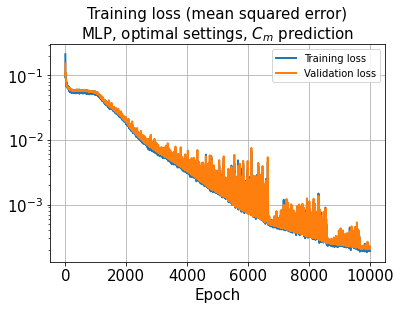

In [33]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

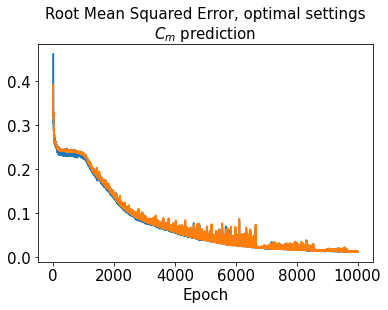

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

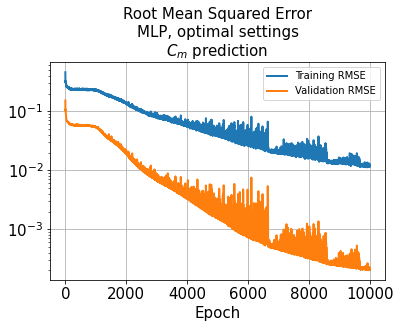

In [35]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [36]:
train_results = model.evaluate(x_train, y_train)

110/110 [==============================] - 0s 4ms/step - loss: 1.9676e-04 - rmse: 0.0118


In [37]:
val_results = model.evaluate(x_val, y_val)

32/32 [==============================] - 0s 4ms/step - loss: 2.0593e-04 - rmse: 0.0122


In [38]:
test_results = model.evaluate(x_test, y_test)

16/16 [==============================] - 0s 4ms/step - loss: 2.1610e-04 - rmse: 0.0126


In [39]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

16/16 [==============================] - 0s 2ms/step


In [40]:
decoded_train_

array([[0.11850373],
       [0.9941464 ],
       [0.21870498],
       ...,
       [0.3177766 ],
       [0.34260705],
       [0.3172131 ]], dtype=float32)

In [41]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [42]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [43]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [44]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [45]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [46]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [47]:
model_directory = "D:\\TrainedModels\\20221226"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221226unsteadyValidation_MLP_Flap4_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_randomState50CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [48]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [49]:
os.chdir(storage_dir)

In [50]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [51]:
l2_error_train = l2_error(decoded_train, y_train)
mape_train = smape(decoded_train, y_train)
print(l2_error_train)
print(mape_train)

0.03380099325531676
1.554472146153061


In [52]:
l2_error_val = l2_error(decoded_val, y_val)
mape_val= smape(decoded_val, y_val)
print(l2_error_val)
print(mape_val)

0.035301380168710816
1.710553912991644


In [53]:
l2_error_test = l2_error(decoded_test, y_test)
mape_test= smape(decoded_test, y_test)
print(l2_error_test)
print(mape_test)

0.04104898985878077
1.7840685821698474


In [54]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [55]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [56]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [57]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [58]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [59]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [60]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

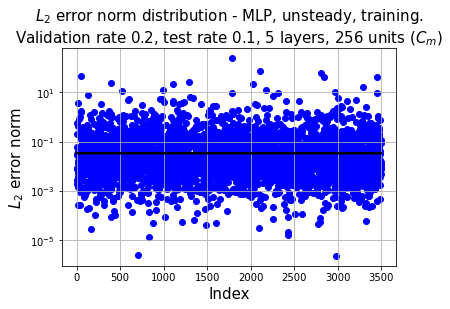

In [61]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

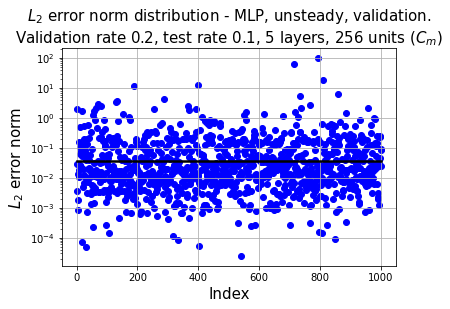

In [62]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

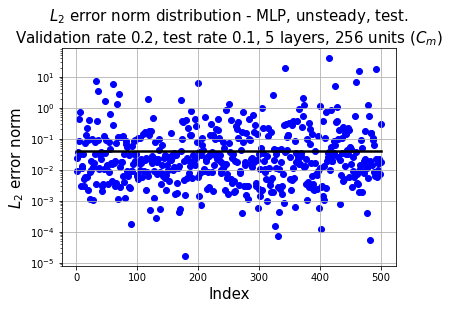

In [63]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [64]:
predicted = model.predict(x)

157/157 [==============================] - 0s 2ms/step


In [65]:
predicted.shape

(5000, 1)

In [66]:
t_train = x[index_train]+10
t_val = x[index_val]+10
t_test = x[index_test]+10

In [67]:
t_train

array([[10.   ],
       [10.001],
       [10.002],
       ...,
       [14.994],
       [14.995],
       [14.997]])

In [68]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [69]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [70]:
x

array([[0.000e+00],
       [1.000e-03],
       [2.000e-03],
       ...,
       [4.997e+00],
       [4.998e+00],
       [4.999e+00]])

In [71]:
x += 10

In [72]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tTest, iTrain, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(x, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(x, denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0271


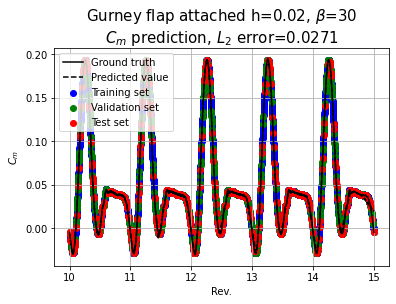

In [73]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]
for i in range(3, 4):
    # Index from each dataset
#     iTrain = []
#     iVal = []
#     iTest = []
    
#     # Index from input data (alpha, in this case)
#     t_train = []
#     t_val = []
#     t_test = []
    
    predictedValue = predicted#[t_len*i:t_len*(i+1),:]
    y_corres = y
    #[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
#     for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
#         iTrain.append(predicted[index])
#     for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
#         iVal.append(predicted[index])    
#     for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
#         iTest.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain = np.array(iTrain)
    iVal = np.array(iVal)
    iTest = np.array(iTest)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
    
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tTest, iTrain, iTest)

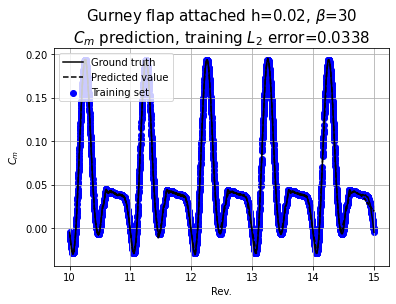

In [74]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[3]) + r'$\beta$=%d'%(beta[3])+'\n$C_m$ prediction, training $L_2$ error=%.4f'%(l2_error_train)
title_Cm = title_n_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
# plt.scatter(tVal, iVal, color='g', label='Validation set')
# plt.scatter(tTest,iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

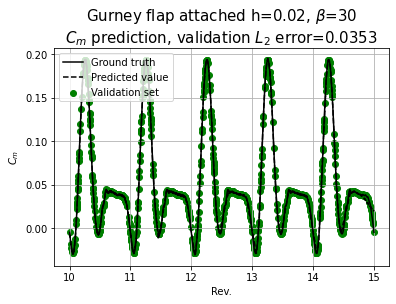

In [75]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap attached h=%.2f, '%(h[3]) + r'$\beta$=%d'%(beta[3])+'\n$C_m$ prediction, validation $L_2$ error=%.4f'%(l2_error_val)
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#plt.scatter(tTest, iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

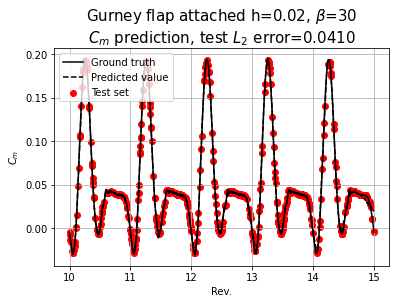

In [76]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap attached h=%.2f, '%(h[3]) + r'$\beta$=%d'%(beta[3])+'\n$C_m$ prediction, test $L_2$ error=%.4f'%(l2_error_test)
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
#plt.scatter(tVal, iVal, color='g', label='Validation set')
plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()